### Wind Power prediction
This notebook contains the code for data processing from the [le haute wind farms](https://opendata-renewables.engie.com/)

The steps below outline the data processing, dataset feature generation, and model training.

This type of prediction will be extended to satellite data on final integration.

We will consolidate data from 2013 to 2020 for wind power output from 4 wind tubines.

The turbine specs are seen from the screen shot below:
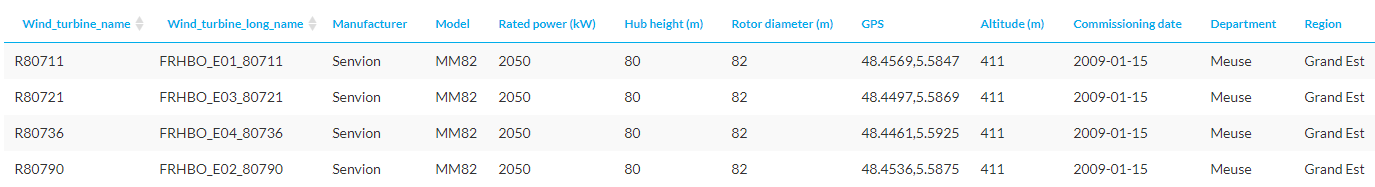


The GLDAS-2.1 Dataset will be used, seen below:

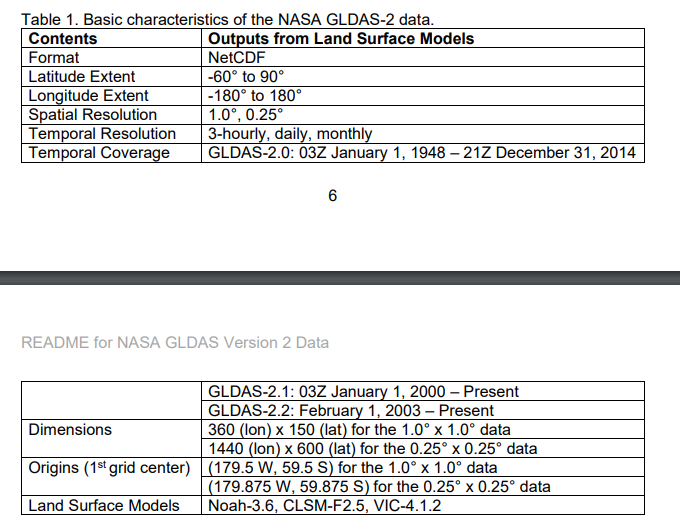

The table below shows a portion of the data types available:

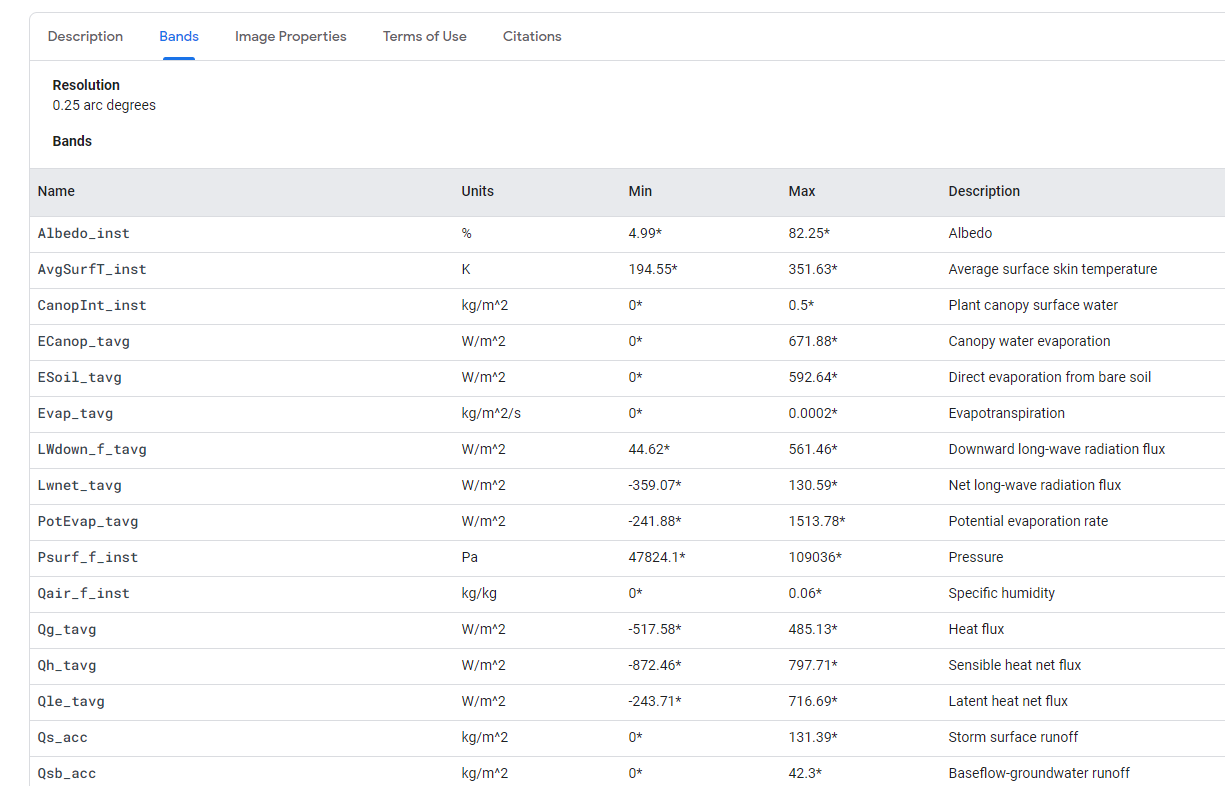

## Connecting GEE with Google Services

- **Authenticate to Earth Engine**

In [2]:
!pip install geemap

     |████████████████████████████████| 378kB 5.6MB/s 
     |████████████████████████████████| 81kB 6.8MB/s 
     |████████████████████████████████| 5.1MB 14.6MB/s 
     |████████████████████████████████| 4.9MB 42.7MB/s 
     |████████████████████████████████| 225kB 47.5MB/s 
     |████████████████████████████████| 1.9MB 42.0MB/s 
     |████████████████████████████████| 102kB 9.9MB/s 
     |████████████████████████████████| 1.1MB 44.9MB/s 
     |████████████████████████████████| 102kB 10.1MB/s 
     |████████████████████████████████| 122kB 51.7MB/s 
     |████████████████████████████████| 112kB 35.4MB/s 
     |████████████████████████████████| 204kB 46.5MB/s 
     |████████████████████████████████| 552kB 36.2MB/s 
  Created wheel for ipynb-py-convert: filename=ipynb_py_convert-0.4.6-cp36-none-any.whl size=4625 sha256=d9b4dd00b24eca67fc565f5fed4e81ec74897ab2f5bc0d130204d1509ef60bcd
  Stored in directory: /root/.cache/pip/wheels/80/dc/7c/a7279f7726d66951fe48d5afd45247bcf5bf92c98282e4e78e

In [3]:
!earthengine authenticate 

Instructions for updating:
non-resource variables are not supported in the long term
Running command using Cloud API.  Set --no-use_cloud_api to go back to using the API

To authorize access needed by Earth Engine, open the following URL in a web browser and follow the instructions. If the web browser does not start automatically, please manually browse the URL below.

    https://accounts.google.com/o/oauth2/auth?client_id=517222506229-vsmmajv00ul0bs7p89v5m89qs8eb9359.apps.googleusercontent.com&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fearthengine+https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdevstorage.full_control&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&response_type=code&code_challenge=38-gW1kEAVtLmDwCBdImIyDS4mZsD3gBuxaDnJsiCYk&code_challenge_method=S256

The authorization workflow will generate a code, which you should paste in the box below. 
Enter verification code: 4/1AfDhmrjVCK7GLEW9Kotm47ahPwuMOzFwX6PSwehVs4YKGoVUXQxlCm3Lajc

Successfully saved authorization token

- **Authenticate to Google Drive (OPTIONAL)**

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


- **Authenticate to Google Cloud (OPTIONAL)**

In [5]:
from google.colab import auth
auth.authenticate_user()

## Testing the software setup




In [6]:
# Earth Engine Python API
import ee
ee.Initialize()

In [7]:
import folium

# Define the URL format used for Earth Engine generated map tiles.
EE_TILES = 'https://earthengine.googleapis.com/map/{mapid}/{{z}}/{{x}}/{{y}}?token={token}'

print('Folium version: ' + folium.__version__)

Folium version: 0.11.0


In [8]:
#@title Mapdisplay: Display GEE objects using folium.
def Mapdisplay(center, dicc, Tiles="OpensTreetMap",zoom_start=10):
    '''
    :param center: Center of the map (Latitude and Longitude).
    :param dicc: Earth Engine Geometries or Tiles dictionary
    :param Tiles: Mapbox Bright,Mapbox Control Room,Stamen Terrain,Stamen Toner,stamenwatercolor,cartodbpositron.
    :zoom_start: Initial zoom level for the map.
    :return: A folium.Map object.
    '''
    mapViz = folium.Map(location=center,tiles=Tiles, zoom_start=zoom_start)
    for k,v in dicc.items():
      if ee.image.Image in [type(x) for x in v.values()]:
        folium.TileLayer(
            tiles = EE_TILES.format(**v),
            attr  = 'Google Earth Engine',
            overlay =True,
            name  = k
          ).add_to(mapViz)
      else:
        folium.GeoJson(
        data = v,
        name = k
          ).add_to(mapViz)
    mapViz.add_child(folium.LayerControl())
    return mapViz

In [9]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import tensorflow as tf
import IPython
import IPython.display

import datetime

from pprint import pprint
from PIL import Image
from sklearn.linear_model import LinearRegression 
from sklearn import preprocessing
from tensorflow import keras

mpl.rcParams['figure.figsize'] = (10, 10)
mpl.rcParams['axes.grid'] = False

In [10]:
FILE_PATH_2017 = "/content/drive/My Drive/EG3301R AI Satellite/Data Folder/le_haupte_wind_farm/la-haute-borne-data-2017-2020.csv"
FILE_PATH_2013 = "/content/drive/My Drive/EG3301R AI Satellite/Data Folder/le_haupte_wind_farm/la-haute-borne-data-2013-2016.csv"
# We divide by 1000 because Earth Engine returns the timestamp in milisecond and Python in seconds.
TIME_FACTOR = 1000

In [11]:
# Le Haute Wind data 
df_2017 = pd.read_csv(FILE_PATH_2017, delimiter=';')
df_2013 = pd.read_csv(FILE_PATH_2013, delimiter=';')

df_2013.head()

,Wind_turbine_name,Date_time,Ba_avg,Ba_min,Ba_max,Ba_std,Rt_avg,Rt_min,Rt_max,Rt_std,DCs_avg,DCs_min,DCs_max,DCs_std,Cm_avg,Cm_min,Cm_max,Cm_std,P_avg,P_min,P_max,P_std,Q_avg,Q_min,Q_max,Q_std,S_avg,S_min,S_max,S_std,Cosphi_avg,Cosphi_min,Cosphi_max,Cosphi_std,Ds_avg,Ds_min,Ds_max,Ds_std,Db1t_avg,Db1t_min,...,Va_avg,Va_min,Va_max,Va_std,Ot_avg,Ot_min,Ot_max,Ot_std,Nf_avg,Nf_min,Nf_max,Nf_std,Nu_avg,Nu_min,Nu_max,Nu_std,Rs_avg,Rs_min,Rs_max,Rs_std,Rbt_avg,Rbt_min,Rbt_max,Rbt_std,Rm_avg,Rm_min,Rm_max,Rm_std,Pas_avg,Pas_min,Pas_max,Pas_std,Wa_c_avg,Wa_c_min,Wa_c_max,Wa_c_std,Na_c_avg,Na_c_min,Na_c_max,Na_c_std
0,R80711,2013-01-07T01:20:00+01:00,41.160000,-1.000000,44.990002,11.27,12.65,12.0,13.0,0.41,204.71001,125.760000,987.83002,140.620000,-6.15,-6.39000,-5.8900,0.08000,-1.380000,-5.620000,-0.70,0.890000,0.000000,-0.79,0.130000,0.030000,1.38,0.700000,5.62000,0.890000,1.00,1.00,1.00,0.00,202.28,123.620000,985.67999,140.580000,28.330000,28.000000,...,4.04,-41.950001,53.730000,10.74,5.25,5.2,5.3,0.05,49.980000,49.959999,50.009998,0.01,705.81000,704.90997,706.41998,0.34,1.91,1.17,9.34,1.32,18.299999,18.299999,18.299999,0.00,-69.540001,-311.60999,-15.660000,30.809999,NaN,NaN,NaN,NaN,37.77000,NaN,NaN,NaN,33.75000,NaN,NaN,NaN
1,R80711,2013-01-05T22:20:00+01:00,-1.000000,-1.000000,-0.870000,0.01,12.95,12.0,13.0,0.16,1157.03000,968.130000,1370.16000,106.870000,1556.76,834.54999,2278.9399,344.91000,161.860000,47.680000,301.62,60.209999,20.170000,10.61,25.120001,2.970000,163.41,50.060001,302.07999,59.549999,0.99,1.00,0.91,0.02,1155.52,966.429990,1368.72000,106.940000,29.580000,28.900000,...,12.88,-39.160000,49.709999,15.27,4.77,4.7,4.9,0.08,50.020000,50.000000,50.049999,0.01,703.96002,701.51001,705.13000,0.77,11.00,9.19,13.06,1.02,20.709999,20.500000,20.900000,0.12,1302.110000,470.04001,2110.980000,389.280000,NaN,NaN,NaN,NaN,313.35001,NaN,NaN,NaN,279.92999,NaN,NaN,NaN
2,R80711,2013-01-06T08:30:00+01:00,-1.000000,-1.000000,-1.000000,0.00,13.74,13.0,14.0,0.35,1021.18000,970.070010,1090.63000,34.230000,1142.24,759.06000,1384.6300,120.20000,91.400002,47.220001,125.49,16.010000,22.740000,12.86,29.740000,2.390000,94.32,52.430000,127.89000,15.540000,0.96,0.99,0.91,0.01,1019.75,968.700010,1089.18990,34.250000,42.520000,41.750000,...,-5.09,-58.009998,26.590000,12.87,5.84,5.8,5.9,0.04,49.980000,49.959999,50.000000,0.01,701.56000,700.03998,703.15997,0.43,9.70,9.21,10.37,0.33,22.000000,22.000000,22.100000,0.01,851.960020,465.51999,1101.860000,122.770000,NaN,NaN,NaN,NaN,241.59000,NaN,NaN,NaN,246.67999,NaN,NaN,NaN
3,R80711,2013-01-05T21:10:00+01:00,44.990002,44.990002,44.990002,0.00,12.14,12.0,13.0,0.27,122.29000,79.279999,175.20000,22.840000,-6.09,-6.42000,-5.8600,0.09000,-0.920000,-1.410000,-0.58,0.130000,0.000000,-0.19,0.100000,0.010000,0.92,0.580000,1.41000,0.130000,1.00,1.00,1.00,0.00,119.91,76.730003,172.60001,22.820000,29.049999,28.900000,...,6.64,-30.110001,49.830002,12.62,5.36,5.3,5.5,0.09,49.959999,49.919998,50.009998,0.02,698.96997,698.03998,700.88000,0.51,1.14,0.73,1.63,0.22,19.400000,19.400000,19.600000,0.02,-76.339996,-141.82001,-39.889999,19.170000,NaN,NaN,NaN,NaN,280.75000,NaN,NaN,NaN,274.12000,NaN,NaN,NaN
4,R80711,2013-01-06T11:20:00+01:00,-0.760000,-1.000000,0.000000,0.40,13.78,13.0,14.0,0.35,1041.27000,960.599980,1157.36000,64.559998,1052.10,249.23000,1557.4200,374.07001,87.900002,0.780000,159.72,46.110001,75.080002,21.92,109.340000,32.619999,124.47,39.889999,183.75000,32.650002,0.77,1.00,0.03,0.28,1039.77,959.049990,1155.93990,64.589996,44.320000,43.599998,...,-0.86,-73.269997,57.419998,16.93,6.57,6.5,6.7,0.09,49.980000,49.959999,50.009998,0.01,700.78003,699.06000,702.03003,0.66,9.90,9.11,11.01,0.62,23.700001,23.600000,23.799999,0.02,785.609990,7.49000,1321.530000,381.579990,NaN,NaN,NaN,NaN,293.01001,NaN,NaN,NaN,293.87000,NaN,NaN,NaN


In [12]:
df_2017.tail()

,Wind_turbine_name,Date_time,Ba_avg,Ba_min,Ba_max,Ba_std,Rt_avg,Rt_min,Rt_max,Rt_std,DCs_avg,DCs_min,DCs_max,DCs_std,Cm_avg,Cm_min,Cm_max,Cm_std,P_avg,P_min,P_max,P_std,Q_avg,Q_min,Q_max,Q_std,S_avg,S_min,S_max,S_std,Cosphi_avg,Cosphi_min,Cosphi_max,Cosphi_std,Ds_avg,Ds_min,Ds_max,Ds_std,Db1t_avg,Db1t_min,...,Va_avg,Va_min,Va_max,Va_std,Ot_avg,Ot_min,Ot_max,Ot_std,Nf_avg,Nf_min,Nf_max,Nf_std,Nu_avg,Nu_min,Nu_max,Nu_std,Rs_avg,Rs_min,Rs_max,Rs_std,Rbt_avg,Rbt_min,Rbt_max,Rbt_std,Rm_avg,Rm_min,Rm_max,Rm_std,Pas_avg,Pas_min,Pas_max,Pas_std,Wa_c_avg,Wa_c_min,Wa_c_max,Wa_c_std,Na_c_avg,Na_c_min,Na_c_max,Na_c_std
217583,R80721,2017-12-13T23:10:00+01:00,1.69,-1.02,13.30,3.62,15.11,15.00,16.0,0.30,1792.47,1729.67,1881.93,22.31,8684.33,3521.82,10943.1,2176.91,1632.28,645.80,2150.67,412.11,141.78,87.24,191.89,24.94,1639.28,662.48,2158.65,409.48,0.99,1.0,0.97,0.0,1796.35,1733.30,1885.85,22.35,31.22,29.50,...,NaN,NaN,NaN,NaN,7.25,7.0,7.35,0.09,49.96,49.92,50.02,0.02,716.27,711.35,718.81,1.56,17.14,16.54,17.99,0.22,29.05,29.0,29.2,0.08,8669.70,3527.88,10901.3,2162.98,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
217584,R80721,2017-12-14T03:30:00+01:00,6.35,-1.01,18.23,5.51,16.15,16.00,17.0,0.33,1796.49,1726.57,1937.13,31.56,10328.00,6230.59,10985.8,1104.19,1940.51,1156.48,2209.48,214.41,177.57,148.25,192.67,9.74,1948.76,1168.98,2217.05,213.32,1.00,1.0,0.99,0.0,1800.36,1730.26,1941.35,31.63,29.34,28.95,...,NaN,NaN,NaN,NaN,5.33,5.1,5.55,0.15,50.00,49.98,50.03,0.01,709.20,705.87,712.71,1.76,17.18,16.53,18.54,0.30,28.43,28.4,28.5,0.04,10289.20,6210.68,10926.5,1094.14,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
217585,R80721,2017-12-14T04:20:00+01:00,-0.57,-1.03,4.32,0.88,17.00,17.00,17.0,0.00,1792.77,1754.76,1833.18,14.02,7553.16,3583.55,10946.7,1902.08,1417.71,657.64,2078.94,358.11,143.31,103.34,183.48,14.95,1425.48,668.72,2082.37,356.28,0.99,1.0,0.98,0.0,1796.65,1758.45,1837.04,14.04,29.24,28.80,...,NaN,NaN,NaN,NaN,4.87,4.8,5.00,0.09,50.00,49.97,50.02,0.01,701.74,699.33,704.31,1.02,17.15,16.78,17.55,0.14,28.70,28.6,28.7,0.01,7531.80,3559.81,10894.8,1892.27,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
217586,R80721,2017-12-14T05:10:00+01:00,-0.83,-1.02,3.89,0.45,17.00,16.76,17.0,0.01,1792.55,1738.23,1831.73,15.85,6745.68,3466.21,10950.8,1836.88,1266.86,632.89,2090.86,348.53,97.18,49.95,141.47,22.35,1271.21,642.65,2093.02,346.97,1.00,1.0,0.98,0.0,1796.41,1741.97,1835.58,15.89,27.26,26.65,...,NaN,NaN,NaN,NaN,4.40,4.2,4.50,0.03,50.04,49.97,50.10,0.04,696.59,693.37,700.91,1.46,17.14,16.64,17.53,0.15,28.70,28.7,28.7,0.00,6726.64,3456.55,10880.8,1826.49,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
217587,R80721,2017-12-14T05:50:00+01:00,-0.76,-1.03,3.86,0.67,16.87,16.00,17.0,0.30,1791.69,1705.03,1852.91,17.24,6893.86,3311.02,10919.5,1875.33,1296.88,590.97,2092.50,355.58,103.13,54.05,174.79,18.31,1301.44,599.29,2094.29,354.36,1.00,1.0,0.98,0.0,1795.54,1708.70,1856.85,17.28,34.85,33.40,...,NaN,NaN,NaN,NaN,4.19,4.1,4.40,0.03,49.97,49.94,50.00,0.01,699.30,694.58,705.98,2.86,17.14,16.29,17.73,0.17,29.08,29.0,29.2,0.08,6889.67,3296.87,10889.8,1866.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [13]:
# combine entire dataset
df = df_2013.append(df_2017, ignore_index=True)
df.tail()

,Wind_turbine_name,Date_time,Ba_avg,Ba_min,Ba_max,Ba_std,Rt_avg,Rt_min,Rt_max,Rt_std,DCs_avg,DCs_min,DCs_max,DCs_std,Cm_avg,Cm_min,Cm_max,Cm_std,P_avg,P_min,P_max,P_std,Q_avg,Q_min,Q_max,Q_std,S_avg,S_min,S_max,S_std,Cosphi_avg,Cosphi_min,Cosphi_max,Cosphi_std,Ds_avg,Ds_min,Ds_max,Ds_std,Db1t_avg,Db1t_min,...,Va_avg,Va_min,Va_max,Va_std,Ot_avg,Ot_min,Ot_max,Ot_std,Nf_avg,Nf_min,Nf_max,Nf_std,Nu_avg,Nu_min,Nu_max,Nu_std,Rs_avg,Rs_min,Rs_max,Rs_std,Rbt_avg,Rbt_min,Rbt_max,Rbt_std,Rm_avg,Rm_min,Rm_max,Rm_std,Pas_avg,Pas_min,Pas_max,Pas_std,Wa_c_avg,Wa_c_min,Wa_c_max,Wa_c_std,Na_c_avg,Na_c_min,Na_c_max,Na_c_std
1057963,R80721,2017-12-13T23:10:00+01:00,1.69,-1.02,13.30,3.62,15.11,15.00,16.0,0.30,1792.47,1729.67,1881.93,22.31,8684.33,3521.82,10943.1,2176.91,1632.28,645.80,2150.67,412.11,141.78,87.24,191.89,24.94,1639.28,662.48,2158.65,409.48,0.99,1.0,0.97,0.0,1796.35,1733.30,1885.85,22.35,31.22,29.50,...,NaN,NaN,NaN,NaN,7.25,7.0,7.35,0.09,49.96,49.92,50.02,0.02,716.27,711.35,718.81,1.56,17.14,16.54,17.99,0.22,29.05,29.0,29.2,0.08,8669.70,3527.88,10901.3,2162.98,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1057964,R80721,2017-12-14T03:30:00+01:00,6.35,-1.01,18.23,5.51,16.15,16.00,17.0,0.33,1796.49,1726.57,1937.13,31.56,10328.00,6230.59,10985.8,1104.19,1940.51,1156.48,2209.48,214.41,177.57,148.25,192.67,9.74,1948.76,1168.98,2217.05,213.32,1.00,1.0,0.99,0.0,1800.36,1730.26,1941.35,31.63,29.34,28.95,...,NaN,NaN,NaN,NaN,5.33,5.1,5.55,0.15,50.00,49.98,50.03,0.01,709.20,705.87,712.71,1.76,17.18,16.53,18.54,0.30,28.43,28.4,28.5,0.04,10289.20,6210.68,10926.5,1094.14,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1057965,R80721,2017-12-14T04:20:00+01:00,-0.57,-1.03,4.32,0.88,17.00,17.00,17.0,0.00,1792.77,1754.76,1833.18,14.02,7553.16,3583.55,10946.7,1902.08,1417.71,657.64,2078.94,358.11,143.31,103.34,183.48,14.95,1425.48,668.72,2082.37,356.28,0.99,1.0,0.98,0.0,1796.65,1758.45,1837.04,14.04,29.24,28.80,...,NaN,NaN,NaN,NaN,4.87,4.8,5.00,0.09,50.00,49.97,50.02,0.01,701.74,699.33,704.31,1.02,17.15,16.78,17.55,0.14,28.70,28.6,28.7,0.01,7531.80,3559.81,10894.8,1892.27,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1057966,R80721,2017-12-14T05:10:00+01:00,-0.83,-1.02,3.89,0.45,17.00,16.76,17.0,0.01,1792.55,1738.23,1831.73,15.85,6745.68,3466.21,10950.8,1836.88,1266.86,632.89,2090.86,348.53,97.18,49.95,141.47,22.35,1271.21,642.65,2093.02,346.97,1.00,1.0,0.98,0.0,1796.41,1741.97,1835.58,15.89,27.26,26.65,...,NaN,NaN,NaN,NaN,4.40,4.2,4.50,0.03,50.04,49.97,50.10,0.04,696.59,693.37,700.91,1.46,17.14,16.64,17.53,0.15,28.70,28.7,28.7,0.00,6726.64,3456.55,10880.8,1826.49,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1057967,R80721,2017-12-14T05:50:00+01:00,-0.76,-1.03,3.86,0.67,16.87,16.00,17.0,0.30,1791.69,1705.03,1852.91,17.24,6893.86,3311.02,10919.5,1875.33,1296.88,590.97,2092.50,355.58,103.13,54.05,174.79,18.31,1301.44,599.29,2094.29,354.36,1.00,1.0,0.98,0.0,1795.54,1708.70,1856.85,17.28,34.85,33.40,...,NaN,NaN,NaN,NaN,4.19,4.1,4.40,0.03,49.97,49.94,50.00,0.01,699.30,694.58,705.98,2.86,17.14,16.29,17.73,0.17,29.08,29.0,29.2,0.08,6889.67,3296.87,10889.8,1866.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


# 3. Filtering an ImageCollection

As illustrated in the Get Started section and the ImageCollection Information section, Earth Engine provides a variety of convenience methods for filtering image collections. Specifically, many common use cases are handled by **imageCollection.filterDate()**, and **imageCollection.filterBounds()**. For general purpose filtering, use **imageCollection.filter()** with an **ee.Filter** as an argument. The following example demonstrates both convenience methods and **filter()** to identify and remove images with bad registration from an **ImageCollection**.

In [14]:
# This function adds a band representing the image timestamp.
# Add Earth Engine dataset
def add_date(img):
    date  = ee.Date(img.get('system:time_start'));
    date_daily = date.format('YYYY-MM-dd');
    return img.set('date_daily', date_daily);


In [15]:
# Load Landsat 5 data, filter by date and bounds.
le_haute_point = ee.Geometry.Point([6.689230, 47.872570])
collection = ee.ImageCollection('NASA/GLDAS/V021/NOAH/G025/T3H').filterDate('2013-01-01', '2013-06-30').filterBounds(le_haute_point).map(add_date)

In [16]:
out_dir = "/content/drive/My Drive/EG3301R AI Satellite/Data Folder/le_haupte_wind_farm/GLDAS"

In [17]:
import geemap

mean = collection.getInfo()
print(mean)

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [18]:
arr = geemap.ee_to_numpy(mean)
print(arr)

The input must be an ee.Image.
None


In [19]:
dataset = ee.ImageCollection("ECMWF/ERA5/MONTHLY").filterDate('2013-01-01', '2020-06-01')
## only run if there is no data
#geemap.ee_export_image_collection(dataset, out_dir=out_dir, region=le_haute_point)

In [20]:
# Get all images read in stored in data frames
import os
image_files = [f for f in os.listdir(out_dir) if os.path.isfile(os.path.join(out_dir, f))]

In [21]:
import gdal
ERA_COL = ['mean_2m_air_temperature', 'minimum_2m_air_temperature', 'maximum_2m_air_temperature', 'dewpoint_2m_temperature', 'total_percipitation', 'surface_pressure', 'mean_sea_level_pressure', 'u_component_of_wind_10m', 'v_component_of_wind_10m']
store = []
for im_file in image_files:
  path = os.path.join(out_dir, im_file)
  im = gdal.Open(path)
  channel = np.array(np.ndarray.flatten(im.ReadAsArray()))
  store.append(channel)

df_image = pd.DataFrame(store, index=[datetime.datetime.strptime(f[:len(f)-4], '%Y%m') for f in image_files], columns=ERA_COL)
df_image.head()

,mean_2m_air_temperature,minimum_2m_air_temperature,maximum_2m_air_temperature,dewpoint_2m_temperature,total_percipitation,surface_pressure,mean_sea_level_pressure,u_component_of_wind_10m,v_component_of_wind_10m
2013-01-01,274.024048,264.395508,284.745636,272.686951,0.066468,97616.953125,101610.601562,1.013305,0.784330
2013-02-01,272.688873,263.343597,280.944031,270.536102,0.065178,97617.390625,101629.976562,-0.113801,-0.670381
2013-03-01,275.325439,264.332367,288.217285,271.392517,0.054084,96911.054688,100852.195312,-1.073613,-0.233716
2013-04-01,282.000275,270.315277,296.735596,276.658691,0.093293,97644.765625,101528.015625,0.012010,-0.061343
2013-05-01,284.116272,274.928894,293.683624,280.836243,0.159289,97364.843750,101207.210938,1.398088,0.251897


### Formula Note
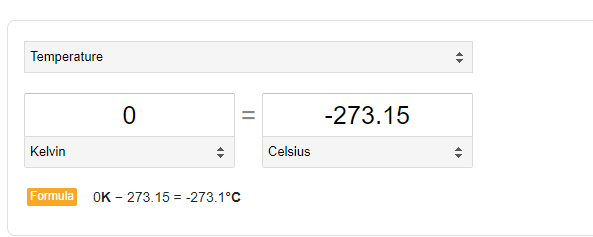

In [22]:
df_image.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
mean_2m_air_temperature,89.0,283.556662,6.361862,271.440216,278.138977,283.076294,289.105469,294.851288
minimum_2m_air_temperature,89.0,273.805394,5.668913,261.902405,270.153046,273.573547,279.148407,284.607941
maximum_2m_air_temperature,89.0,294.882876,8.343967,279.495056,287.019287,294.997772,302.801636,310.990814
dewpoint_2m_temperature,89.0,279.246038,4.856333,268.407745,275.383362,279.042175,283.738251,287.073303
total_percipitation,89.0,0.075806,0.036857,0.010569,0.049618,0.068353,0.096046,0.178706
surface_pressure,89.0,97837.426615,384.345919,96606.242188,97670.578125,97832.460938,98042.703125,99109.101562
mean_sea_level_pressure,89.0,101707.720857,395.350286,100504.773438,101529.523438,101703.710938,101848.242188,103121.218750
u_component_of_wind_10m,89.0,0.659967,0.934730,-1.308436,0.071586,0.603943,1.288380,3.742661
v_component_of_wind_10m,89.0,0.521534,0.993409,-1.306099,-0.151382,0.323099,1.157968,3.131494


In [23]:
df_image['Time'] = pd.to_datetime(df_image.index, utc = True)

In [24]:
# Generating the same processed wind farm data set
df = df.groupby('Date_time').mean().reset_index()

In [25]:
df.dropna(axis=1, how='all', inplace=True)
df.head()

,Date_time,Ba_avg,Ba_min,Ba_max,Ba_std,Rt_avg,Rt_min,Rt_max,Rt_std,DCs_avg,DCs_min,DCs_max,DCs_std,Cm_avg,Cm_min,Cm_max,Cm_std,P_avg,P_min,P_max,P_std,Q_avg,Q_min,Q_max,Q_std,S_avg,S_min,S_max,S_std,Cosphi_avg,Cosphi_min,Cosphi_max,Cosphi_std,Ds_avg,Ds_min,Ds_max,Ds_std,Db1t_avg,Db1t_min,Db1t_max,...,Wa_max,Wa_std,Va1_avg,Va1_min,Va1_max,Va1_std,Va2_avg,Va2_min,Va2_max,Va2_std,Va_avg,Va_min,Va_max,Va_std,Ot_avg,Ot_min,Ot_max,Ot_std,Nf_avg,Nf_min,Nf_max,Nf_std,Nu_avg,Nu_min,Nu_max,Nu_std,Rs_avg,Rs_min,Rs_max,Rs_std,Rbt_avg,Rbt_min,Rbt_max,Rbt_std,Rm_avg,Rm_min,Rm_max,Rm_std,Wa_c_avg,Na_c_avg
0,2013-01-01T00:00:00+01:00,-0.9975,-1.0075,-0.9325,0.0075,14.6500,14.0125,14.75,0.1850,1772.11000,1680.405000,1814.459975,28.5400,4901.060000,3483.357475,7374.075050,726.124982,911.347470,618.897492,1393.187500,144.104995,55.654999,41.307500,75.555000,6.7025,913.747460,623.172507,1394.512500,143.579997,0.9975,1.0,0.9900,0.0,1772.790000,1680.977500,1815.200025,28.5925,37.994999,36.737500,39.537499,...,229.034998,9.1325,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.3700,-36.432501,32.010000,9.1325,5.4325,5.300,5.6625,0.0900,50.009998,49.980000,50.029999,0.01,712.327483,711.425005,713.845000,0.4425,16.917501,16.025000,17.3450,0.2800,28.394999,28.250001,28.499999,0.0550,4884.937450,3441.057450,7357.857550,728.455000,183.162500,182.782502
1,2013-01-01T00:10:00+01:00,-1.0000,-1.0075,-0.9925,0.0050,14.6700,14.1375,14.75,0.1325,1793.29250,1734.225000,1815.572450,14.7375,5301.847400,3524.742500,7327.402475,828.557493,996.365012,642.967498,1386.319975,159.807502,60.757501,40.994999,79.474999,7.6050,998.650000,646.360000,1387.722500,159.287500,1.0000,1.0,0.9925,0.0,1794.007500,1734.914950,1816.370000,14.7600,37.532499,36.662501,38.599999,...,234.590005,8.9500,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.2400,-28.492500,37.557500,8.9500,5.6575,5.425,5.8750,0.1075,49.959999,49.930000,49.990002,0.02,712.512512,711.012498,713.934998,0.5800,17.122500,16.535000,17.3500,0.1475,28.460000,28.350000,28.550000,0.0300,5297.485000,3515.920025,7327.257600,828.212497,185.009995,182.782502
2,2013-01-01T00:20:00+01:00,-1.0000,-1.0175,-0.8775,0.0125,14.6975,14.2150,14.75,0.1050,1796.84245,1753.520000,1819.680025,11.0125,5630.277450,3810.674975,8058.407600,910.627507,1059.937495,703.207488,1524.117500,174.155002,65.187501,45.854999,86.250000,8.9175,1062.385005,706.612517,1525.844975,173.717502,1.0000,1.0,0.9925,0.0,1797.560025,1754.172475,1820.477450,11.0300,38.807499,37.750000,39.925000,...,231.660005,8.5400,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.1575,-22.437500,34.630000,8.5400,5.9550,5.750,6.2000,0.1050,49.990002,49.959999,50.009998,0.01,713.417495,711.834992,714.870012,0.6900,17.157500,16.719999,17.3975,0.1100,28.552500,28.500000,28.612500,0.0350,5627.210075,3802.489925,8030.410050,909.357493,187.947502,182.782502
3,2013-01-01T00:30:00+01:00,-1.0050,-1.0225,-0.8600,0.0100,14.6650,14.2500,14.75,0.1350,1791.80750,1715.337475,1819.830000,18.2600,5726.857550,3521.175000,8315.167350,1022.342505,1075.515055,637.395005,1573.092500,196.572497,66.734999,45.407500,96.382500,10.3150,1078.172500,642.607492,1575.230000,195.965002,0.9975,1.0,0.9900,0.0,1792.532525,1715.992525,1820.629975,18.2775,40.387500,39.337499,41.312499,...,233.924993,9.3475,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.5450,-37.315000,35.182500,10.1025,6.1525,6.025,6.2625,0.0825,50.000000,49.980000,50.009998,0.01,713.107500,711.322477,714.955002,0.8725,17.107500,16.355000,17.3950,0.1800,28.607501,28.524999,28.700001,0.0475,5719.070075,3507.300000,8306.972650,1020.822527,190.444995,185.775002
4,2013-01-01T00:40:00+01:00,-0.9925,-1.0100,-0.8650,0.0300,14.5675,14.2500,14.75,0.1725,1790.08000,1686.735000,1817.800000,23.2025,5699.977525,3459.990000,8042.842400,1027.937507,1068.825028,614.107498,1520.570000,199.635000,65.877498,43.077499,93.245000,10.1050,1071.669977,618.602500,1522.287500,198.980003,0.9975,1.0,0.9900,0.0,1790.792525,1687.307500,1818.522475,23.2325,40.565000,39.412498,41.575000,...,236.524997,9.8350,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.8

In [26]:
df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
Ba_avg,263499.0,13.514613,21.382407,-30.847500,-0.992500,-0.747500,22.407500,92.750000
Ba_min,263499.0,12.426581,21.079952,-33.502500,-0.995000,-0.992500,22.247500,92.750000
Ba_max,263499.0,14.989972,21.871463,-30.065000,-0.990000,0.125000,22.755000,97.899999
Ba_std,263499.0,0.861395,2.608254,0.000000,0.000000,0.002500,0.192500,46.074999
Rt_avg,263499.0,19.356408,6.194292,4.085000,14.342500,19.000000,23.822500,71.182500
...,...,...,...,...,...,...,...,...
Rm_min,263314.0,1151.416293,1370.720502,-1855.527500,0.000000,874.666246,1920.598125,10700.150000
Rm_max,263314.0,2920.287851,3017.975754,-317.292505,704.789378,1940.732512,4072.803050,10956.325000
Rm_std,263314.0,414.872193,473.411843,0.000000,98.870001,238.115000,522.856250,4631.892475
Wa_c_avg,210515.0,177.376591,90.425630,1.345000,94.705001,194.077500,245.047504,359.072500


In [27]:
df.set_index(pd.to_datetime(df['Date_time']), inplace=True)

In [28]:
df.sort_index(inplace=True)
df.drop(columns=['Date_time'], inplace=True)
df.head()

,Ba_avg,Ba_min,Ba_max,Ba_std,Rt_avg,Rt_min,Rt_max,Rt_std,DCs_avg,DCs_min,DCs_max,DCs_std,Cm_avg,Cm_min,Cm_max,Cm_std,P_avg,P_min,P_max,P_std,Q_avg,Q_min,Q_max,Q_std,S_avg,S_min,S_max,S_std,Cosphi_avg,Cosphi_min,Cosphi_max,Cosphi_std,Ds_avg,Ds_min,Ds_max,Ds_std,Db1t_avg,Db1t_min,Db1t_max,Db1t_std,...,Wa_max,Wa_std,Va1_avg,Va1_min,Va1_max,Va1_std,Va2_avg,Va2_min,Va2_max,Va2_std,Va_avg,Va_min,Va_max,Va_std,Ot_avg,Ot_min,Ot_max,Ot_std,Nf_avg,Nf_min,Nf_max,Nf_std,Nu_avg,Nu_min,Nu_max,Nu_std,Rs_avg,Rs_min,Rs_max,Rs_std,Rbt_avg,Rbt_min,Rbt_max,Rbt_std,Rm_avg,Rm_min,Rm_max,Rm_std,Wa_c_avg,Na_c_avg
Date_time,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2013-01-01 00:00:00+01:00,-0.9975,-1.0075,-0.9325,0.0075,14.6500,14.0125,14.75,0.1850,1772.11000,1680.405000,1814.459975,28.5400,4901.060000,3483.357475,7374.075050,726.124982,911.347470,618.897492,1393.187500,144.104995,55.654999,41.307500,75.555000,6.7025,913.747460,623.172507,1394.512500,143.579997,0.9975,1.0,0.9900,0.0,1772.790000,1680.977500,1815.200025,28.5925,37.994999,36.737500,39.537499,0.7075,...,229.034998,9.1325,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.3700,-36.432501,32.010000,9.1325,5.4325,5.300,5.6625,0.0900,50.009998,49.980000,50.029999,0.01,712.327483,711.425005,713.845000,0.4425,16.917501,16.025000,17.3450,0.2800,28.394999,28.250001,28.499999,0.0550,4884.937450,3441.057450,7357.857550,728.455000,183.162500,182.782502
2013-01-01 00:10:00+01:00,-1.0000,-1.0075,-0.9925,0.0050,14.6700,14.1375,14.75,0.1325,1793.29250,1734.225000,1815.572450,14.7375,5301.847400,3524.742500,7327.402475,828.557493,996.365012,642.967498,1386.319975,159.807502,60.757501,40.994999,79.474999,7.6050,998.650000,646.360000,1387.722500,159.287500,1.0000,1.0,0.9925,0.0,1794.007500,1734.914950,1816.370000,14.7600,37.532499,36.662501,38.599999,0.4525,...,234.590005,8.9500,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.2400,-28.492500,37.557500,8.9500,5.6575,5.425,5.8750,0.1075,49.959999,49.930000,49.990002,0.02,712.512512,711.012498,713.934998,0.5800,17.122500,16.535000,17.3500,0.1475,28.460000,28.350000,28.550000,0.0300,5297.485000,3515.920025,7327.257600,828.212497,185.009995,182.782502
2013-01-01 00:20:00+01:00,-1.0000,-1.0175,-0.8775,0.0125,14.6975,14.2150,14.75,0.1050,1796.84245,1753.520000,1819.680025,11.0125,5630.277450,3810.674975,8058.407600,910.627507,1059.937495,703.207488,1524.117500,174.155002,65.187501,45.854999,86.250000,8.9175,1062.385005,706.612517,1525.844975,173.717502,1.0000,1.0,0.9925,0.0,1797.560025,1754.172475,1820.477450,11.0300,38.807499,37.750000,39.925000,0.5350,...,231.660005,8.5400,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.1575,-22.437500,34.630000,8.5400,5.9550,5.750,6.2000,0.1050,49.990002,49.959999,50.009998,0.01,713.417495,711.834992,714.870012,0.6900,17.157500,16.719999,17.3975,0.1100,28.552500,28.500000,28.612500,0.0350,5627.210075,3802.489925,8030.410050,909.357493,187.947502,182.782502
2013-01-01 00:30:00+01:00,-1.0050,-1.0225,-0.8600,0.0100,14.6650,14.2500,14.75,0.1350,1791.80750,1715.337475,1819.830000,18.2600,5726.857550,3521.175000,8315.167350,1022.342505,1075.515055,637.395005,1573.092500,196.572497,66.734999,45.407500,96.382500,10.3150,1078.172500,642.607492,1575.230000,195.965002,0.9975,1.0,0.9900,0.0,1792.532525,1715.992525,1820.629975,18.2775,40.387500,39.337499,41.312499,0.4650,...,233.924993,9.3475,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.5450,-37.315000,35.182500,10.1025,6.1525,6.025,6.2625,0.0825,50.000000,49.980000,50.009998,0.01,713.107500,711.322477,714.955002,0.8725,17.107500,16.355000,17.3950,0.1800,28.607501,28.524999,28.700001,0.0475,5719.070075,3507.300000,8306.972650,1020.822527,190.444995,185.775002
2013-01-01 00:40:00+01:00,-0.9925,-1.0100,-0.8650,0.0300,14.5675,14.2500,14.75,0.1725,1790.08000,1686.735000,1817.800000,23.2025,5699.977525,3459.990000,8042.842400,1027.937507,1068.825028,614.107498,1520.570000,199.635000,65.877498,43.077499,93.245000,10.1050,1071.669977,618.602500,1522.287500,198.980003,0.9975,1.0,0.9900,0.0,1790.792525,1687.307500

In [29]:
df.index = pd.to_datetime(df.index, utc=True)

In [30]:
df.sort_index(inplace=True)

In [31]:
df.head()

,Ba_avg,Ba_min,Ba_max,Ba_std,Rt_avg,Rt_min,Rt_max,Rt_std,DCs_avg,DCs_min,DCs_max,DCs_std,Cm_avg,Cm_min,Cm_max,Cm_std,P_avg,P_min,P_max,P_std,Q_avg,Q_min,Q_max,Q_std,S_avg,S_min,S_max,S_std,Cosphi_avg,Cosphi_min,Cosphi_max,Cosphi_std,Ds_avg,Ds_min,Ds_max,Ds_std,Db1t_avg,Db1t_min,Db1t_max,Db1t_std,...,Wa_max,Wa_std,Va1_avg,Va1_min,Va1_max,Va1_std,Va2_avg,Va2_min,Va2_max,Va2_std,Va_avg,Va_min,Va_max,Va_std,Ot_avg,Ot_min,Ot_max,Ot_std,Nf_avg,Nf_min,Nf_max,Nf_std,Nu_avg,Nu_min,Nu_max,Nu_std,Rs_avg,Rs_min,Rs_max,Rs_std,Rbt_avg,Rbt_min,Rbt_max,Rbt_std,Rm_avg,Rm_min,Rm_max,Rm_std,Wa_c_avg,Na_c_avg
Date_time,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2012-12-31 23:00:00+00:00,-0.9975,-1.0075,-0.9325,0.0075,14.6500,14.0125,14.75,0.1850,1772.11000,1680.405000,1814.459975,28.5400,4901.060000,3483.357475,7374.075050,726.124982,911.347470,618.897492,1393.187500,144.104995,55.654999,41.307500,75.555000,6.7025,913.747460,623.172507,1394.512500,143.579997,0.9975,1.0,0.9900,0.0,1772.790000,1680.977500,1815.200025,28.5925,37.994999,36.737500,39.537499,0.7075,...,229.034998,9.1325,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.3700,-36.432501,32.010000,9.1325,5.4325,5.300,5.6625,0.0900,50.009998,49.980000,50.029999,0.01,712.327483,711.425005,713.845000,0.4425,16.917501,16.025000,17.3450,0.2800,28.394999,28.250001,28.499999,0.0550,4884.937450,3441.057450,7357.857550,728.455000,183.162500,182.782502
2012-12-31 23:10:00+00:00,-1.0000,-1.0075,-0.9925,0.0050,14.6700,14.1375,14.75,0.1325,1793.29250,1734.225000,1815.572450,14.7375,5301.847400,3524.742500,7327.402475,828.557493,996.365012,642.967498,1386.319975,159.807502,60.757501,40.994999,79.474999,7.6050,998.650000,646.360000,1387.722500,159.287500,1.0000,1.0,0.9925,0.0,1794.007500,1734.914950,1816.370000,14.7600,37.532499,36.662501,38.599999,0.4525,...,234.590005,8.9500,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.2400,-28.492500,37.557500,8.9500,5.6575,5.425,5.8750,0.1075,49.959999,49.930000,49.990002,0.02,712.512512,711.012498,713.934998,0.5800,17.122500,16.535000,17.3500,0.1475,28.460000,28.350000,28.550000,0.0300,5297.485000,3515.920025,7327.257600,828.212497,185.009995,182.782502
2012-12-31 23:20:00+00:00,-1.0000,-1.0175,-0.8775,0.0125,14.6975,14.2150,14.75,0.1050,1796.84245,1753.520000,1819.680025,11.0125,5630.277450,3810.674975,8058.407600,910.627507,1059.937495,703.207488,1524.117500,174.155002,65.187501,45.854999,86.250000,8.9175,1062.385005,706.612517,1525.844975,173.717502,1.0000,1.0,0.9925,0.0,1797.560025,1754.172475,1820.477450,11.0300,38.807499,37.750000,39.925000,0.5350,...,231.660005,8.5400,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.1575,-22.437500,34.630000,8.5400,5.9550,5.750,6.2000,0.1050,49.990002,49.959999,50.009998,0.01,713.417495,711.834992,714.870012,0.6900,17.157500,16.719999,17.3975,0.1100,28.552500,28.500000,28.612500,0.0350,5627.210075,3802.489925,8030.410050,909.357493,187.947502,182.782502
2012-12-31 23:30:00+00:00,-1.0050,-1.0225,-0.8600,0.0100,14.6650,14.2500,14.75,0.1350,1791.80750,1715.337475,1819.830000,18.2600,5726.857550,3521.175000,8315.167350,1022.342505,1075.515055,637.395005,1573.092500,196.572497,66.734999,45.407500,96.382500,10.3150,1078.172500,642.607492,1575.230000,195.965002,0.9975,1.0,0.9900,0.0,1792.532525,1715.992525,1820.629975,18.2775,40.387500,39.337499,41.312499,0.4650,...,233.924993,9.3475,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.5450,-37.315000,35.182500,10.1025,6.1525,6.025,6.2625,0.0825,50.000000,49.980000,50.009998,0.01,713.107500,711.322477,714.955002,0.8725,17.107500,16.355000,17.3950,0.1800,28.607501,28.524999,28.700001,0.0475,5719.070075,3507.300000,8306.972650,1020.822527,190.444995,185.775002
2012-12-31 23:40:00+00:00,-0.9925,-1.0100,-0.8650,0.0300,14.5675,14.2500,14.75,0.1725,1790.08000,1686.735000,1817.800000,23.2025,5699.977525,3459.990000,8042.842400,1027.937507,1068.825028,614.107498,1520.570000,199.635000,65.877498,43.077499,93.245000,10.1050,1071.669977,618.602500,1522.287500,198.980003,0.9975,1.0,0.9900,0.0,1790.792525,1687.307500

In [32]:
df.resample('D').mean()

,Ba_avg,Ba_min,Ba_max,Ba_std,Rt_avg,Rt_min,Rt_max,Rt_std,DCs_avg,DCs_min,DCs_max,DCs_std,Cm_avg,Cm_min,Cm_max,Cm_std,P_avg,P_min,P_max,P_std,Q_avg,Q_min,Q_max,Q_std,S_avg,S_min,S_max,S_std,Cosphi_avg,Cosphi_min,Cosphi_max,Cosphi_std,Ds_avg,Ds_min,Ds_max,Ds_std,Db1t_avg,Db1t_min,Db1t_max,Db1t_std,...,Wa_max,Wa_std,Va1_avg,Va1_min,Va1_max,Va1_std,Va2_avg,Va2_min,Va2_max,Va2_std,Va_avg,Va_min,Va_max,Va_std,Ot_avg,Ot_min,Ot_max,Ot_std,Nf_avg,Nf_min,Nf_max,Nf_std,Nu_avg,Nu_min,Nu_max,Nu_std,Rs_avg,Rs_min,Rs_max,Rs_std,Rbt_avg,Rbt_min,Rbt_max,Rbt_std,Rm_avg,Rm_min,Rm_max,Rm_std,Wa_c_avg,Na_c_avg
Date_time,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2012-12-31 00:00:00+00:00,-0.997500,-1.012500,-0.880417,0.016667,14.633750,14.169167,14.750000,0.156250,1788.394579,1710.885417,1817.914988,20.061250,5454.899154,3528.064167,7829.923721,915.510003,1022.585427,635.957498,1480.460412,177.493750,62.767500,42.559166,86.926666,8.852083,1025.150825,640.114585,1482.092496,176.926250,0.997917,1.000000,0.990833,0.000000,1789.101683,1711.503321,1818.674150,20.089583,39.146249,38.062500,40.285416,0.544167,...,220.886666,9.284583,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.976250,-32.552083,36.467500,9.428750,5.961250,5.816667,6.125000,0.082917,49.988333,49.964167,50.006666,0.011667,712.205416,710.756249,713.829168,0.658333,17.074583,16.313750,17.376667,0.197083,28.520417,28.433333,28.604167,0.037500,5445.080825,3504.112913,7815.623417,915.693335,188.549583,185.359585
2013-01-01 00:00:00+00:00,-0.785972,-1.003403,0.710590,0.358194,14.378507,14.191667,14.659149,0.113368,1604.068766,1498.758958,1684.842886,44.030469,4490.487189,2814.715539,6288.920328,815.392030,793.146423,460.837257,1152.785277,159.894913,58.788576,36.831649,81.267188,9.001094,796.056094,465.922101,1154.651619,159.236545,0.993663,0.998385,0.977726,0.002153,1604.473491,1499.026390,1685.351734,44.089028,39.147326,37.973437,40.339063,0.562726,...,226.767604,10.694097,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-1.051302,-40.518715,37.545556,10.894844,5.349479,5.232118,5.461285,0.057830,50.001562,49.982362,50.019426,0.009340,707.632657,705.941372,709.358211,0.755469,15.304531,14.277083,16.098403,0.424392,27.875347,27.788021,27.966320,0.044427,4413.959979,2709.936496,6221.557900,823.766961,226.904653,227.674480
2013-01-02 00:00:00+00:00,8.922031,7.558282,10.427657,0.937778,13.238368,12.976510,13.396285,0.110451,987.617515,918.225678,1064.049809,40.775573,1360.563822,1085.628386,1648.305923,137.499583,180.117326,139.344584,224.921545,20.805382,23.953490,14.838976,34.288438,3.385191,186.306181,148.054253,233.445469,20.527795,0.972656,0.990122,0.924583,0.014306,987.139340,917.660520,1063.659652,40.827621,40.154757,39.357205,40.957552,0.366337,...,227.768576,15.227674,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-1.642830,-49.688611,47.012413,15.685069,3.805052,3.670920,3.940365,0.068455,49.991181,49.969132,50.013315,0.010451,702.158507,700.720955,703.675921,0.627587,9.402326,8.724670,10.148403,0.391510,23.107378,23.000955,23.213108,0.056250,1169.959232,852.470436,1475.842637,150.179062,240.521372,242.244444
2013-01-03 00:00:00+00:00,-0.808576,-0.998194,-0.486580,0.206788,13.232951,13.087205,13.444740,0.089896,1461.172622,1288.863124,1592.196874,76.199601,2704.386788,1932.622101,3578.391722,365.587170,419.251458,254.728924,608.009115,80.419115,31.718316,20.918160,41.072934,3.836111,421.056528,258.148802,609.089149,79.958871,0.993316,0.991806,0.974757,0.002882,1461.443768,1288.908402,1592.642033,76.300243,43.350937,42.281510,44.440625,0.478368,...,236.580659,11.378194,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.033229,-43.563524,40.232708,11.495556,5.283976,5.196007,5.386632,0.045087,49.987448,49.965035,50.010121,0.010868,701.325002,699.618438,702.952587,0.764826,13.932899,12.265226,15.211441,0.731615,26.271215,26.175781,26.365365,0.048733,2584.484138,1752.543146,3501.666026,390.807622,215.963212,215.927728
2013-01-04 00:00:00+00:00,-0.123038,-0.595573,0.818767,0.503194,15.432951,15.158594,15.759653,0

In [33]:
df['Time'] = df.index

In [34]:
df.isnull().all()

Ba_avg      False
Ba_min      False
Ba_max      False
Ba_std      False
Rt_avg      False
            ...  
Rm_max      False
Rm_std      False
Wa_c_avg    False
Na_c_avg    False
Time        False
Length: 127, dtype: bool

In [35]:
final = pd.merge_ordered(df, df_image, on='Time')

In [36]:
final.head()

,Ba_avg,Ba_min,Ba_max,Ba_std,Rt_avg,Rt_min,Rt_max,Rt_std,DCs_avg,DCs_min,DCs_max,DCs_std,Cm_avg,Cm_min,Cm_max,Cm_std,P_avg,P_min,P_max,P_std,Q_avg,Q_min,Q_max,Q_std,S_avg,S_min,S_max,S_std,Cosphi_avg,Cosphi_min,Cosphi_max,Cosphi_std,Ds_avg,Ds_min,Ds_max,Ds_std,Db1t_avg,Db1t_min,Db1t_max,Db1t_std,...,Va_avg,Va_min,Va_max,Va_std,Ot_avg,Ot_min,Ot_max,Ot_std,Nf_avg,Nf_min,Nf_max,Nf_std,Nu_avg,Nu_min,Nu_max,Nu_std,Rs_avg,Rs_min,Rs_max,Rs_std,Rbt_avg,Rbt_min,Rbt_max,Rbt_std,Rm_avg,Rm_min,Rm_max,Rm_std,Wa_c_avg,Na_c_avg,Time,mean_2m_air_temperature,minimum_2m_air_temperature,maximum_2m_air_temperature,dewpoint_2m_temperature,total_percipitation,surface_pressure,mean_sea_level_pressure,u_component_of_wind_10m,v_component_of_wind_10m
0,-0.9975,-1.0075,-0.9325,0.0075,14.6500,14.0125,14.75,0.1850,1772.11000,1680.405000,1814.459975,28.5400,4901.060000,3483.357475,7374.075050,726.124982,911.347470,618.897492,1393.187500,144.104995,55.654999,41.307500,75.555000,6.7025,913.747460,623.172507,1394.512500,143.579997,0.9975,1.0,0.9900,0.0,1772.790000,1680.977500,1815.200025,28.5925,37.994999,36.737500,39.537499,0.7075,...,0.3700,-36.432501,32.010000,9.1325,5.4325,5.300,5.6625,0.0900,50.009998,49.980000,50.029999,0.01,712.327483,711.425005,713.845000,0.4425,16.917501,16.025000,17.3450,0.2800,28.394999,28.250001,28.499999,0.0550,4884.937450,3441.057450,7357.857550,728.455000,183.162500,182.782502,2012-12-31 23:00:00+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,-1.0000,-1.0075,-0.9925,0.0050,14.6700,14.1375,14.75,0.1325,1793.29250,1734.225000,1815.572450,14.7375,5301.847400,3524.742500,7327.402475,828.557493,996.365012,642.967498,1386.319975,159.807502,60.757501,40.994999,79.474999,7.6050,998.650000,646.360000,1387.722500,159.287500,1.0000,1.0,0.9925,0.0,1794.007500,1734.914950,1816.370000,14.7600,37.532499,36.662501,38.599999,0.4525,...,2.2400,-28.492500,37.557500,8.9500,5.6575,5.425,5.8750,0.1075,49.959999,49.930000,49.990002,0.02,712.512512,711.012498,713.934998,0.5800,17.122500,16.535000,17.3500,0.1475,28.460000,28.350000,28.550000,0.0300,5297.485000,3515.920025,7327.257600,828.212497,185.009995,182.782502,2012-12-31 23:10:00+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,-1.0000,-1.0175,-0.8775,0.0125,14.6975,14.2150,14.75,0.1050,1796.84245,1753.520000,1819.680025,11.0125,5630.277450,3810.674975,8058.407600,910.627507,1059.937495,703.207488,1524.117500,174.155002,65.187501,45.854999,86.250000,8.9175,1062.385005,706.612517,1525.844975,173.717502,1.0000,1.0,0.9925,0.0,1797.560025,1754.172475,1820.477450,11.0300,38.807499,37.750000,39.925000,0.5350,...,5.1575,-22.437500,34.630000,8.5400,5.9550,5.750,6.2000,0.1050,49.990002,49.959999,50.009998,0.01,713.417495,711.834992,714.870012,0.6900,17.157500,16.719999,17.3975,0.1100,28.552500,28.500000,28.612500,0.0350,5627.210075,3802.489925,8030.410050,909.357493,187.947502,182.782502,2012-12-31 23:20:00+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,-1.0050,-1.0225,-0.8600,0.0100,14.6650,14.2500,14.75,0.1350,1791.80750,1715.337475,1819.830000,18.2600,5726.857550,3521.175000,8315.167350,1022.342505,1075.515055,637.395005,1573.092500,196.572497,66.734999,45.407500,96.382500,10.3150,1078.172500,642.607492,1575.230000,195.965002,0.9975,1.0,0.9900,0.0,1792.532525,1715.992525,1820.629975,18.2775,40.387500,39.337499,41.312499,0.4650,...,3.5450,-37.315000,35.182500,10.1025,6.1525,6.025,6.2625,0.0825,50.000000,49.980000,50.009998,0.01,713.107500,711.322477,714.955002,0.8725,17.107500,16.355000,17.3950,0.1800,28.607501,28.524999,28.700001,0.0475,5719.070075,3507.300000,8306.972650,1020.822527,190.444995,185.775002,2012-12-31 23:30:00+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,-0.9925,-1.0100,-0.8650,0.0300,14.5675,14.2500,14.75,0.1725,1790.08000,1686.735000,1817.800000,23.2025,5699.977525,3459.990000,8042.842400,1027.937507,1068.825028,614.107498,1520.570000,199.635000,65.877498,43.077499,93.245000,10.1050,1071.669977,618.602500,1522.287500,198.980003,0.9975,1.0,0.9900,0.0,1790.792525,1687.307500,1818.522475,23.2325,40.5

In [37]:
power = final['P_avg'].notnull()
satellite = final['u_component_of_wind_10m'].notnull()
final_data = final[power & satellite].copy().set_index('Time')

In [38]:
final_data.head()

,Ba_avg,Ba_min,Ba_max,Ba_std,Rt_avg,Rt_min,Rt_max,Rt_std,DCs_avg,DCs_min,DCs_max,DCs_std,Cm_avg,Cm_min,Cm_max,Cm_std,P_avg,P_min,P_max,P_std,Q_avg,Q_min,Q_max,Q_std,S_avg,S_min,S_max,S_std,Cosphi_avg,Cosphi_min,Cosphi_max,Cosphi_std,Ds_avg,Ds_min,Ds_max,Ds_std,Db1t_avg,Db1t_min,Db1t_max,Db1t_std,...,Va2_std,Va_avg,Va_min,Va_max,Va_std,Ot_avg,Ot_min,Ot_max,Ot_std,Nf_avg,Nf_min,Nf_max,Nf_std,Nu_avg,Nu_min,Nu_max,Nu_std,Rs_avg,Rs_min,Rs_max,Rs_std,Rbt_avg,Rbt_min,Rbt_max,Rbt_std,Rm_avg,Rm_min,Rm_max,Rm_std,Wa_c_avg,Na_c_avg,mean_2m_air_temperature,minimum_2m_air_temperature,maximum_2m_air_temperature,dewpoint_2m_temperature,total_percipitation,surface_pressure,mean_sea_level_pressure,u_component_of_wind_10m,v_component_of_wind_10m
Time,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2013-01-01 00:00:00+00:00,-0.9950,-1.007500,-0.865000,0.0250,14.5075,14.250,14.750,0.2100,1791.010025,1730.215000,1819.750025,17.557501,5599.269900,3590.850050,7851.810025,935.530017,1050.084998,653.737505,1481.530000,180.740000,64.270000,39.440001,85.622499,9.0775,1052.849997,657.525008,1483.135000,180.190000,0.9975,1.000,0.9925,0.0000,1791.707425,1730.959950,1820.500000,17.582500,38.550000,37.250000,40.000000,0.6900,...,NaN,4.1000,-31.977500,33.625000,9.4050,6.3100,6.2000,6.3875,0.0350,50.009998,49.980000,50.020000,0.01,711.585023,710.135010,712.854997,0.5575,17.097500,16.490001,17.3975,0.1750,28.552500,28.4500,28.700001,0.0625,5586.714950,3572.39245,7828.024900,934.552490,193.165005,189.092500,274.024048,264.395508,284.745636,272.686951,0.066468,97616.953125,101610.601562,1.013305,0.784330
2013-02-01 00:00:00+00:00,-0.9850,-0.992500,-0.980000,0.0000,15.5000,15.500,15.590,0.0025,1685.725000,1461.170000,1810.749975,98.767502,3618.685050,2430.765000,5702.955100,722.607515,640.052505,358.442502,1077.450005,165.417495,37.895000,23.745000,60.032500,7.2450,641.555010,361.535005,1078.089997,164.867500,1.0000,1.000,0.9875,0.0000,1686.222500,1461.385000,1811.475000,98.912499,41.265000,40.437500,42.250001,0.3900,...,NaN,-4.2825,-46.472500,56.342500,11.6950,7.7175,7.6125,7.8500,0.0550,50.000000,49.970001,50.024999,0.01,705.490005,703.417510,707.557495,0.8825,16.087499,13.912500,17.3175,0.9500,29.175000,29.1500,29.262500,0.0100,3581.647525,2312.76000,5701.227525,749.144990,226.267500,230.525002,272.688873,263.343597,280.944031,270.536102,0.065178,97617.390625,101629.976562,-0.113801,-0.670381
2013-03-01 00:00:00+00:00,-0.8925,-1.005000,-0.225000,0.2150,11.4900,11.160,11.750,0.1300,980.287507,966.649993,1009.099997,12.002500,945.490000,596.367507,1144.520025,139.147500,67.702500,30.565000,90.615002,15.152500,18.470000,10.640000,21.697499,1.4875,70.377499,34.700000,92.590000,14.585000,0.9800,1.000,0.9400,0.0150,979.850005,966.225007,1008.667495,12.017500,39.807501,38.912501,40.887500,0.4775,...,NaN,1.6550,-47.107501,50.675001,12.0575,1.5550,1.4875,1.6750,0.0525,49.990002,49.959999,50.029999,0.01,693.409987,692.009995,694.475005,0.5475,9.325000,9.182500,9.6125,0.1150,19.907500,19.8000,19.937500,0.0200,658.195007,301.45000,859.305007,141.252500,38.737499,37.077500,275.325439,264.332367,288.217285,271.392517,0.054084,96911.054688,100852.195312,-1.073613,-0.233716
2013-04-01 00:00:00+00:00,-0.9925,-0.997500,-0.992500,0.0000,11.0625,10.750,11.665,0.1500,1483.217475,1324.052475,1690.177450,79.945002,2708.400025,2076.537525,3823.097550,338.880005,407.795000,265.377500,669.822487,80.750000,33.467500,22.782500,42.167501,3.3425,409.367500,268.500000,670.429998,80.282498,0.9950,1.000,0.9875,0.0000,1483.362500,1323.959975,1690.625000,80.077500,43.795001,42.887500,44.600001,0.3375,...,NaN,-2.7400,-49.457500,42.547499,10.9900,-0.7975,-0.8875,-0.6625,0.0425,50.020000,50.000000,50.040001,0.01,704.707503,703.699997,705.770005,0.4075,14.140000,12.602500,16.1450,0.7675,24.672501,24.5625,24.750000,0.0700,2601.537525,1904.46995,3783.525000,369.480003,46.145000,48.877499,282.000275,270.315277,296.735596,276.658691,0.093293,97644.765625,101528.015625,0.

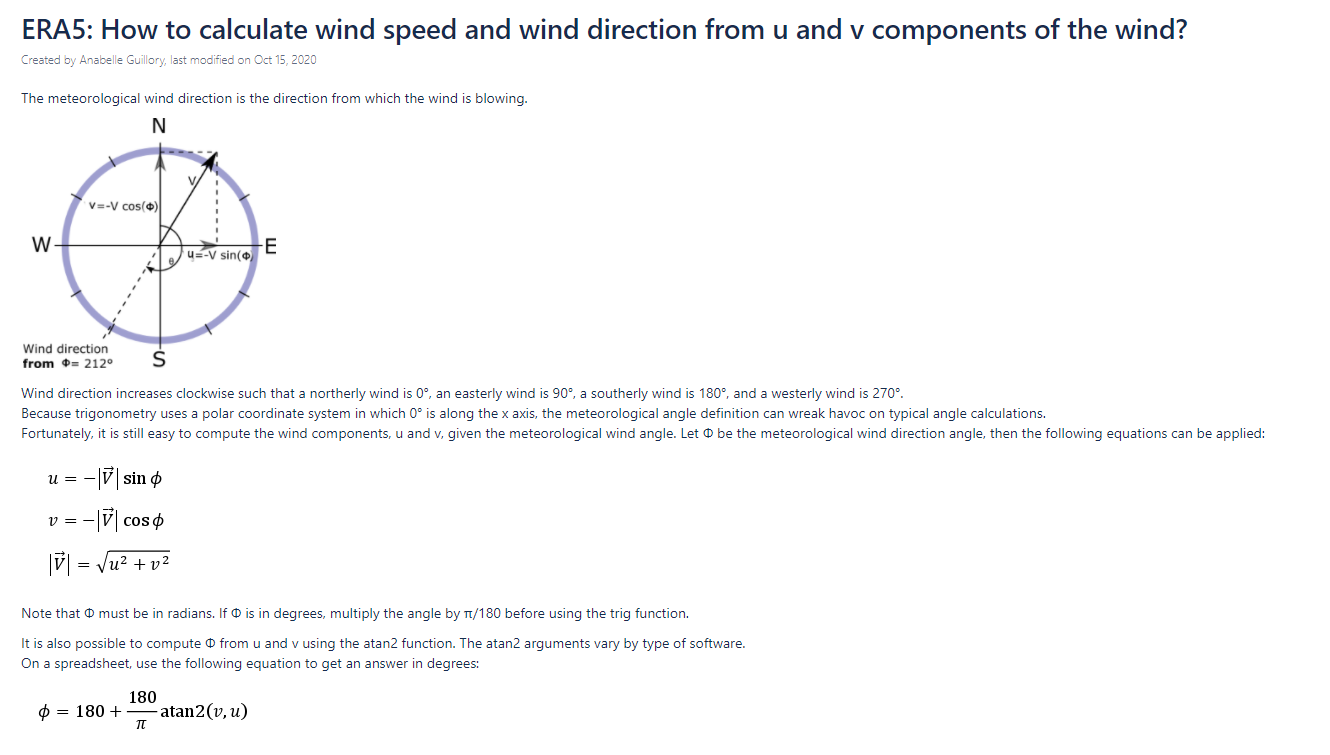


In [39]:
final_data['sat_wind_mag'] = np.sqrt(final_data['u_component_of_wind_10m'] * final_data['u_component_of_wind_10m'] + final_data['v_component_of_wind_10m'] * final_data['v_component_of_wind_10m'])
final_data['sat_wind_ang'] = 180 + (180 / np.pi ) * np.arctan2(final_data['v_component_of_wind_10m'], final_data['u_component_of_wind_10m'])

In [40]:
final_data.head()

,Ba_avg,Ba_min,Ba_max,Ba_std,Rt_avg,Rt_min,Rt_max,Rt_std,DCs_avg,DCs_min,DCs_max,DCs_std,Cm_avg,Cm_min,Cm_max,Cm_std,P_avg,P_min,P_max,P_std,Q_avg,Q_min,Q_max,Q_std,S_avg,S_min,S_max,S_std,Cosphi_avg,Cosphi_min,Cosphi_max,Cosphi_std,Ds_avg,Ds_min,Ds_max,Ds_std,Db1t_avg,Db1t_min,Db1t_max,Db1t_std,...,Va_min,Va_max,Va_std,Ot_avg,Ot_min,Ot_max,Ot_std,Nf_avg,Nf_min,Nf_max,Nf_std,Nu_avg,Nu_min,Nu_max,Nu_std,Rs_avg,Rs_min,Rs_max,Rs_std,Rbt_avg,Rbt_min,Rbt_max,Rbt_std,Rm_avg,Rm_min,Rm_max,Rm_std,Wa_c_avg,Na_c_avg,mean_2m_air_temperature,minimum_2m_air_temperature,maximum_2m_air_temperature,dewpoint_2m_temperature,total_percipitation,surface_pressure,mean_sea_level_pressure,u_component_of_wind_10m,v_component_of_wind_10m,sat_wind_mag,sat_wind_ang
Time,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2013-01-01 00:00:00+00:00,-0.9950,-1.007500,-0.865000,0.0250,14.5075,14.250,14.750,0.2100,1791.010025,1730.215000,1819.750025,17.557501,5599.269900,3590.850050,7851.810025,935.530017,1050.084998,653.737505,1481.530000,180.740000,64.270000,39.440001,85.622499,9.0775,1052.849997,657.525008,1483.135000,180.190000,0.9975,1.000,0.9925,0.0000,1791.707425,1730.959950,1820.500000,17.582500,38.550000,37.250000,40.000000,0.6900,...,-31.977500,33.625000,9.4050,6.3100,6.2000,6.3875,0.0350,50.009998,49.980000,50.020000,0.01,711.585023,710.135010,712.854997,0.5575,17.097500,16.490001,17.3975,0.1750,28.552500,28.4500,28.700001,0.0625,5586.714950,3572.39245,7828.024900,934.552490,193.165005,189.092500,274.024048,264.395508,284.745636,272.686951,0.066468,97616.953125,101610.601562,1.013305,0.784330,1.281390,217.740972
2013-02-01 00:00:00+00:00,-0.9850,-0.992500,-0.980000,0.0000,15.5000,15.500,15.590,0.0025,1685.725000,1461.170000,1810.749975,98.767502,3618.685050,2430.765000,5702.955100,722.607515,640.052505,358.442502,1077.450005,165.417495,37.895000,23.745000,60.032500,7.2450,641.555010,361.535005,1078.089997,164.867500,1.0000,1.000,0.9875,0.0000,1686.222500,1461.385000,1811.475000,98.912499,41.265000,40.437500,42.250001,0.3900,...,-46.472500,56.342500,11.6950,7.7175,7.6125,7.8500,0.0550,50.000000,49.970001,50.024999,0.01,705.490005,703.417510,707.557495,0.8825,16.087499,13.912500,17.3175,0.9500,29.175000,29.1500,29.262500,0.0100,3581.647525,2312.76000,5701.227525,749.144990,226.267500,230.525002,272.688873,263.343597,280.944031,270.536102,0.065178,97617.390625,101629.976562,-0.113801,-0.670381,0.679972,80.365587
2013-03-01 00:00:00+00:00,-0.8925,-1.005000,-0.225000,0.2150,11.4900,11.160,11.750,0.1300,980.287507,966.649993,1009.099997,12.002500,945.490000,596.367507,1144.520025,139.147500,67.702500,30.565000,90.615002,15.152500,18.470000,10.640000,21.697499,1.4875,70.377499,34.700000,92.590000,14.585000,0.9800,1.000,0.9400,0.0150,979.850005,966.225007,1008.667495,12.017500,39.807501,38.912501,40.887500,0.4775,...,-47.107501,50.675001,12.0575,1.5550,1.4875,1.6750,0.0525,49.990002,49.959999,50.029999,0.01,693.409987,692.009995,694.475005,0.5475,9.325000,9.182500,9.6125,0.1150,19.907500,19.8000,19.937500,0.0200,658.195007,301.45000,859.305007,141.252500,38.737499,37.077500,275.325439,264.332367,288.217285,271.392517,0.054084,96911.054688,100852.195312,-1.073613,-0.233716,1.098757,12.281201
2013-04-01 00:00:00+00:00,-0.9925,-0.997500,-0.992500,0.0000,11.0625,10.750,11.665,0.1500,1483.217475,1324.052475,1690.177450,79.945002,2708.400025,2076.537525,3823.097550,338.880005,407.795000,265.377500,669.822487,80.750000,33.467500,22.782500,42.167501,3.3425,409.367500,268.500000,670.429998,80.282498,0.9950,1.000,0.9875,0.0000,1483.362500,1323.959975,1690.625000,80.077500,43.795001,42.887500,44.600001,0.3375,...,-49.457500,42.547499,10.9900,-0.7975,-0.8875,-0.6625,0.0425,50.020000,50.000000,50.040001,0.01,704.707503,703.699997,705.770005,0.4075,14.140000,12.602500,16.1450,0.7675,24.672501,24.5625,24.750000,0.0700,2601.537525,1904.46995,3783.525000,369.480003,46.145000,48.877499,282.000275,270.315277,296.735596,276.658691,0.093293,97644.

In [41]:
final_data.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
Ba_avg,61.0,12.187459,18.668602,-0.997500,-0.992500,-0.475000,22.407500,67.495000
Ba_min,61.0,11.718060,18.590778,-1.007500,-0.995000,-0.992500,22.250000,67.495000
Ba_max,61.0,13.457773,18.550662,-0.997500,-0.992500,0.497500,22.417499,67.495000
Ba_std,61.0,0.494180,1.231963,0.000000,0.000000,0.000000,0.105000,5.557500
Rt_avg,61.0,19.082158,5.667885,9.905000,14.507500,18.865000,23.252500,31.792500
...,...,...,...,...,...,...,...,...
mean_sea_level_pressure,61.0,101714.882428,382.886813,100852.195312,101523.515625,101700.820312,101848.242188,103121.218750
u_component_of_wind_10m,61.0,0.762832,0.829584,-1.073613,0.151558,0.782490,1.398088,2.554615
v_component_of_wind_10m,61.0,0.575259,0.950131,-1.192518,-0.061343,0.323099,1.186275,3.131494
sat_wind_mag,61.0,1.292556,0.905792,0.019708,0.652907,1.098757,1.817216,3.460453


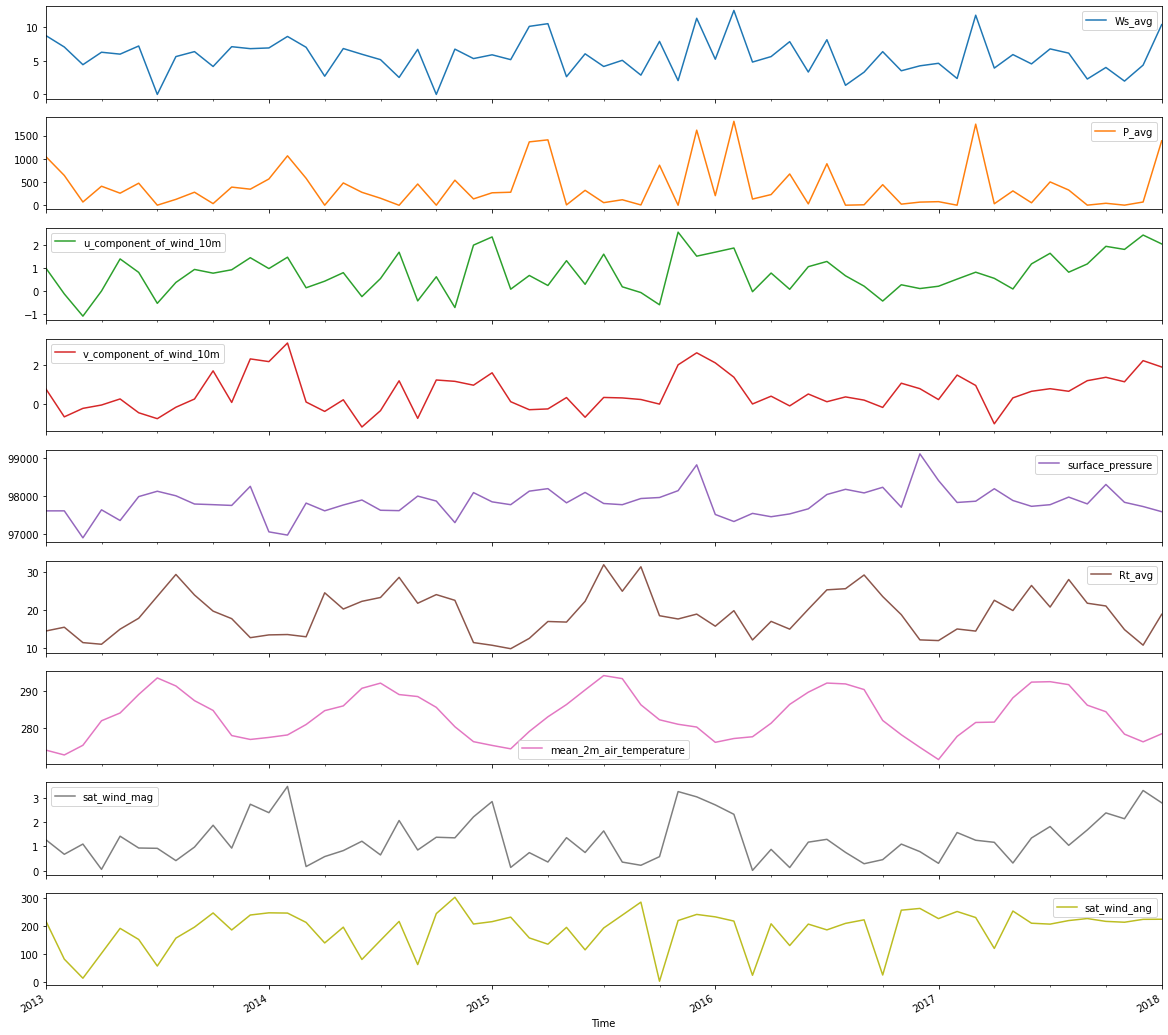

In [42]:
# Some Visualisations

plot_cols = ['Ws_avg', 'P_avg', 'u_component_of_wind_10m', 'v_component_of_wind_10m', 'surface_pressure' , 'Rt_avg', 'mean_2m_air_temperature', 'sat_wind_mag', 'sat_wind_ang' ]
plot_features = final_data[plot_cols]
plot_features.index = final_data.index
_ = plot_features.plot(subplots=True, figsize=(20, 20))


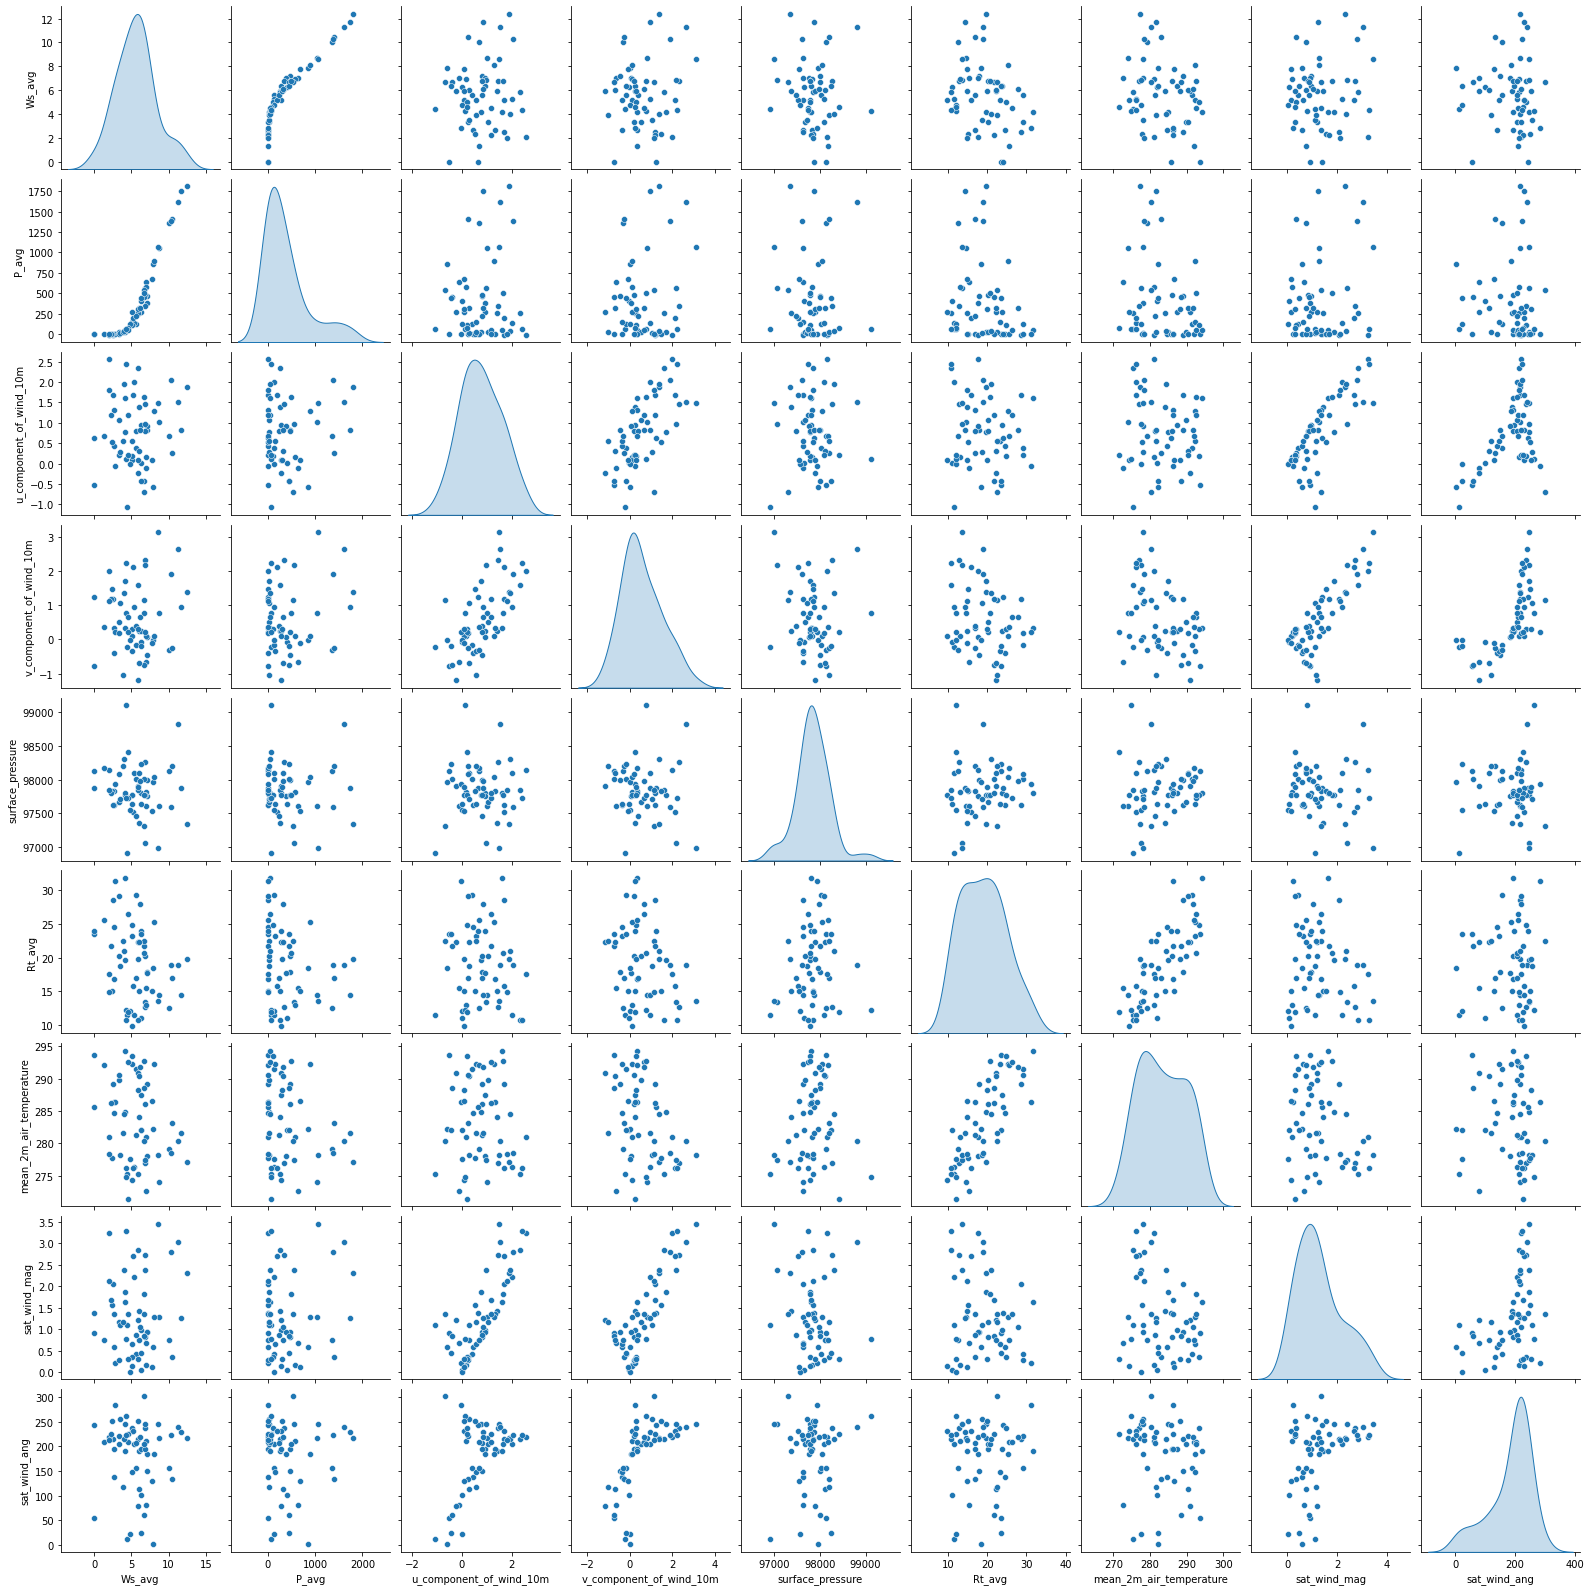

In [43]:
#quick linear regression
import seaborn as sns
sns.pairplot(final_data[['Ws_avg', 'P_avg', 'u_component_of_wind_10m', 'v_component_of_wind_10m', 'surface_pressure' , 'Rt_avg', 'mean_2m_air_temperature', 'sat_wind_mag', 'sat_wind_ang']], diag_kind='kde')

In [44]:
# select which col to conduct the linear regression on

def linearRegress(x_label, y_label):
  x = final_data.values #returns a numpy array
  min_max_scaler = preprocessing.MinMaxScaler()
  x_scaled = min_max_scaler.fit_transform(x)
  norm_df = pd.DataFrame(x_scaled, columns = final_data.keys() , index=final_data.index)
  norm_df.fillna(value=0, inplace=True)

  norm_df.head() #always normalise data
  
  y = norm_df.pop(y_label) #get desired y label
  y = y.values
  X = norm_df[x_label].values.reshape(-1, 1)

  reg = LinearRegression().fit(X,y)
  print(X.shape, y.shape)
  print(reg.coef_)
  print(reg.score(X, y))
  plt.scatter(X, y,color='g')
  plt.plot(X, reg.predict(X),color='k')
  plt.show()

Ba_avg
(61, 1) (61,)
[-0.49098045]
0.38413239203115274


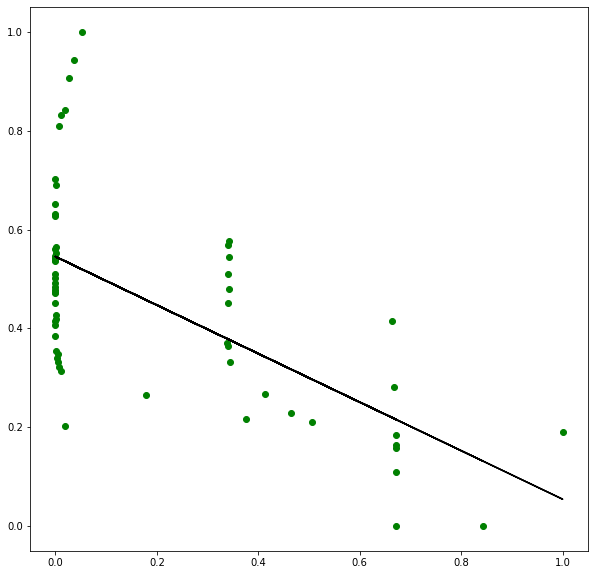

Ba_min
(61, 1) (61,)
[-0.499361]
0.3939367395507791


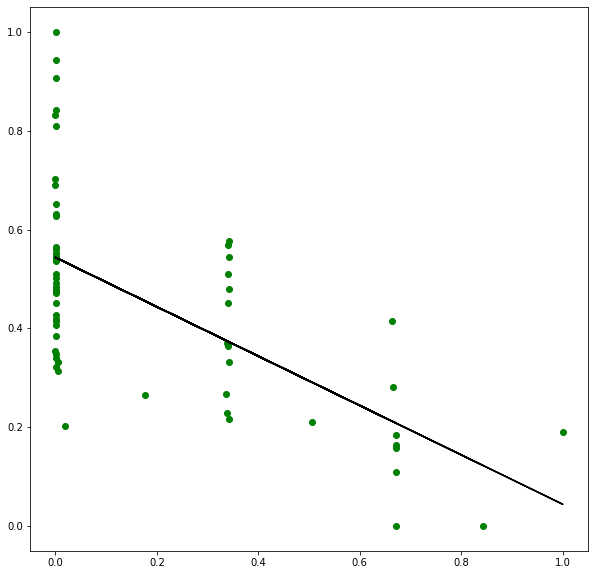

Ba_max
(61, 1) (61,)
[-0.43538719]
0.29826277433881787


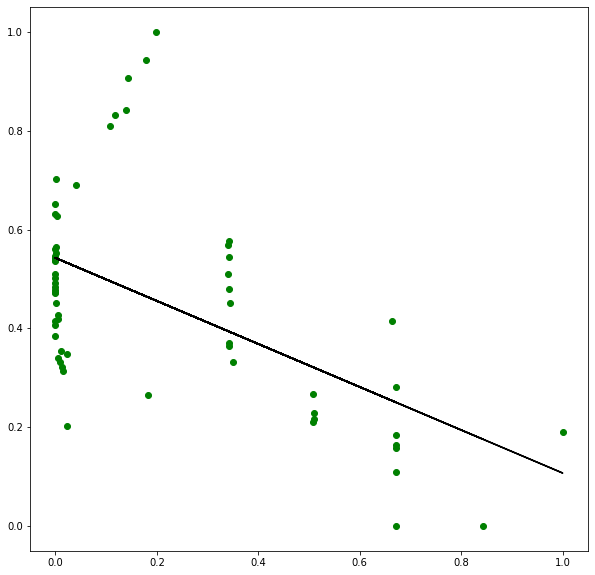

Ba_std
(61, 1) (61,)
[0.17140916]
0.030968423083902907


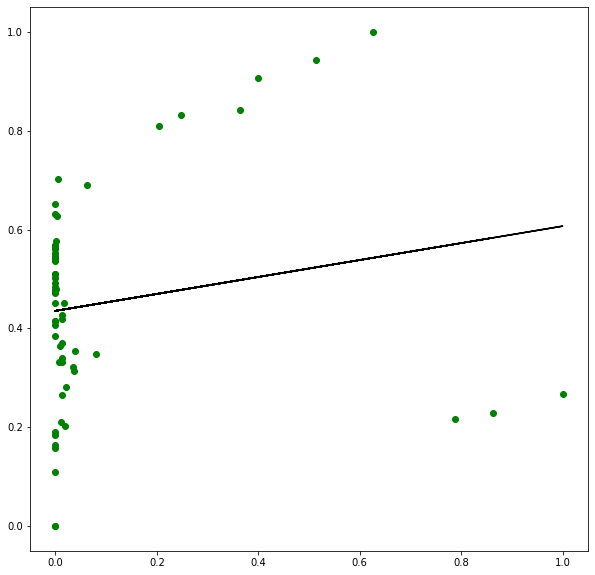

Rt_avg
(61, 1) (61,)
[-0.2292725]
0.07560815387287578


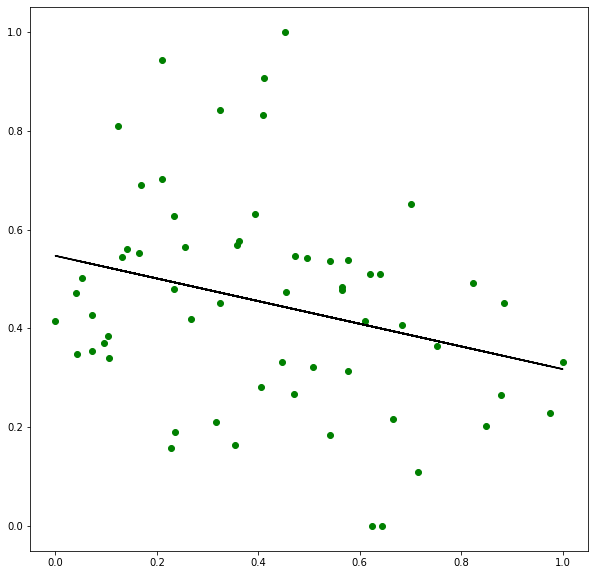

Rt_min
(61, 1) (61,)
[-0.22435312]
0.0722220173910374


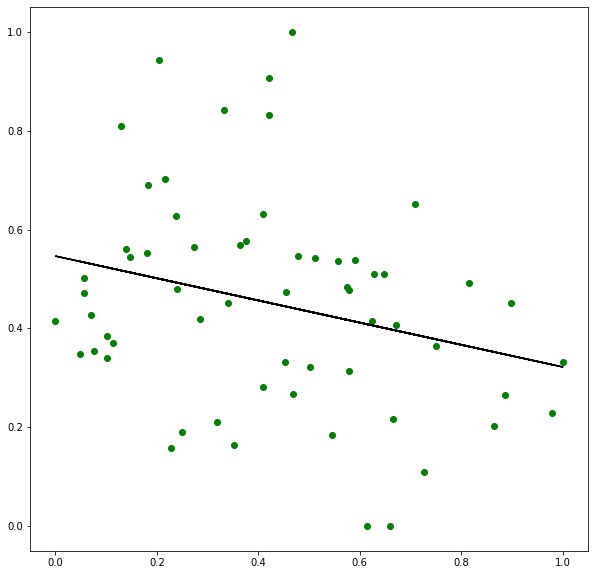

Rt_max
(61, 1) (61,)
[-0.23088997]
0.07673838431066049


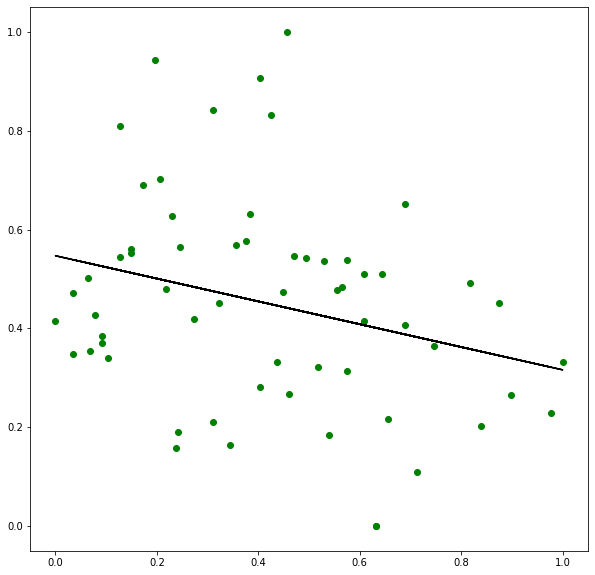

Rt_std
(61, 1) (61,)
[-0.07496757]
0.008735499699553784


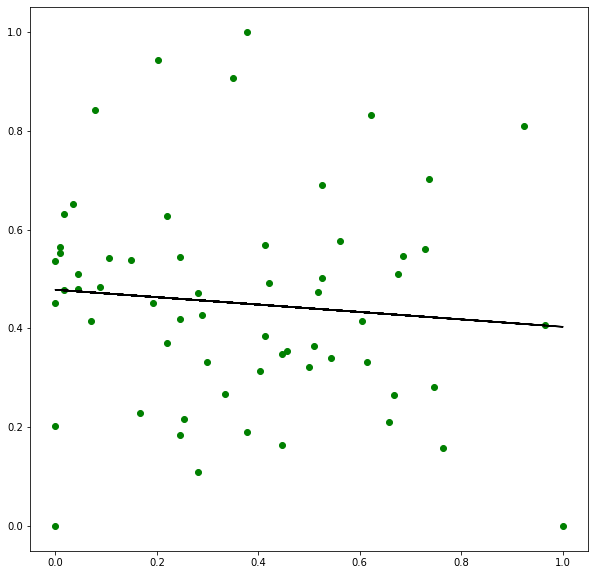

DCs_avg
(61, 1) (61,)
[0.62953612]
0.8087676940744579


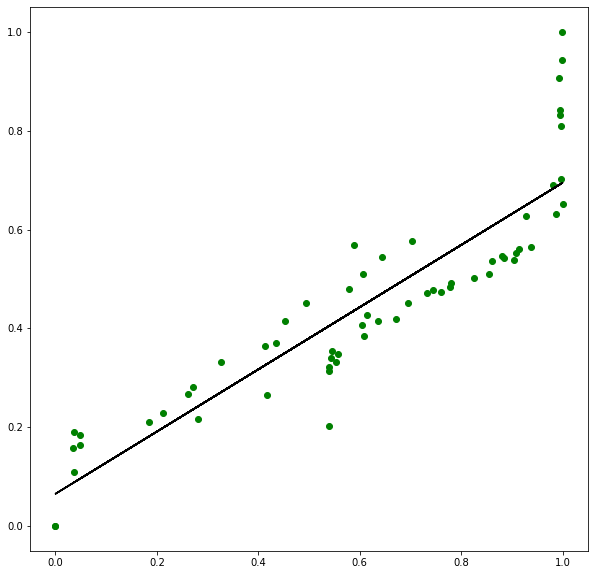

DCs_min
(61, 1) (61,)
[0.67103249]
0.8151281973538637


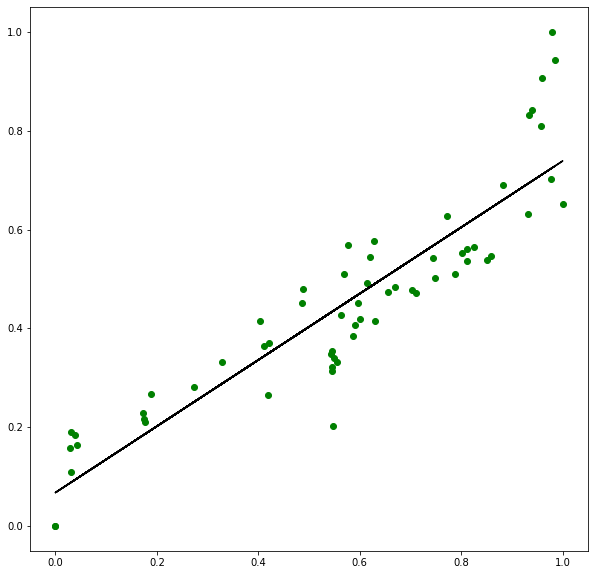

DCs_max
(61, 1) (61,)
[0.61566064]
0.7850309347020297


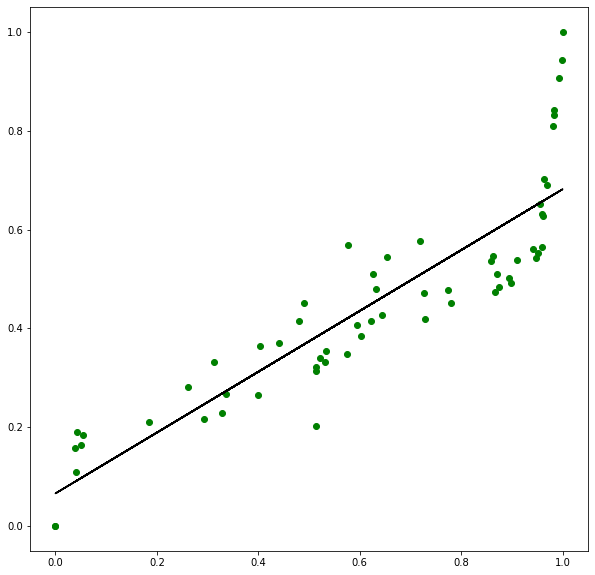

DCs_std
(61, 1) (61,)
[0.20705531]
0.047685830800767826


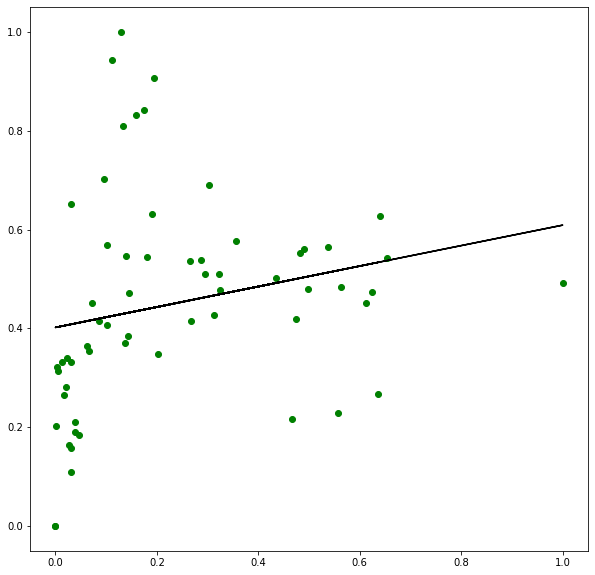

Cm_avg
(61, 1) (61,)
[0.83307683]
0.8722852189729998


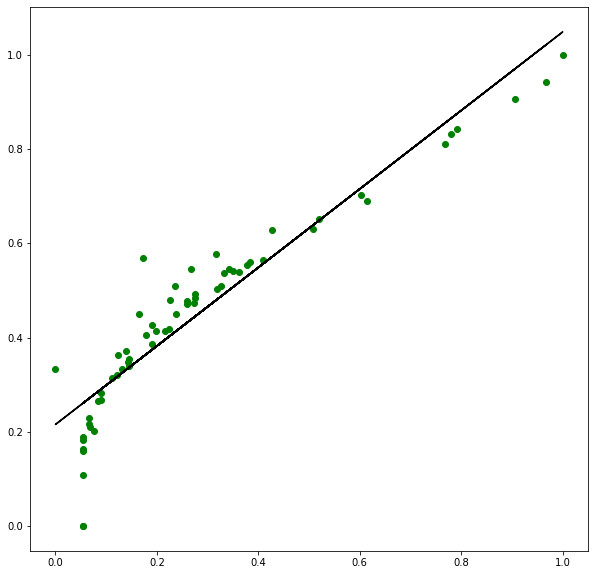

Cm_min
(61, 1) (61,)
[0.81797075]
0.8629783795724872


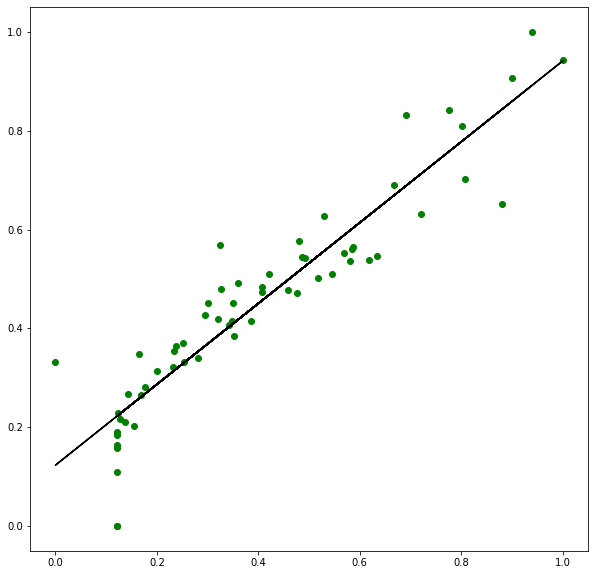

Cm_max
(61, 1) (61,)
[0.66484696]
0.8377676802766298


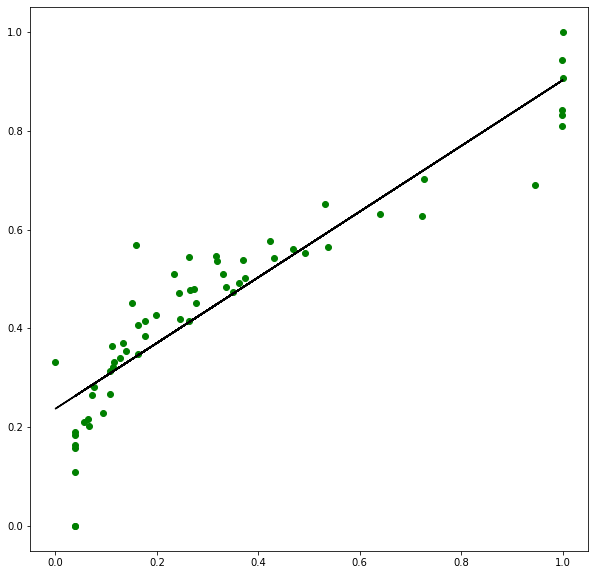

Cm_std
(61, 1) (61,)
[0.68449871]
0.6747636651088437


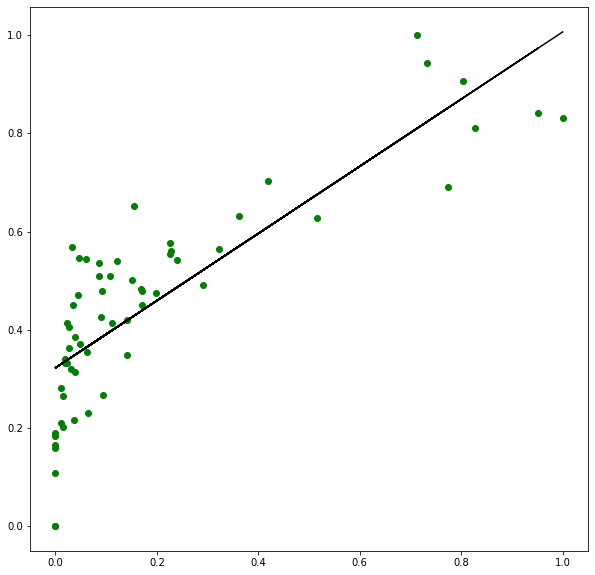

P_avg
(61, 1) (61,)
[0.75627205]
0.8451592413092768


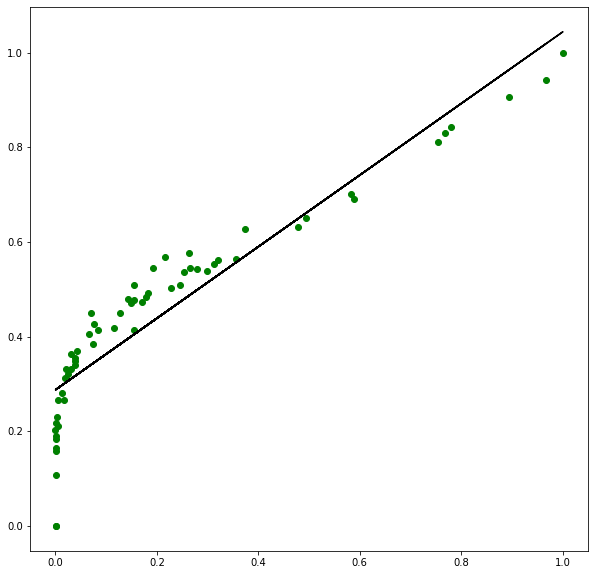

P_min
(61, 1) (61,)
[0.71986183]
0.8344462996065483


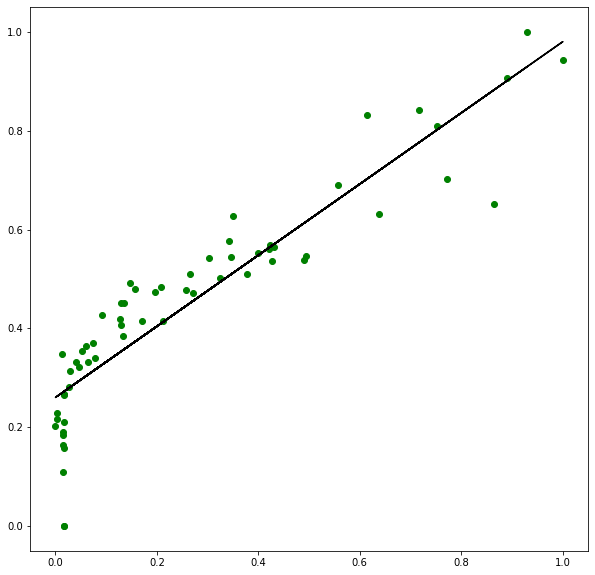

P_max
(61, 1) (61,)
[0.62583699]
0.8220759494135625


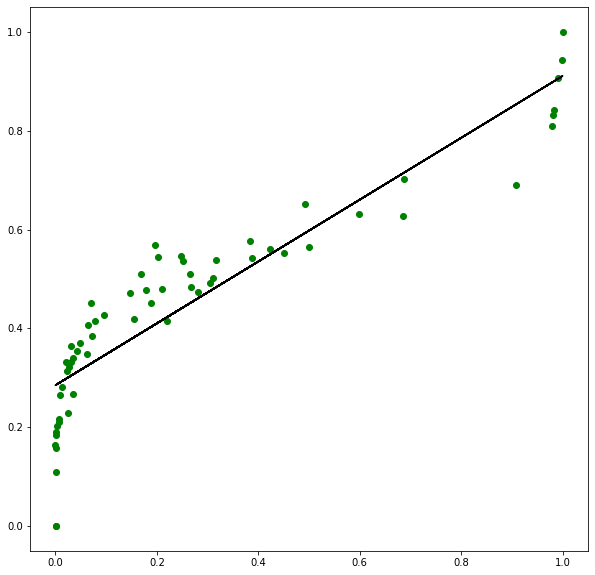

P_std
(61, 1) (61,)
[0.67631617]
0.6970250919252414


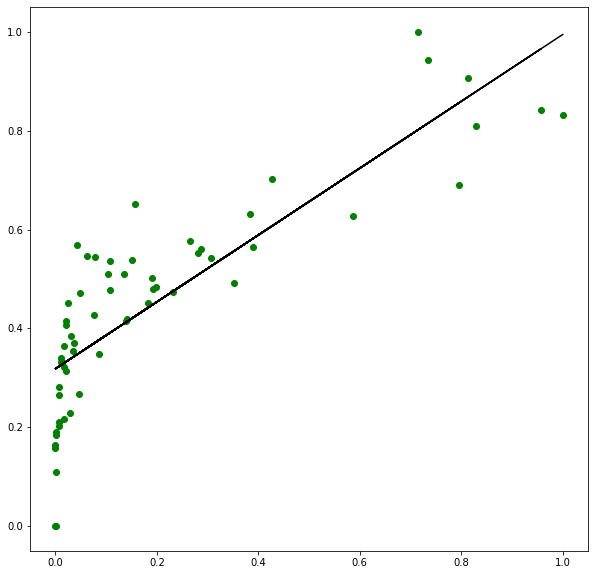

Q_avg
(61, 1) (61,)
[0.93861399]
0.8519507124980578


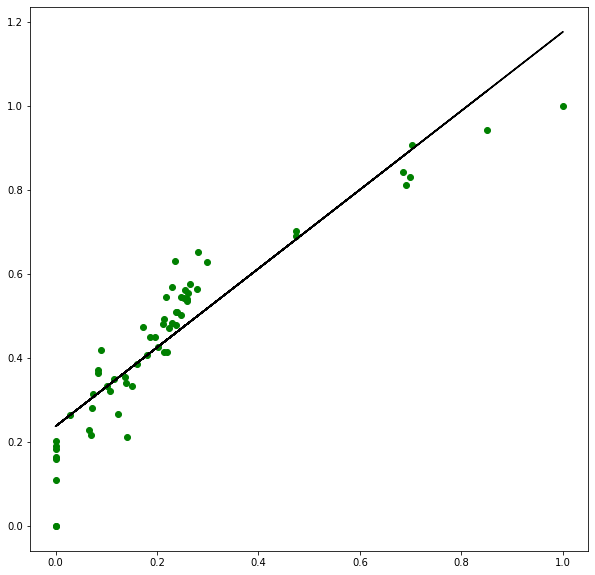

Q_min
(61, 1) (61,)
[1.14343191]
0.7608501681393296


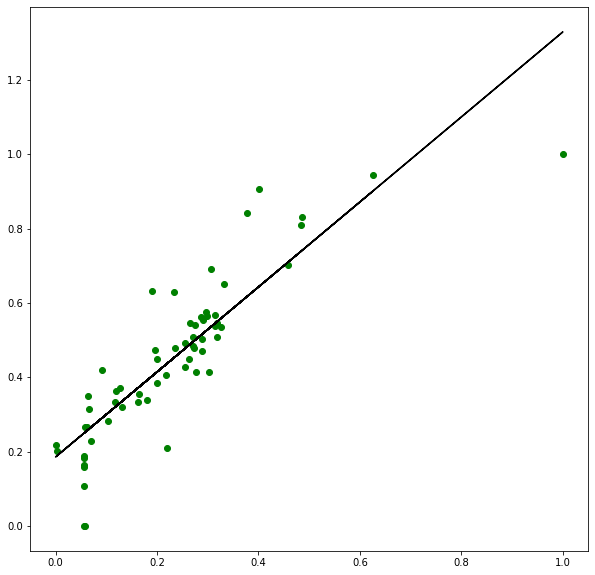

Q_max
(61, 1) (61,)
[0.79121428]
0.8112845369690035


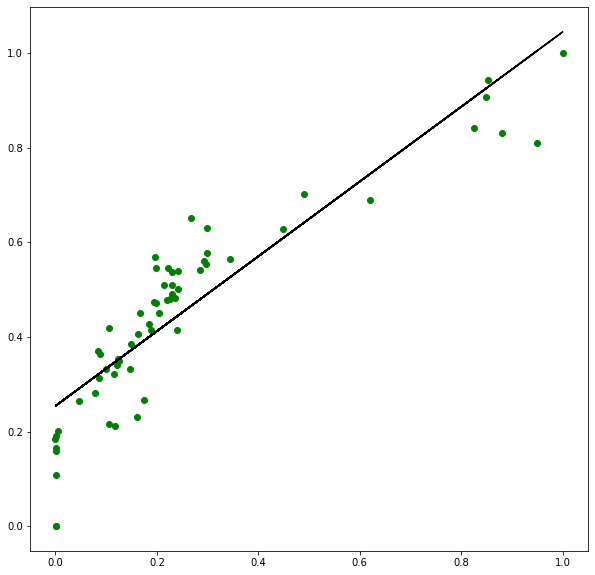

Q_std
(61, 1) (61,)
[0.65970279]
0.6077178658540145


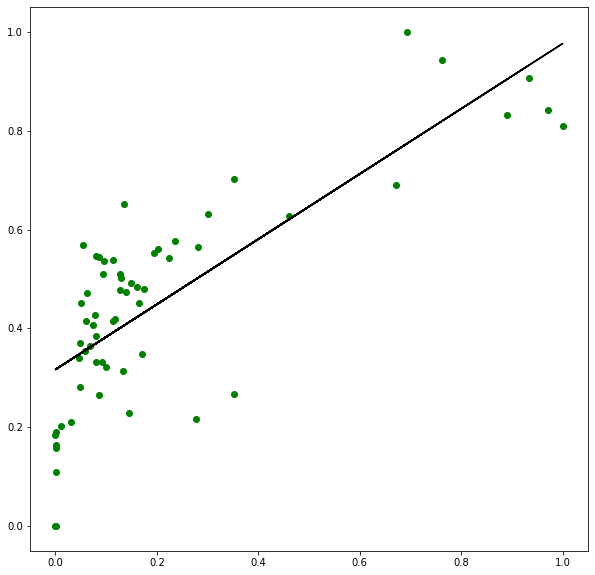

S_avg
(61, 1) (61,)
[0.75737808]
0.8445007952981752


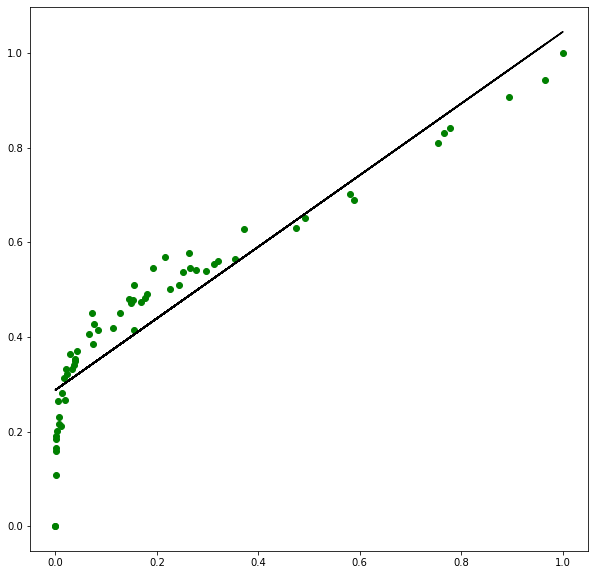

S_min
(61, 1) (61,)
[0.71670002]
0.83662221065042


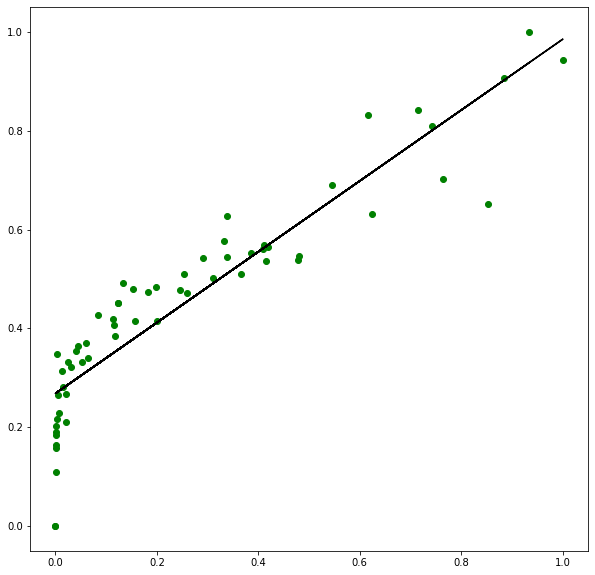

S_max
(61, 1) (61,)
[0.62705678]
0.8216529170615411


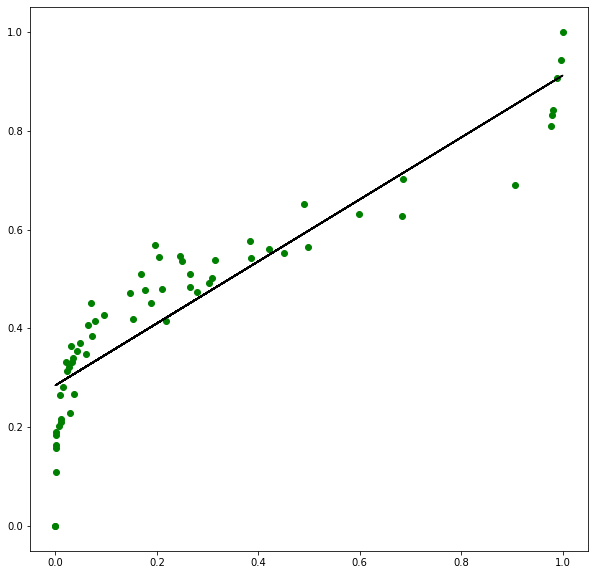

S_std
(61, 1) (61,)
[0.67447555]
0.697041930078337


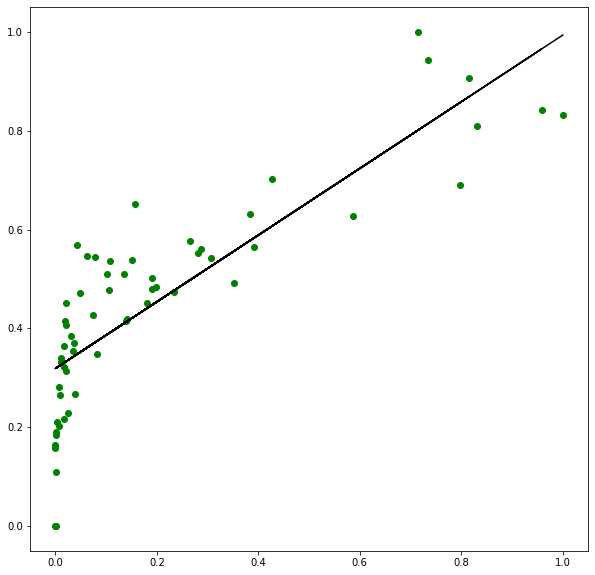

Cosphi_avg
(61, 1) (61,)
[0.2656669]
0.029525170425522496


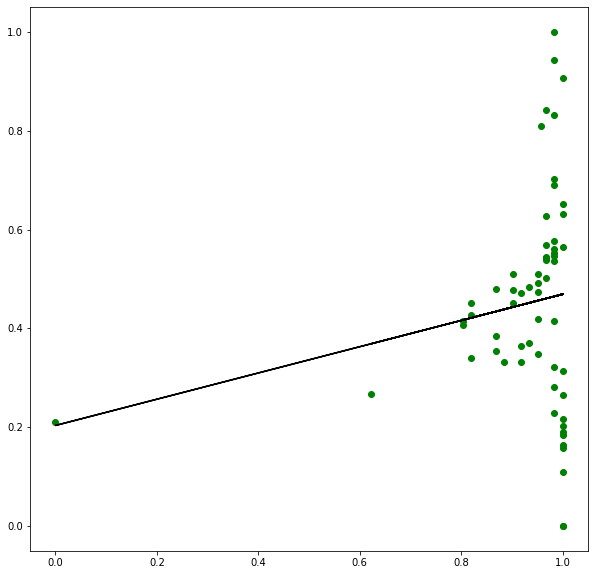

Cosphi_min
(61, 1) (61,)
[0.01212987]
0.0005585727021791831


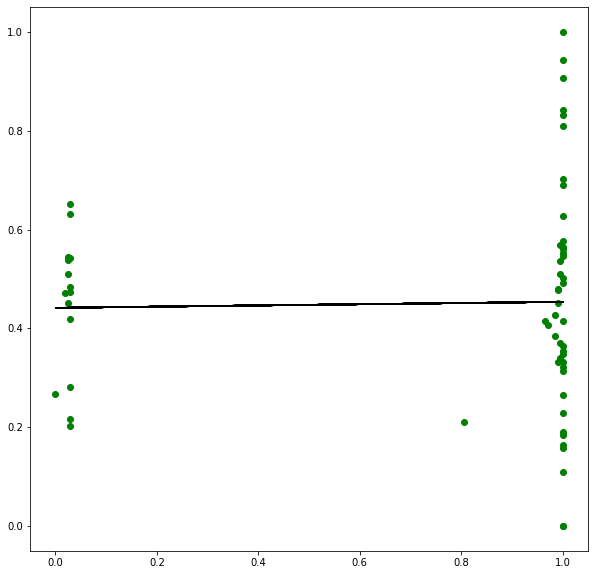

Cosphi_max
(61, 1) (61,)
[0.12476329]
0.007733178505752059


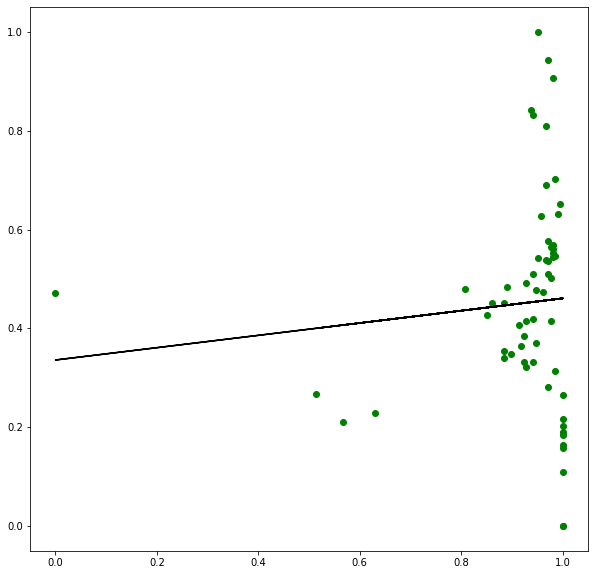

Cosphi_std
(61, 1) (61,)
[-0.27252948]
0.03618311532939966


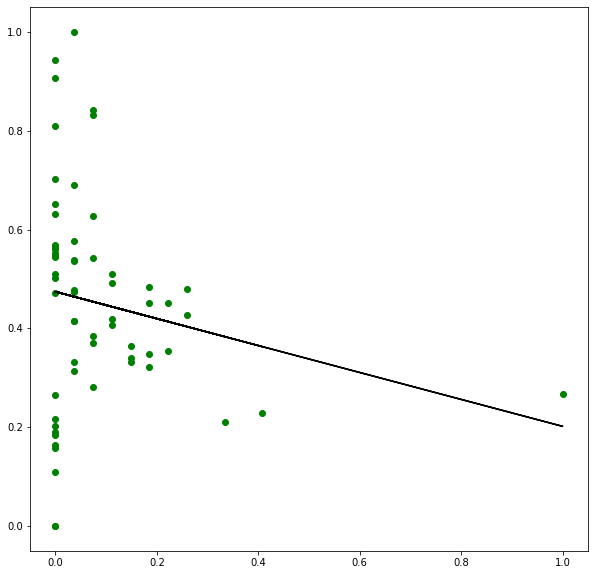

Ds_avg
(61, 1) (61,)
[0.63407685]
0.8140099127249092


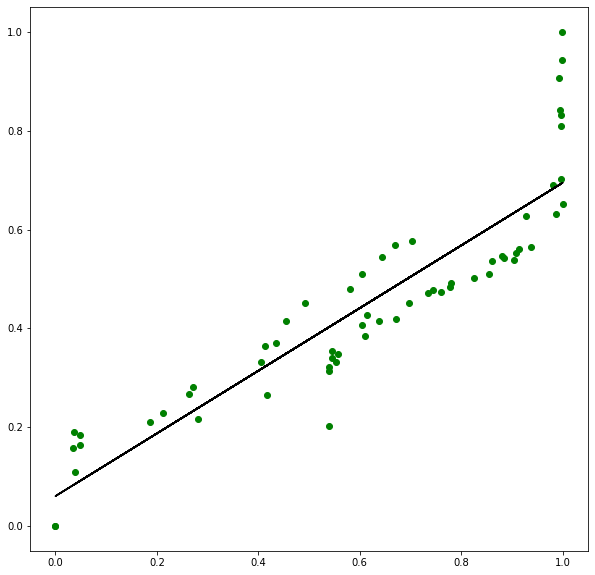

Ds_min
(61, 1) (61,)
[0.67467528]
0.819035855992164


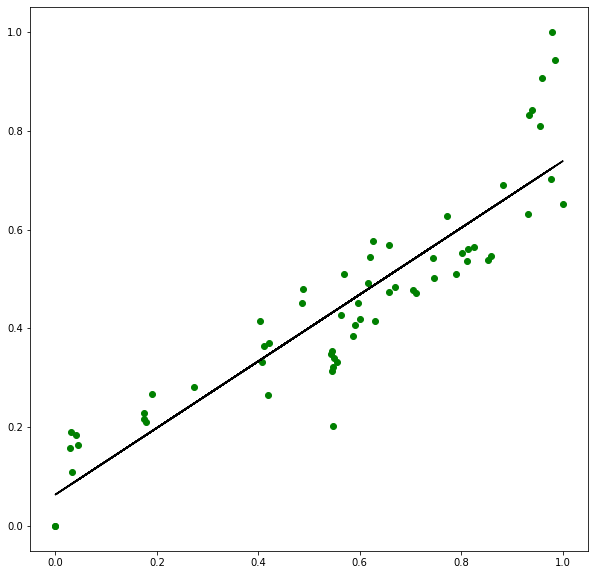

Ds_max
(61, 1) (61,)
[0.62091815]
0.7911056643783724


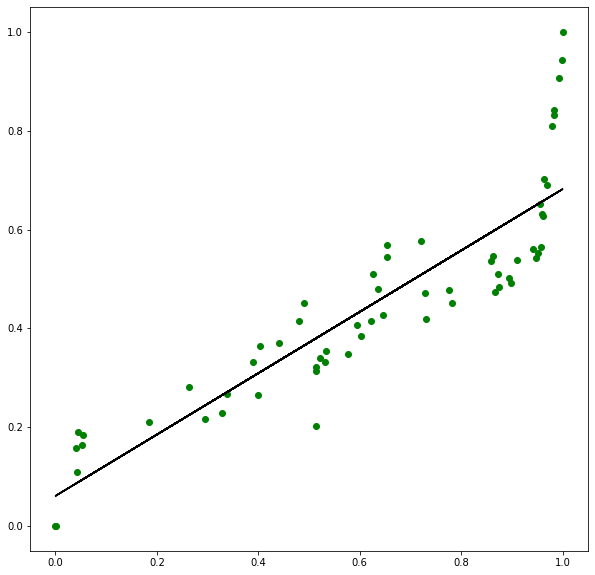

Ds_std
(61, 1) (61,)
[0.20657342]
0.04756799226953368


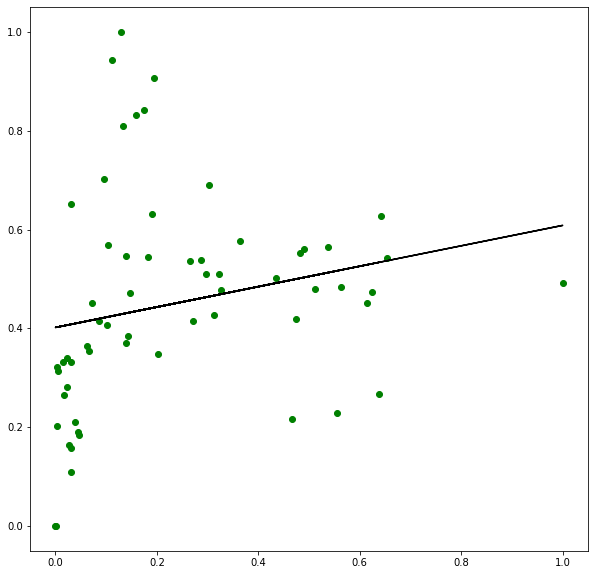

Db1t_avg
(61, 1) (61,)
[-0.0900546]
0.010337594656738003


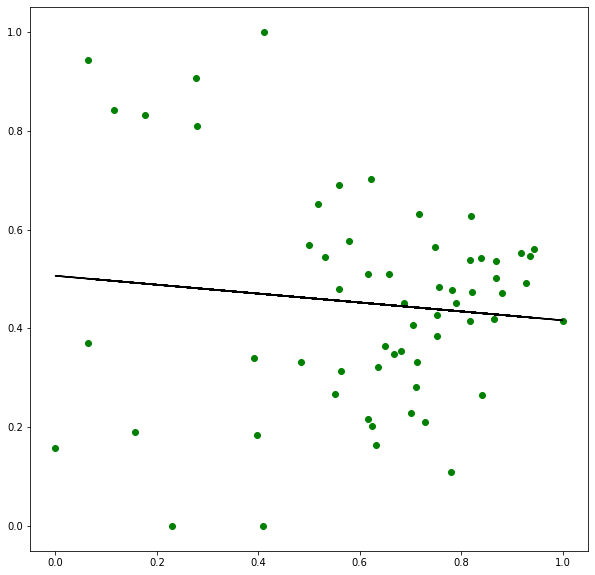

Db1t_min
(61, 1) (61,)
[-0.11799138]
0.017810440810415384


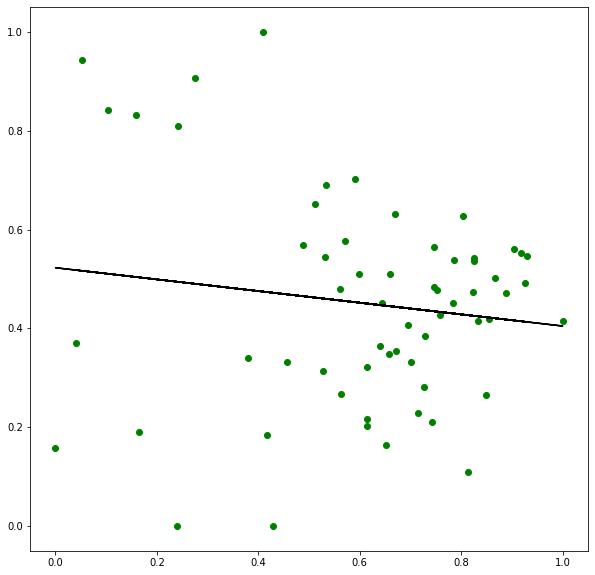

Db1t_max
(61, 1) (61,)
[-0.06298042]
0.005087323880731298


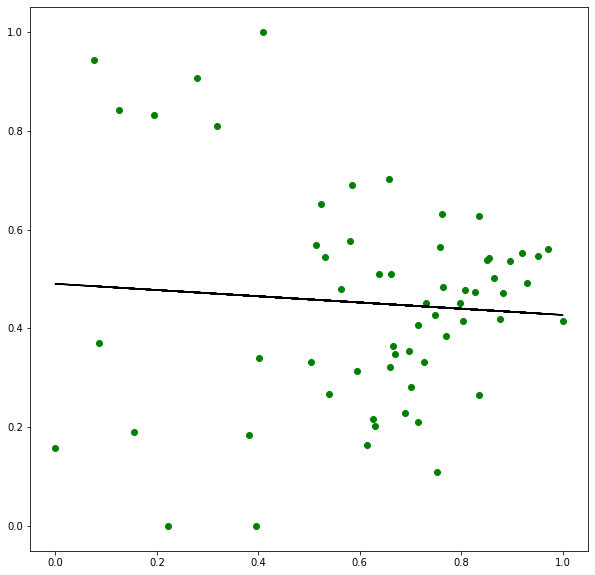

Db1t_std
(61, 1) (61,)
[0.23203741]
0.0722736149115587


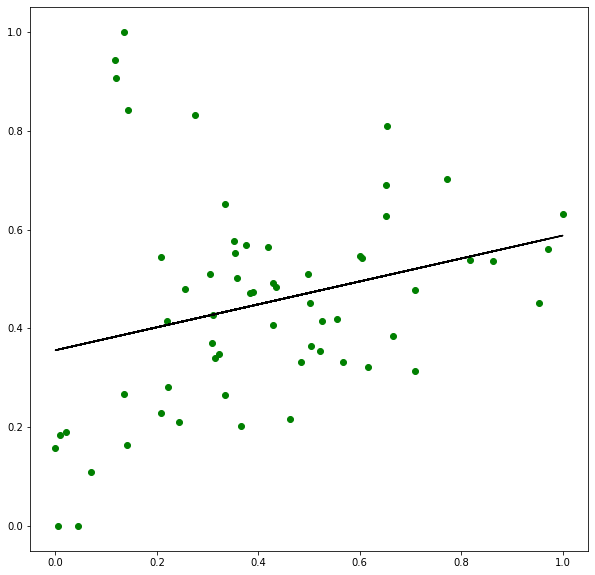

Db2t_avg
(61, 1) (61,)
[-0.04118416]
0.0017759837590353156


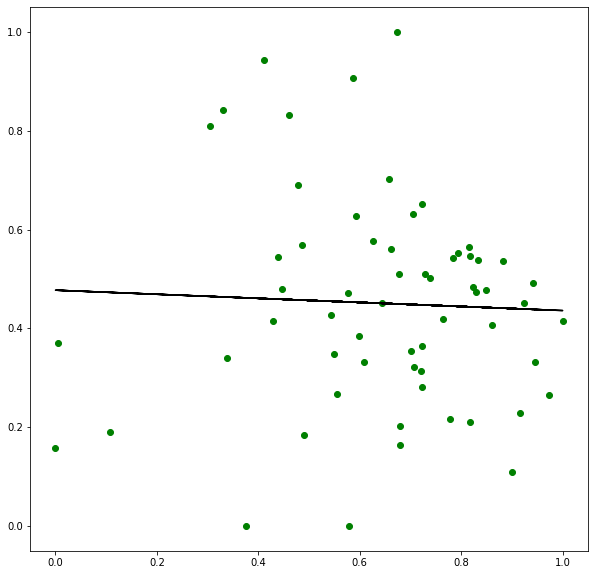

Db2t_min
(61, 1) (61,)
[-0.04776386]
0.0023851237257505042


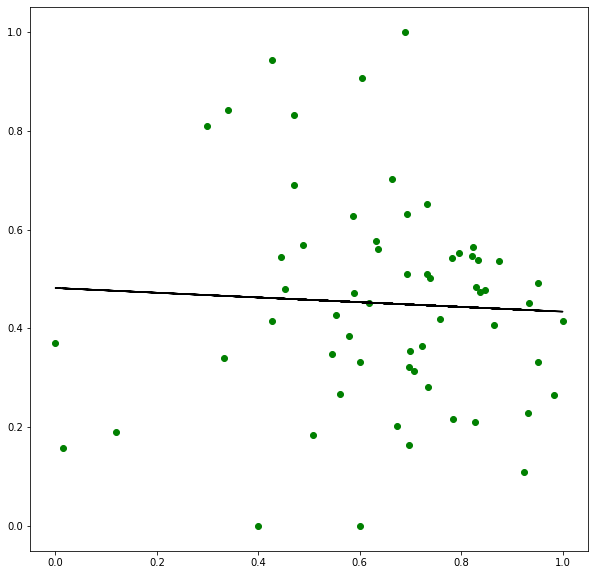

Db2t_max
(61, 1) (61,)
[-0.03376942]
0.0011701775835607497


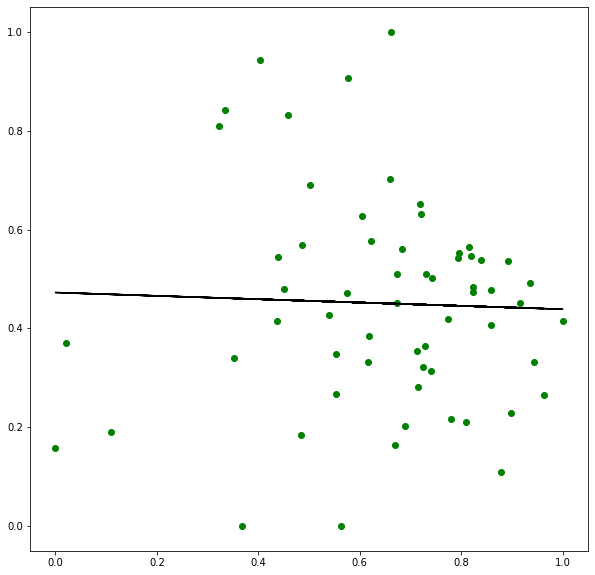

Db2t_std
(61, 1) (61,)
[0.06616627]
0.004861092551436408


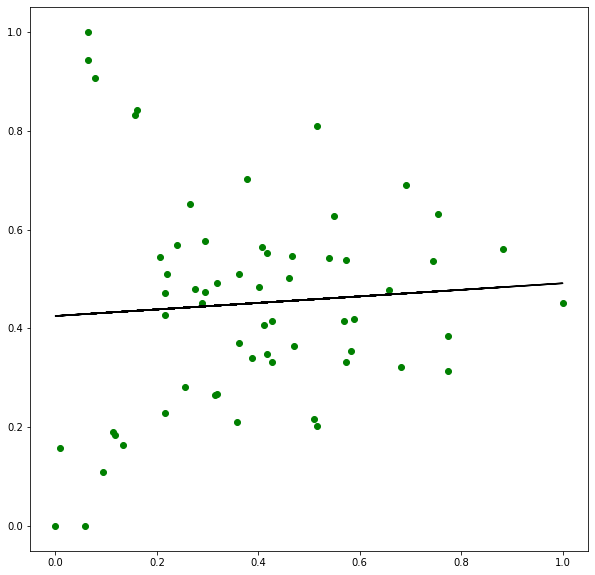

Dst_avg
(61, 1) (61,)
[0.73556055]
0.38950698758974955


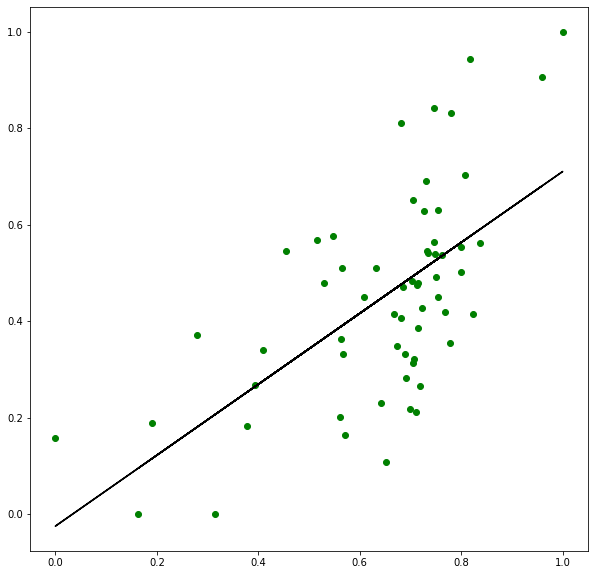

Dst_min
(61, 1) (61,)
[0.73451011]
0.37655217695404575


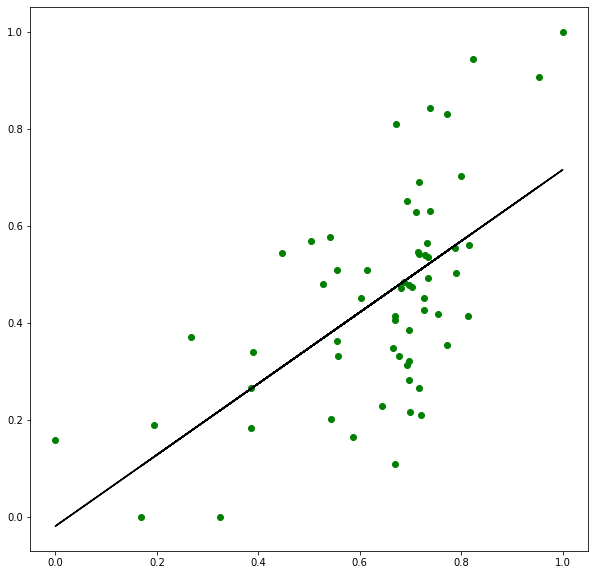

Dst_max
(61, 1) (61,)
[0.73718758]
0.4031602530314732


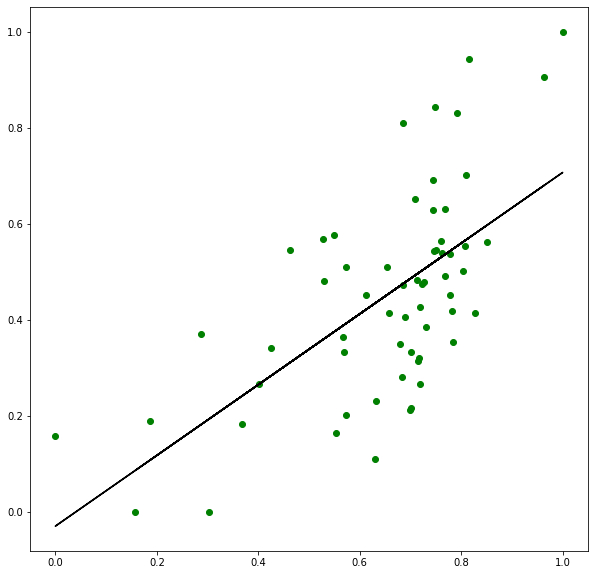

Dst_std
(61, 1) (61,)
[0.54622468]
0.3313516752973179


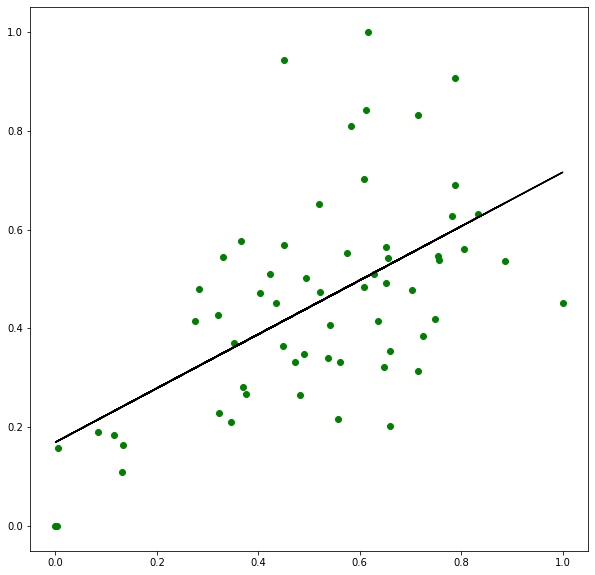

Gb1t_avg
(61, 1) (61,)
[0.70452104]
0.6324809252460197


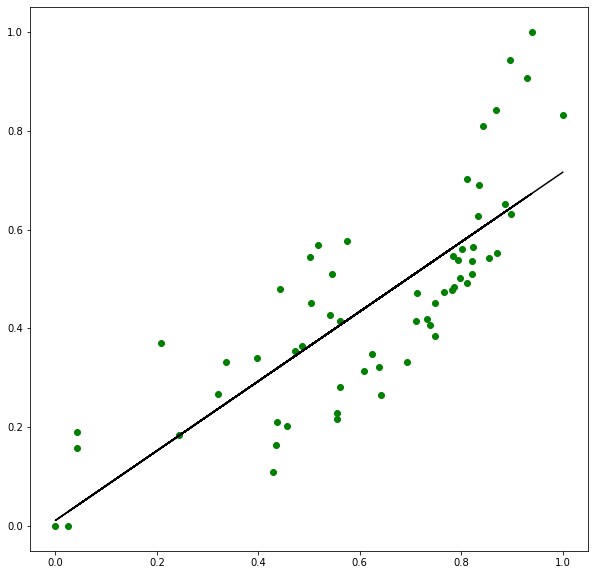

Gb1t_min
(61, 1) (61,)
[0.70077394]
0.6224168516882358


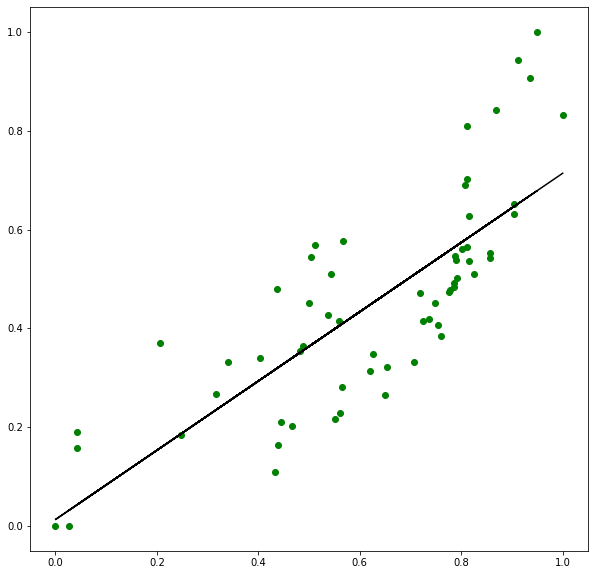

Gb1t_max
(61, 1) (61,)
[0.70462253]
0.6379405342913954


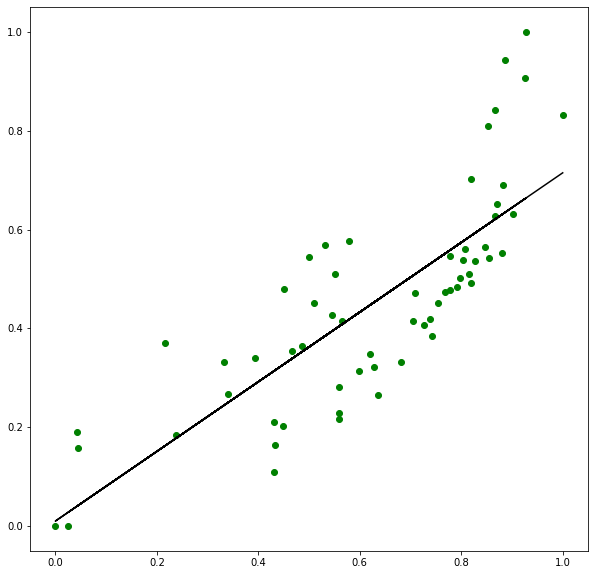

Gb1t_std
(61, 1) (61,)
[0.55751383]
0.2371530051178794


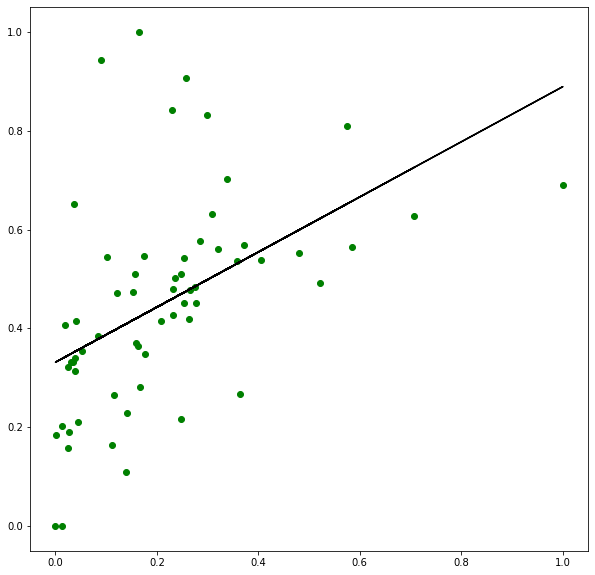

Gb2t_avg
(61, 1) (61,)
[0.61411784]
0.6384829245931389


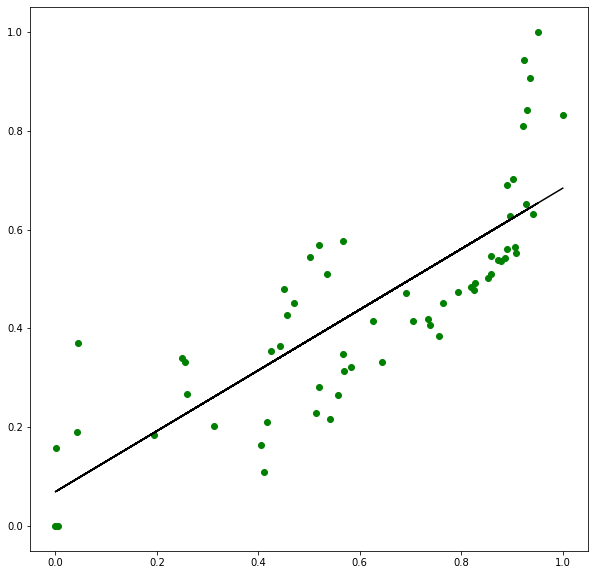

Gb2t_min
(61, 1) (61,)
[0.62046556]
0.6419068802497341


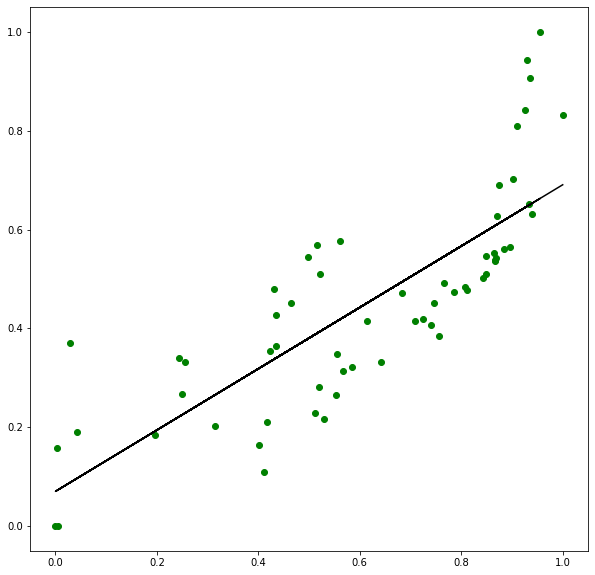

Gb2t_max
(61, 1) (61,)
[0.61030868]
0.6371699756257918


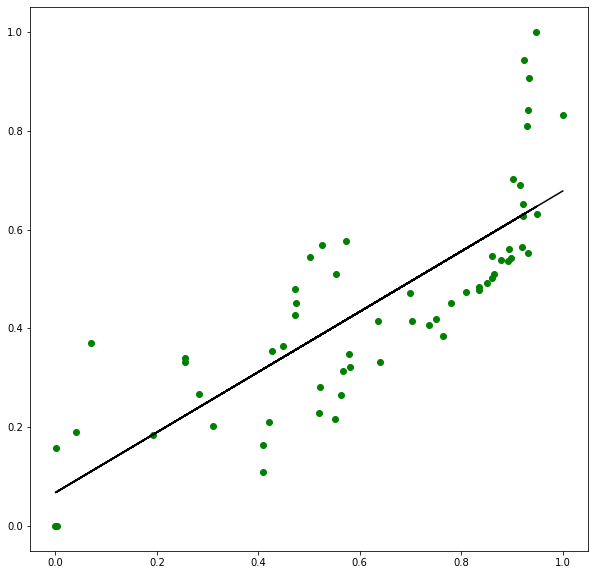

Gb2t_std
(61, 1) (61,)
[0.24945936]
0.05301004202923176


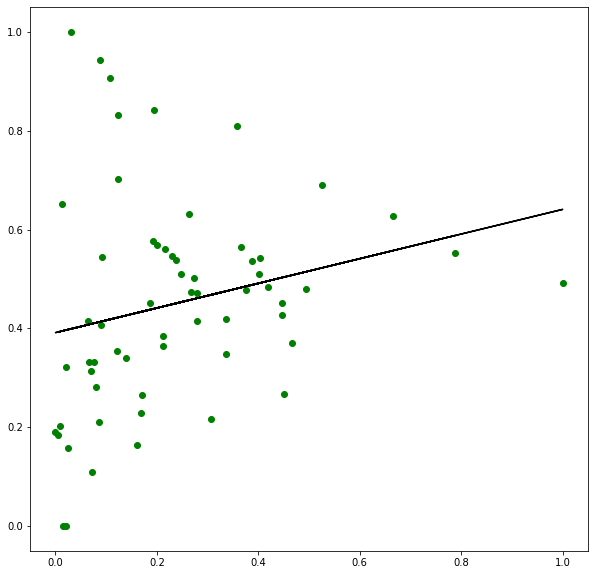

Git_avg
(61, 1) (61,)
[0.31376994]
0.11624476183575394


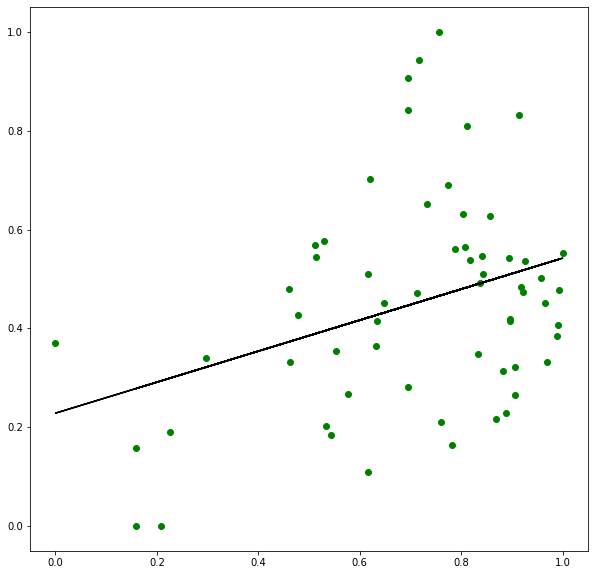

Git_min
(61, 1) (61,)
[0.24245268]
0.07361886422124575


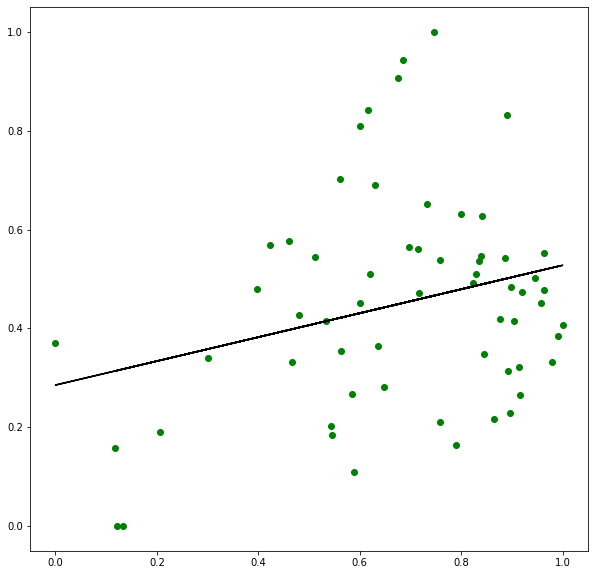

Git_max
(61, 1) (61,)
[0.35863648]
0.14449566878289055


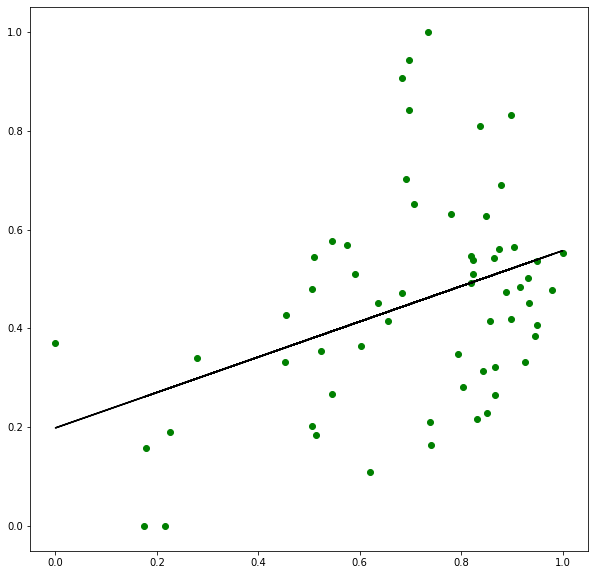

Git_std
(61, 1) (61,)
[0.2696605]
0.07558531230686183


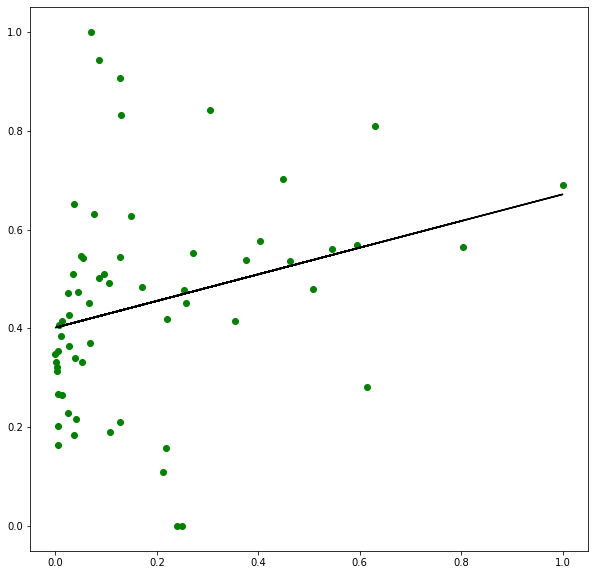

Gost_avg
(61, 1) (61,)
[0.47076381]
0.24768330997499532


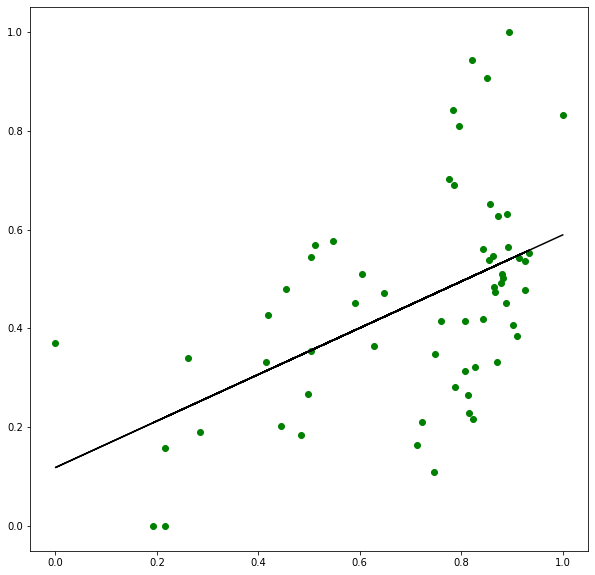

Gost_min
(61, 1) (61,)
[0.45644214]
0.2315728114983667


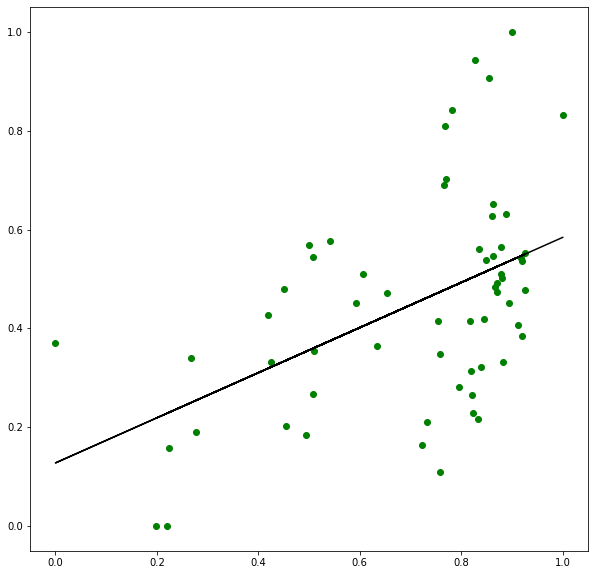

Gost_max
(61, 1) (61,)
[0.48150351]
0.2641456629378389


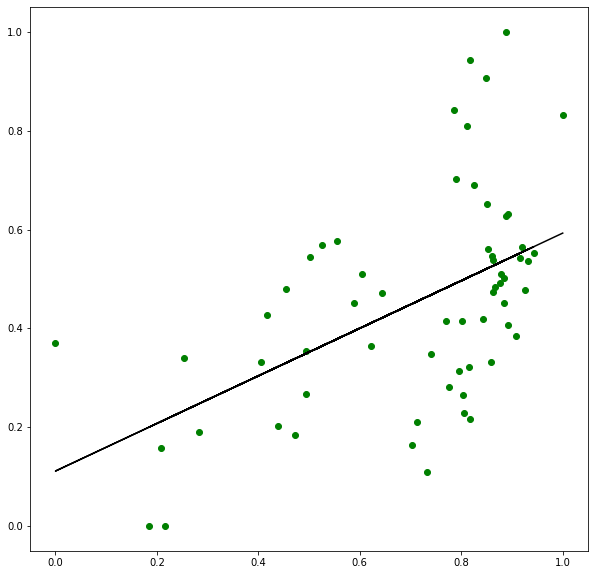

Gost_std
(61, 1) (61,)
[0.50951501]
0.20453662104782763


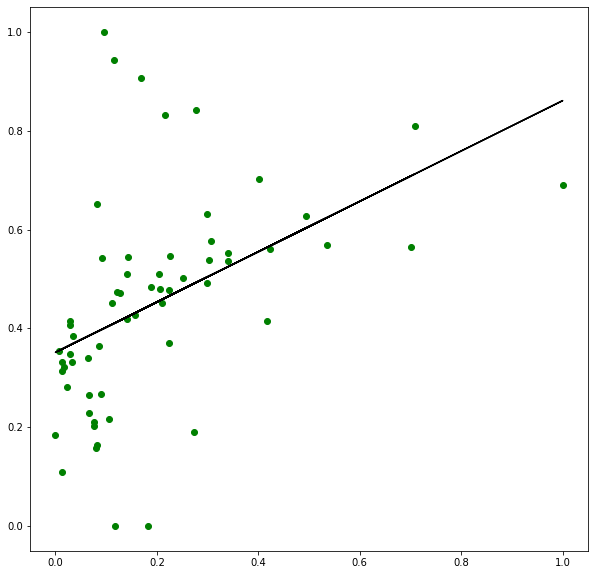

Ya_avg
(61, 1) (61,)
[0.17156619]
0.053544479757099195


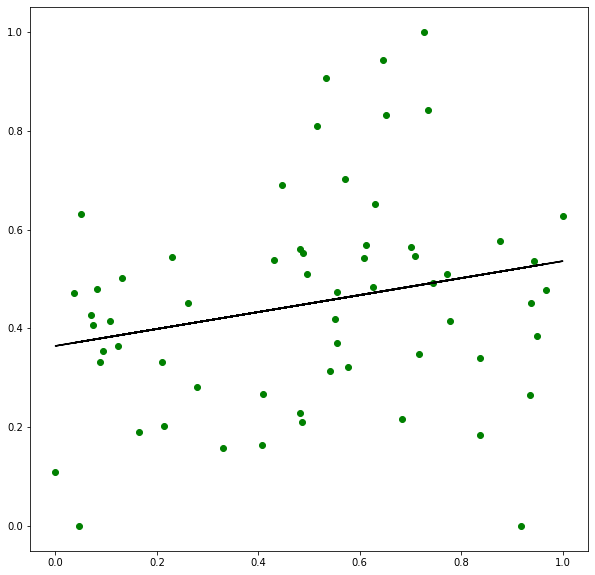

Ya_min
(61, 1) (61,)
[0.17548971]
0.056860615960604106


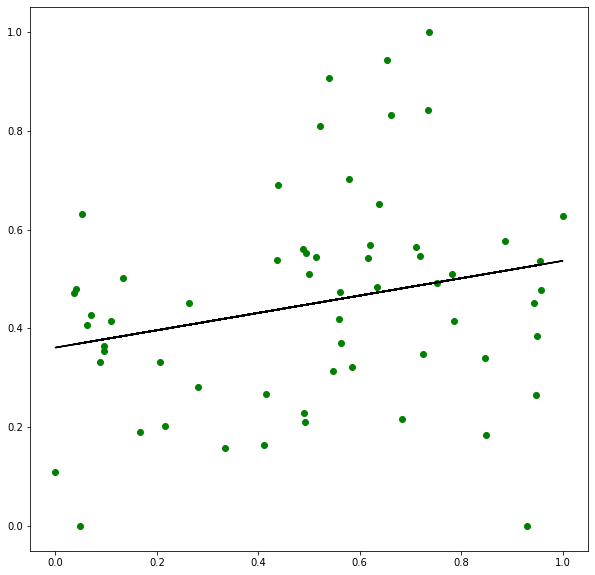

Ya_max
(61, 1) (61,)
[0.17396911]
0.05348282889945898


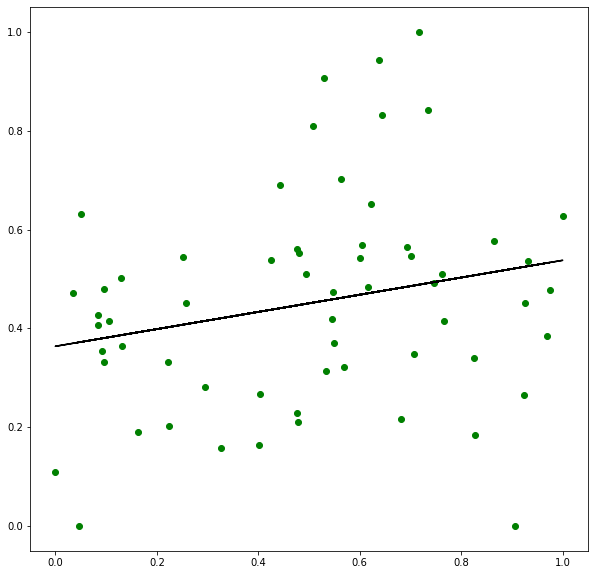

Ya_std
(61, 1) (61,)
[0.01464065]
0.0003182364433927942


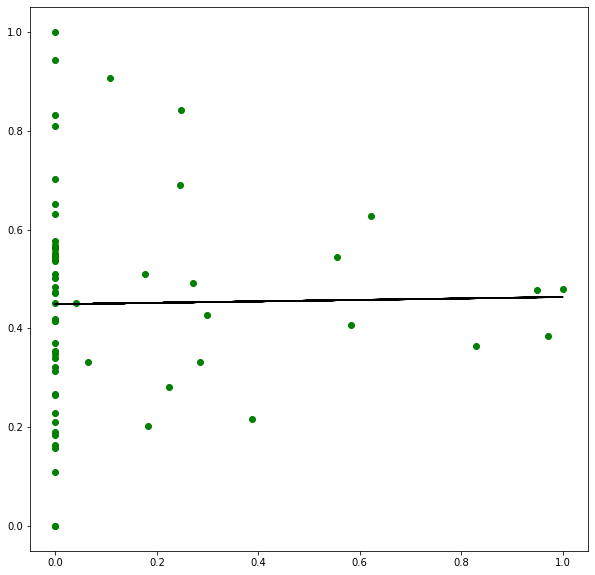

Yt_avg
(61, 1) (61,)
[-0.59963136]
0.355094972439845


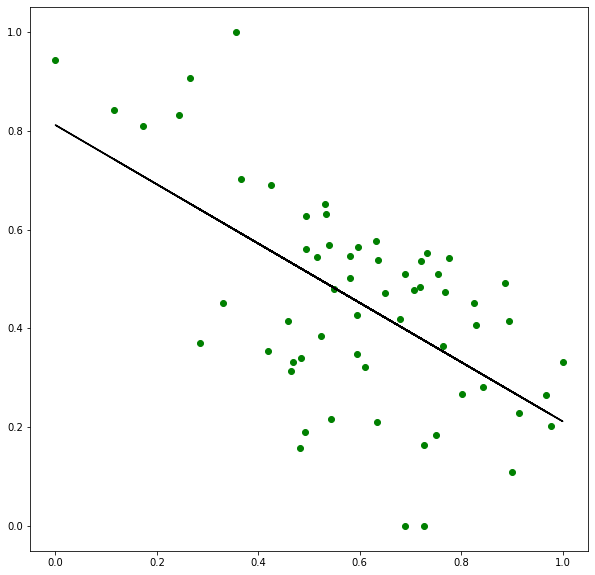

Yt_min
(61, 1) (61,)
[-0.59563682]
0.3836085894474359


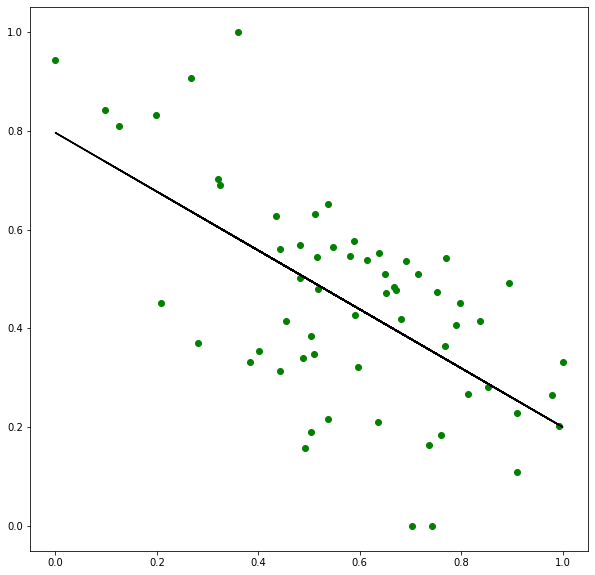

Yt_max
(61, 1) (61,)
[-0.57716965]
0.31353715022358286


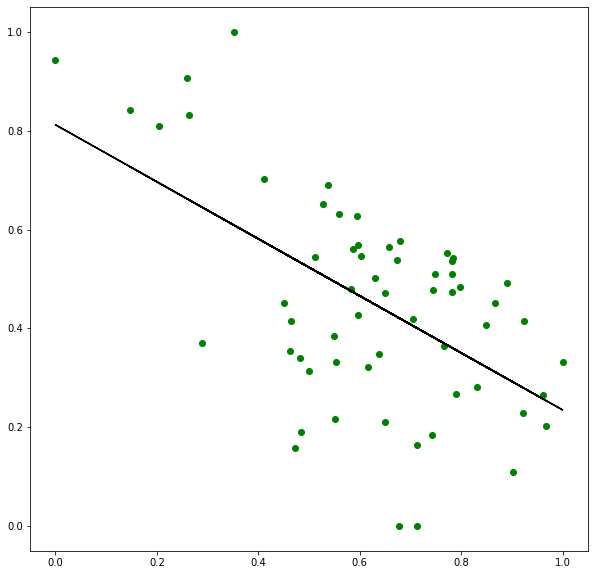

Yt_std
(61, 1) (61,)
[0.25282332]
0.0709206360292185


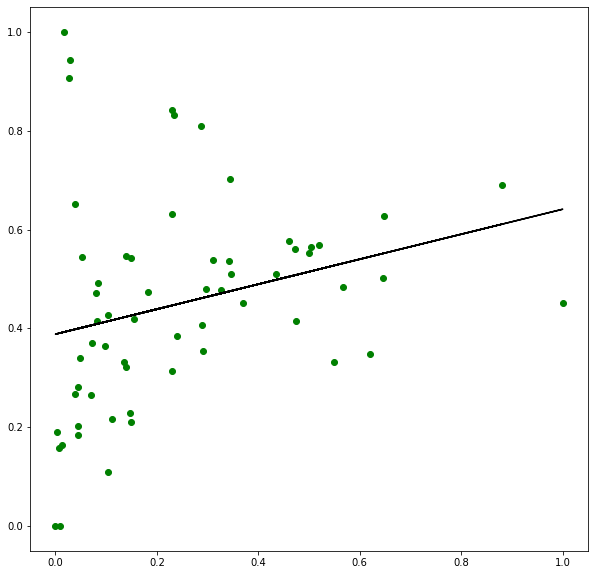

Ws1_avg
(61, 1) (61,)
[0.99042198]
0.9918433232069018


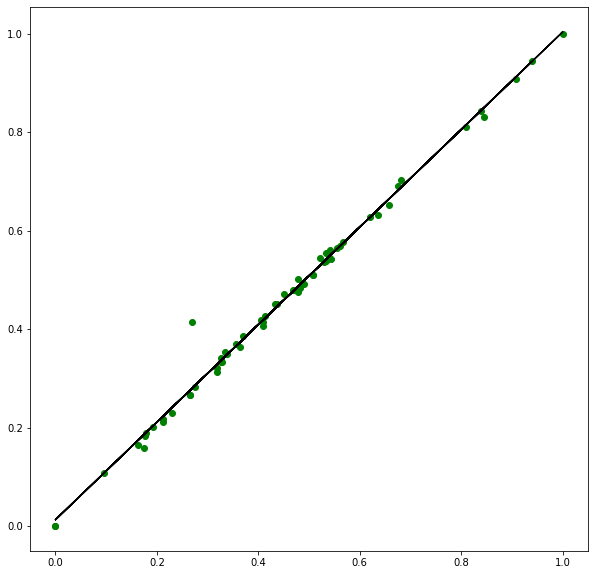

Ws1_min
(61, 1) (61,)
[0.84642173]
0.8915057021528644


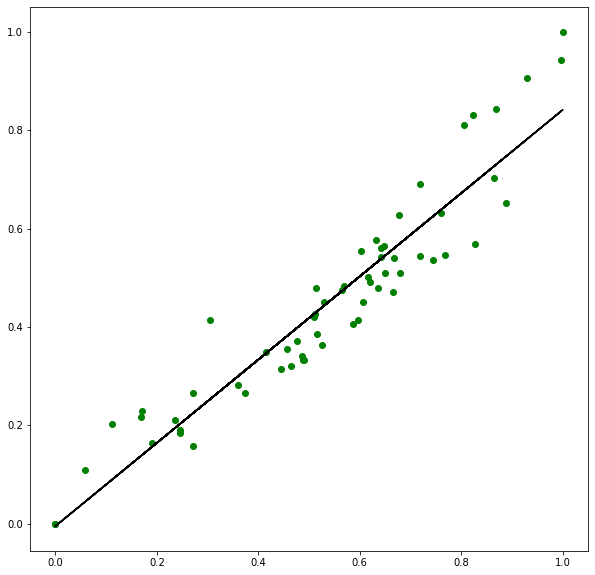

Ws1_max
(61, 1) (61,)
[0.9540895]
0.9697640382364018


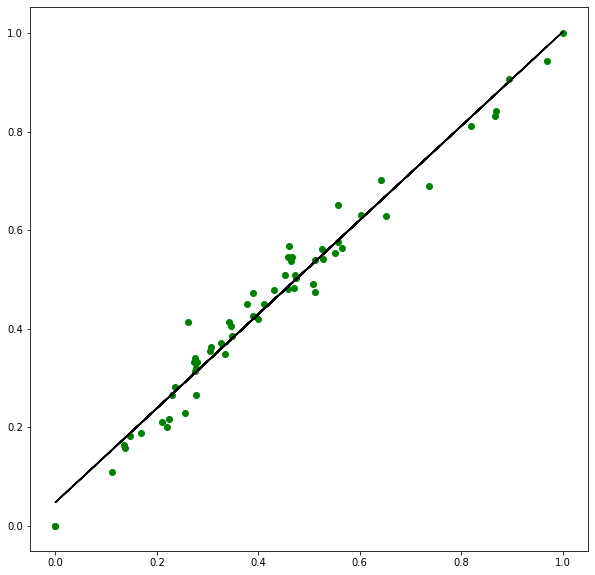

Ws1_std
(61, 1) (61,)
[0.75015505]
0.728588286014591


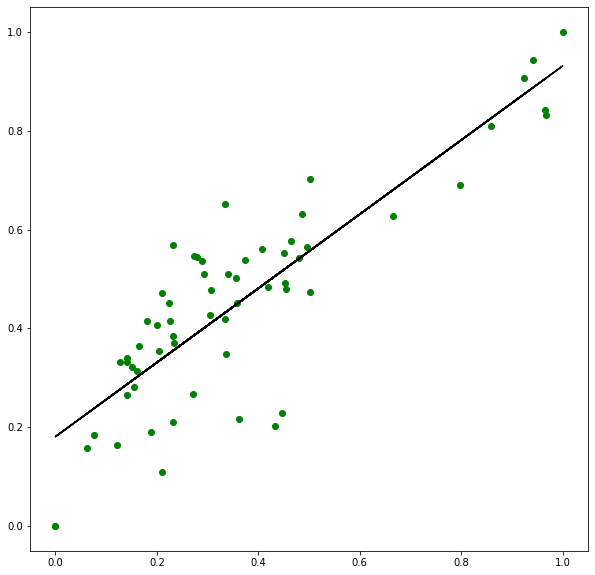

Ws2_avg
(61, 1) (61,)
[0.99295239]
0.9913778594977438


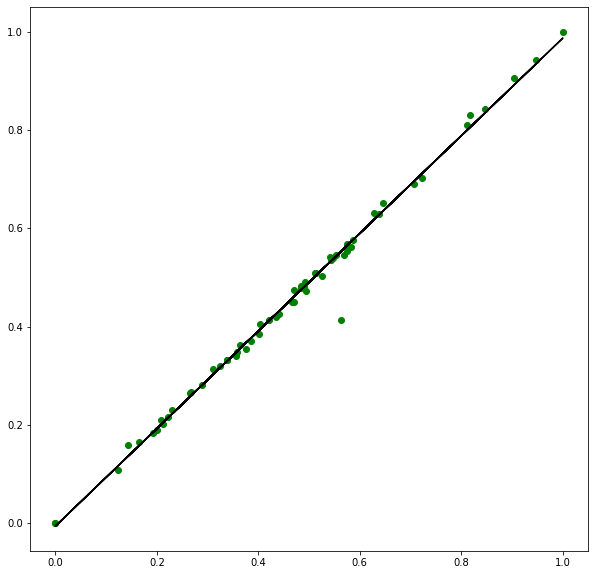

Ws2_min
(61, 1) (61,)
[0.86677018]
0.8994798373062373


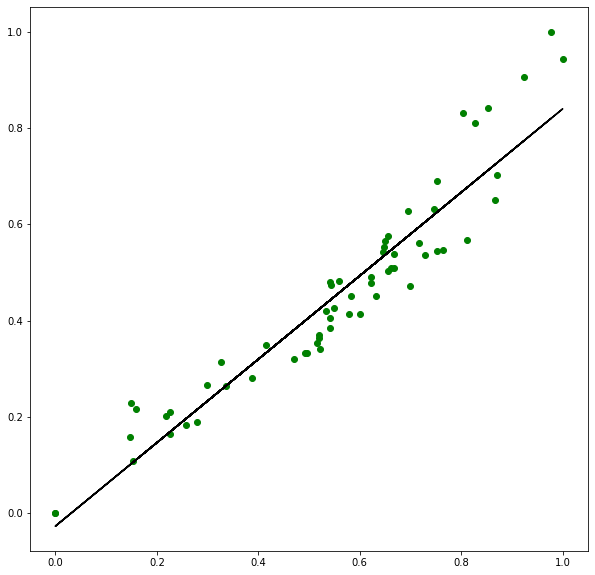

Ws2_max
(61, 1) (61,)
[0.95956477]
0.9737052695241987


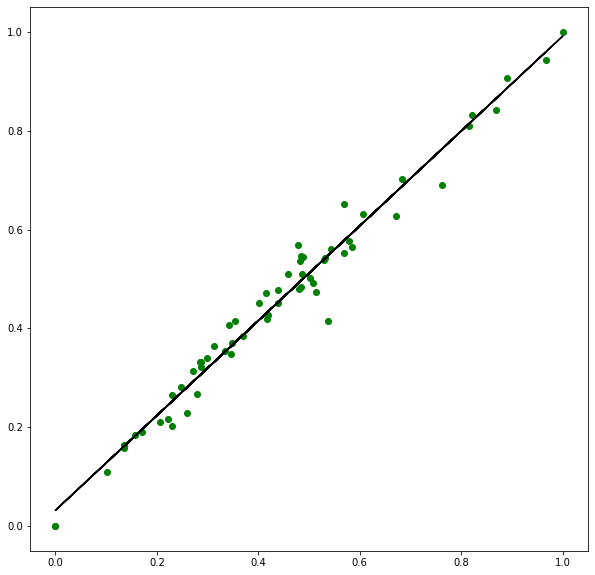

Ws2_std
(61, 1) (61,)
[0.77228561]
0.7457567068245485


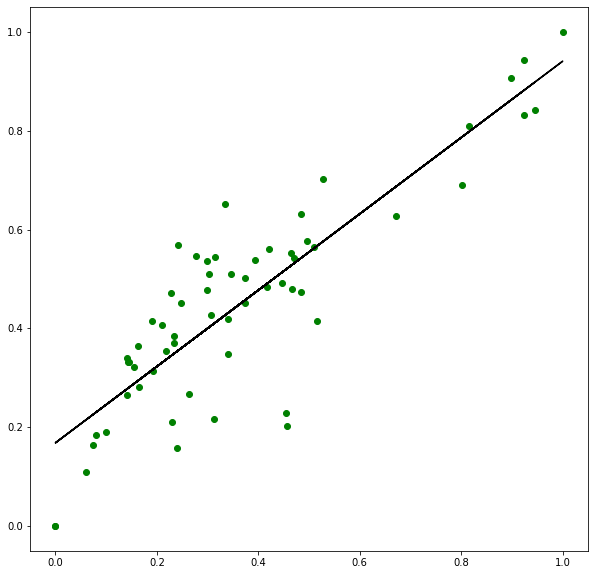

Ws_min
(61, 1) (61,)
[0.87615843]
0.9087164935231429


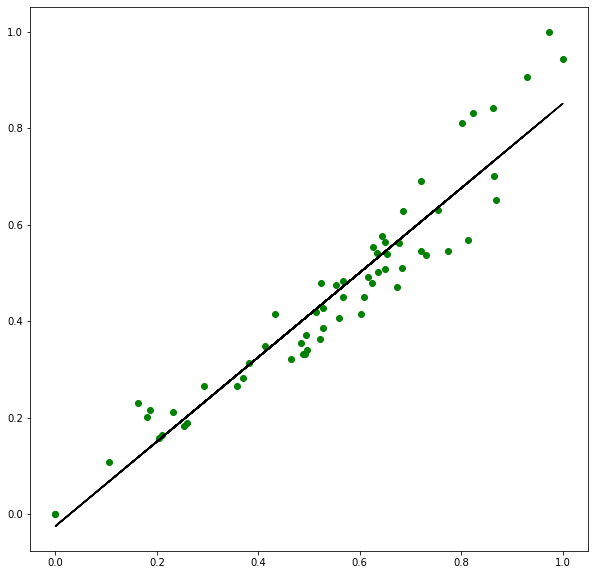

Ws_max
(61, 1) (61,)
[0.96205062]
0.9769672491963911


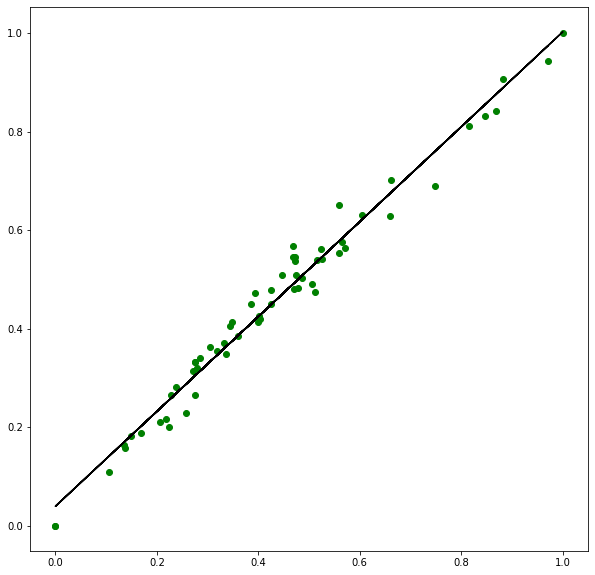

Ws_std
(61, 1) (61,)
[0.75846664]
0.7375065050749801


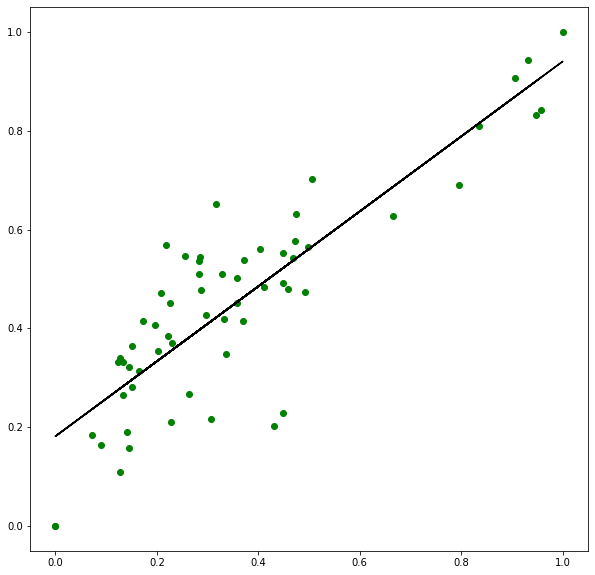

Wa_avg
(61, 1) (61,)
[0.21085911]
0.08080395722833122


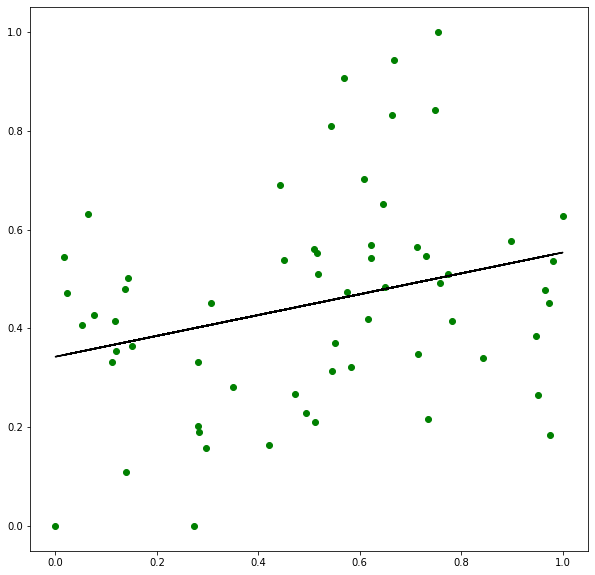

Wa_min
(61, 1) (61,)
[0.17109644]
0.042188362904446386


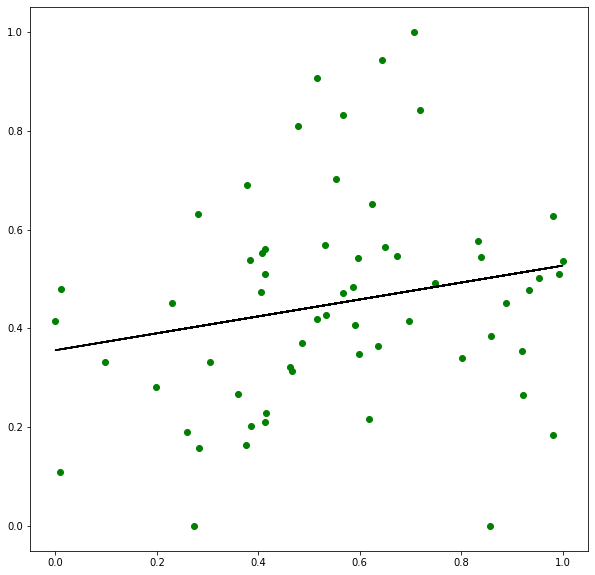

Wa_max
(61, 1) (61,)
[0.21629972]
0.07930522380874938


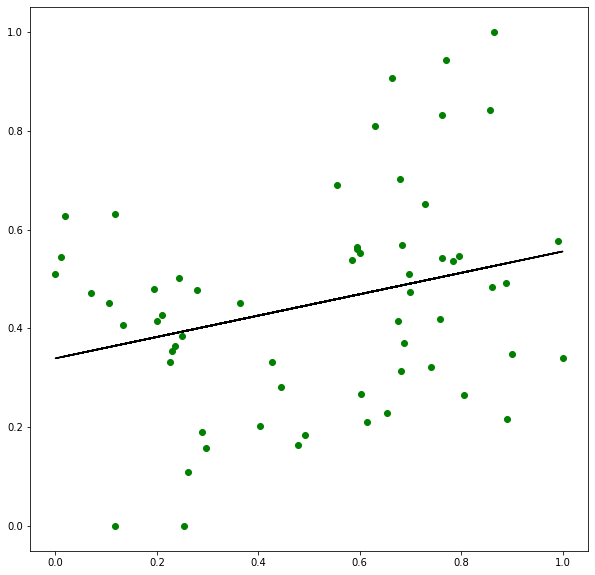

Wa_std
(61, 1) (61,)
[-0.20702183]
0.025385184536613533


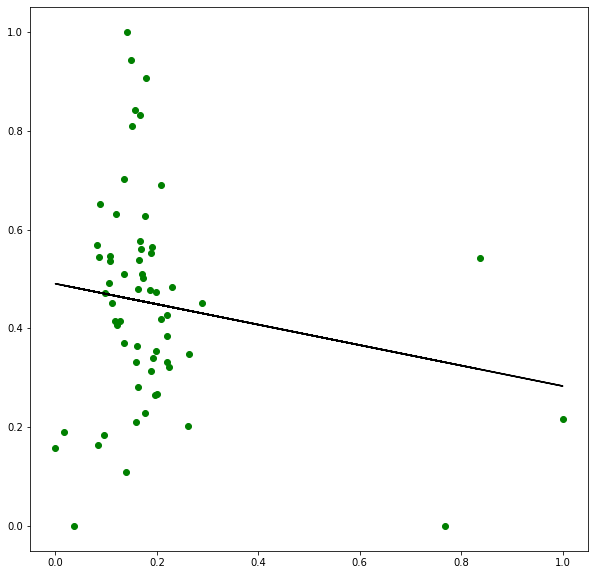

Va1_avg
(61, 1) (61,)
[-0.1597195]
0.01190373277800061


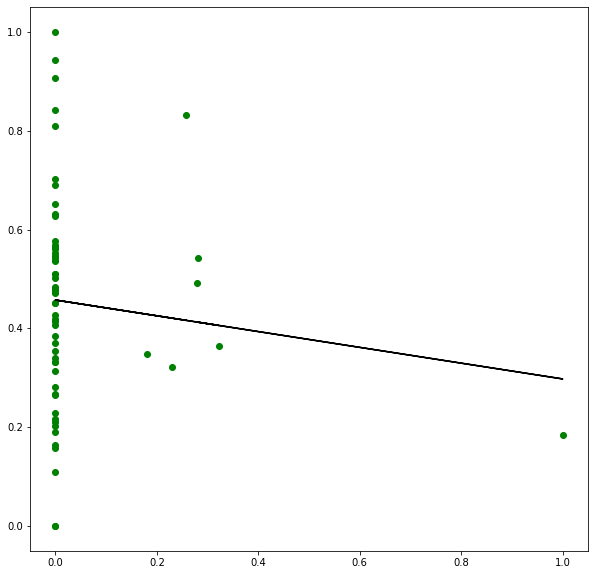

Va1_min
(61, 1) (61,)
[-0.18995025]
0.021613588753408908


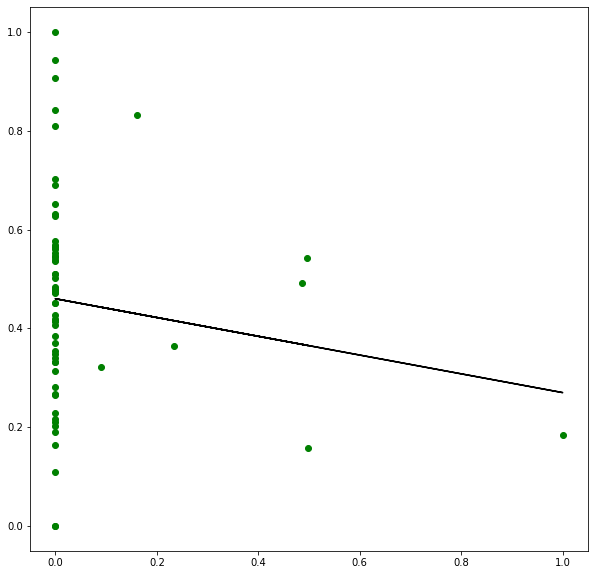

Va1_max
(61, 1) (61,)
[-0.07139041]
0.0055887573226868215


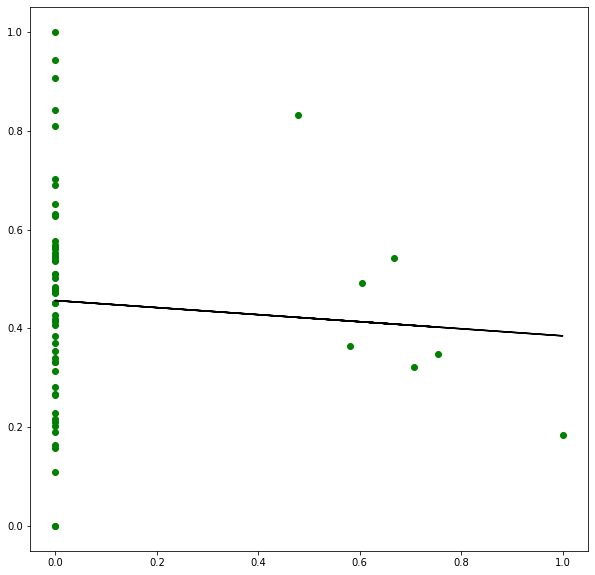

Va1_std
(61, 1) (61,)
[0.04555972]
0.0009014841144454611


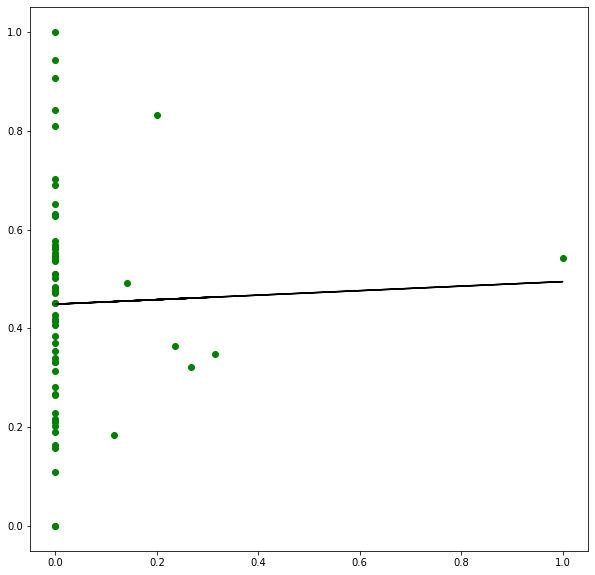

Va2_avg
(61, 1) (61,)
[-0.1597195]
0.01190373277800061


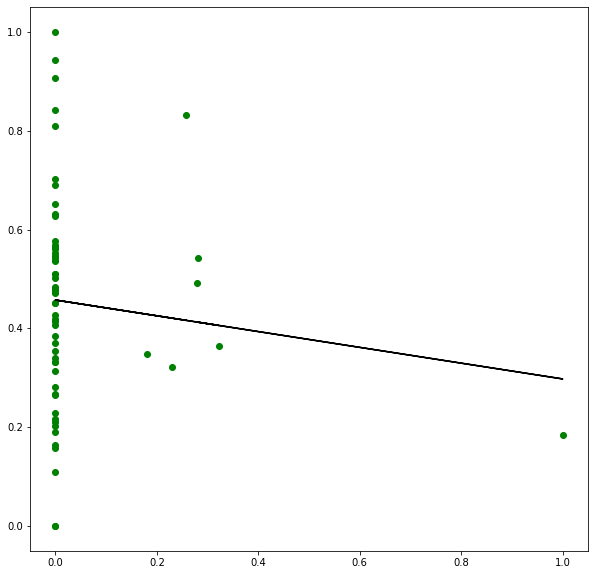

Va2_min
(61, 1) (61,)
[-0.18995025]
0.021613588753408908


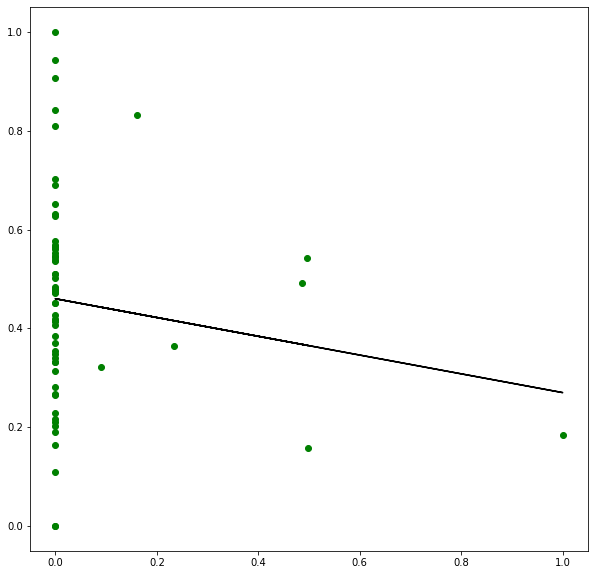

Va2_max
(61, 1) (61,)
[-0.07139041]
0.0055887573226868215


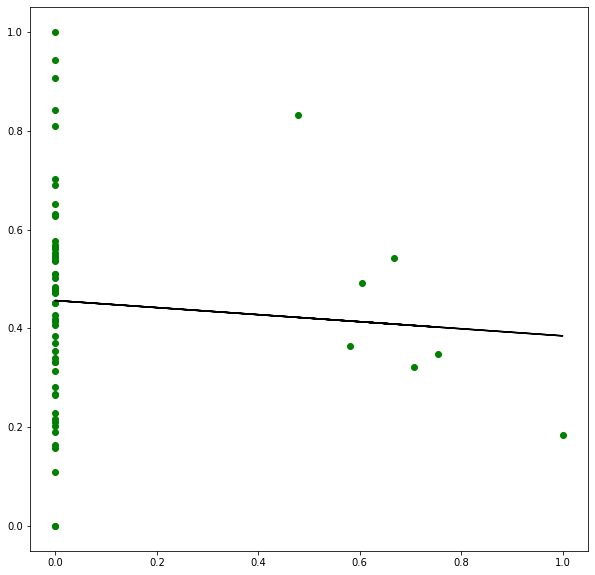

Va2_std
(61, 1) (61,)
[0.04555972]
0.0009014841144454611


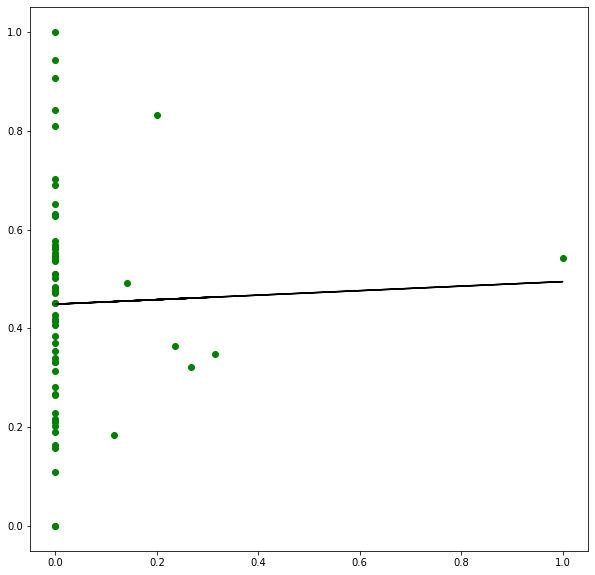

Va_avg
(61, 1) (61,)
[-0.43736496]
0.07153454837503082


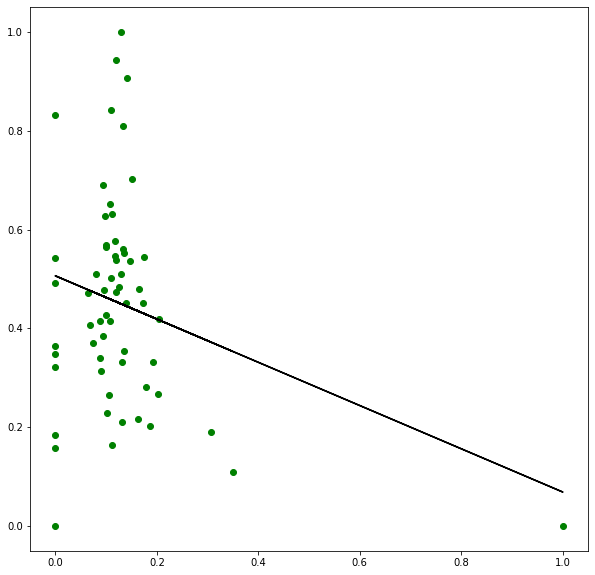

Va_min
(61, 1) (61,)
[-0.30271264]
0.03705851445650565


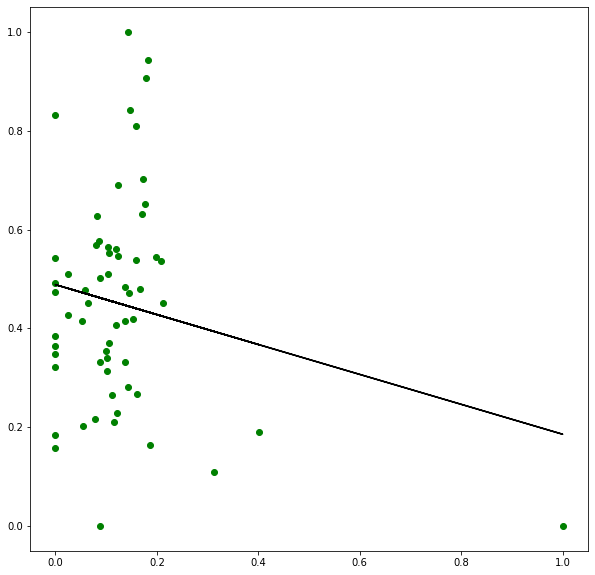

Va_max
(61, 1) (61,)
[-0.43526424]
0.10342823373909837


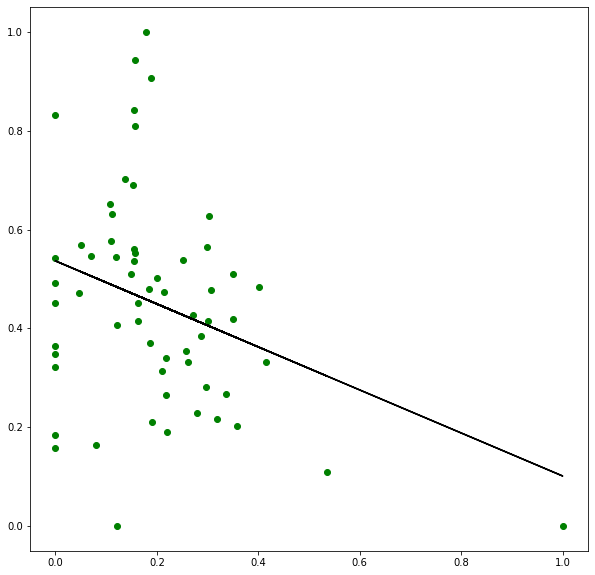

Va_std
(61, 1) (61,)
[-0.27064663]
0.03862554359441772


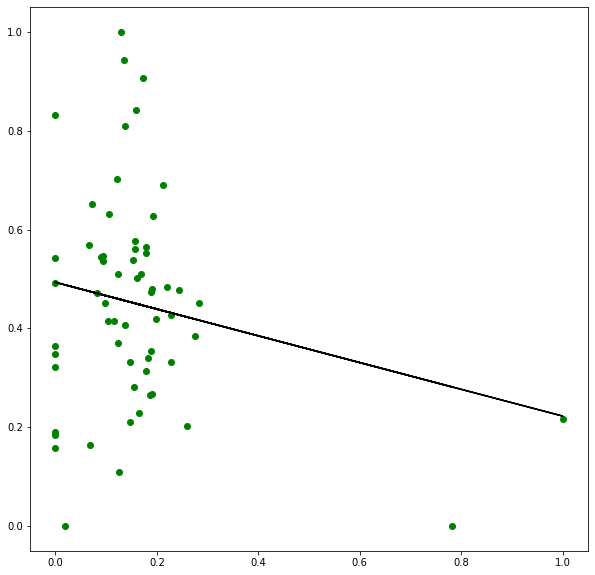

Ot_avg
(61, 1) (61,)
[-0.26573627]
0.10926486881684849


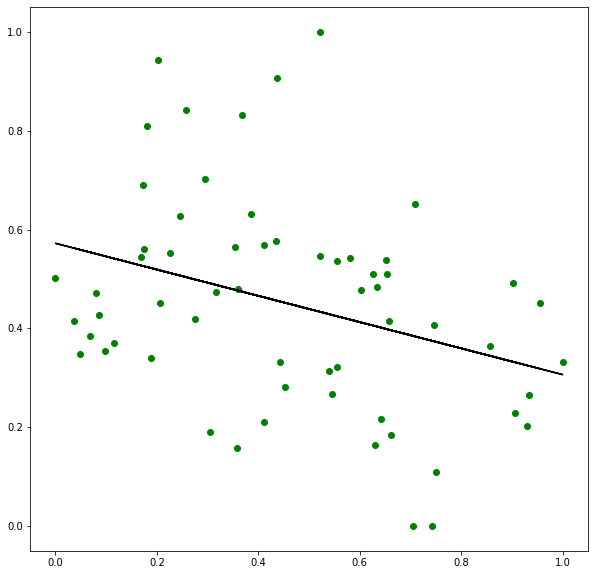

Ot_min
(61, 1) (61,)
[-0.26685096]
0.11081258415116724


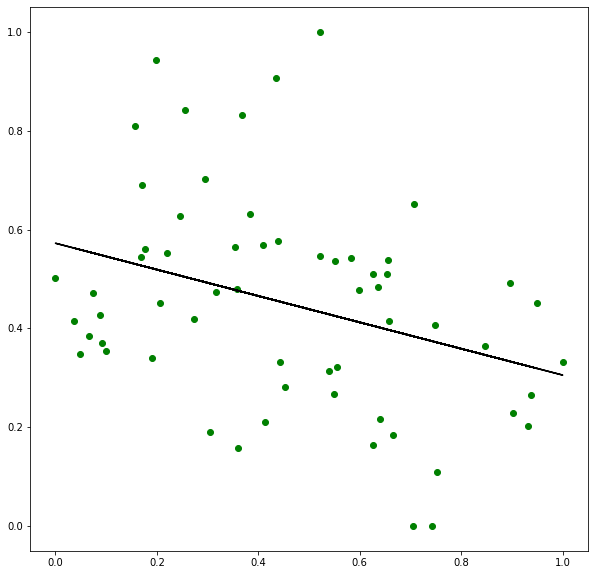

Ot_max
(61, 1) (61,)
[-0.26414031]
0.10869434368264608


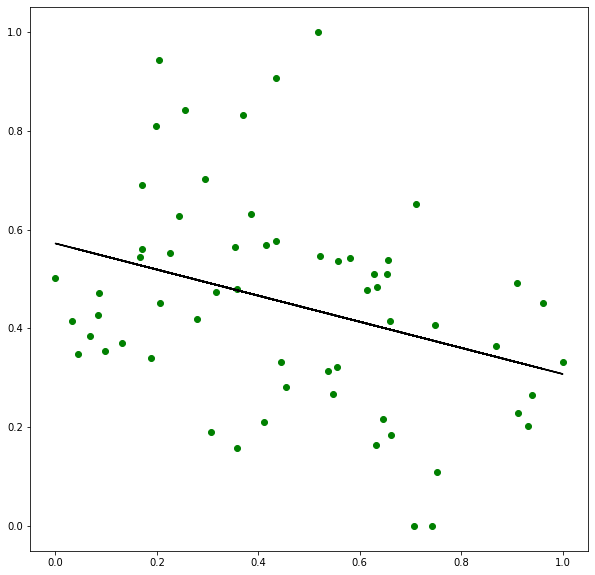

Ot_std
(61, 1) (61,)
[0.0509582]
0.00178691226599903


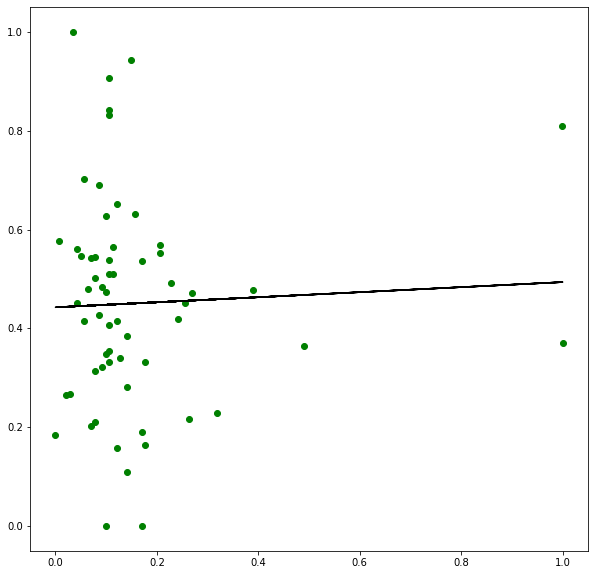

Nf_avg
(61, 1) (61,)
[0.20757849]
0.019249225193994413


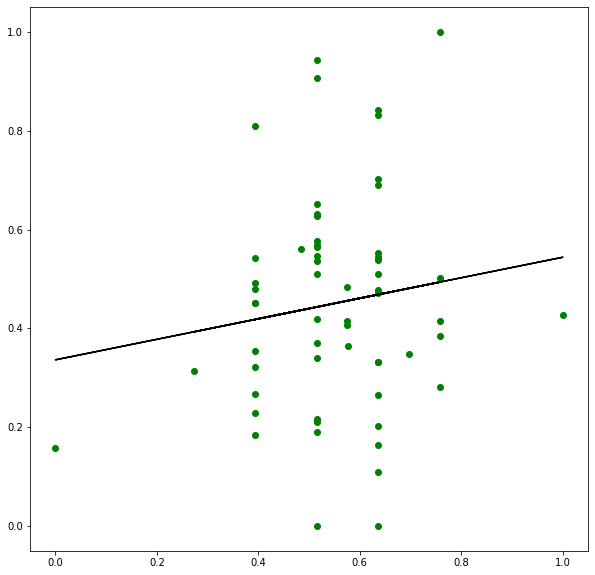

Nf_min
(61, 1) (61,)
[0.24925429]
0.041615962549466756


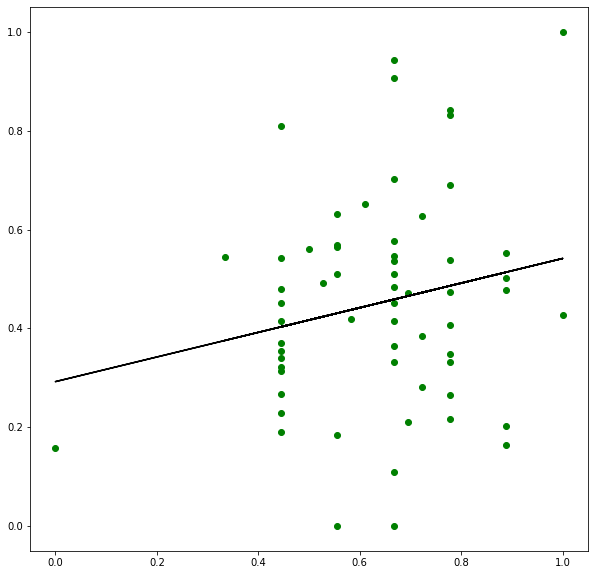

Nf_max
(61, 1) (61,)
[0.1268434]
0.008622259675310828


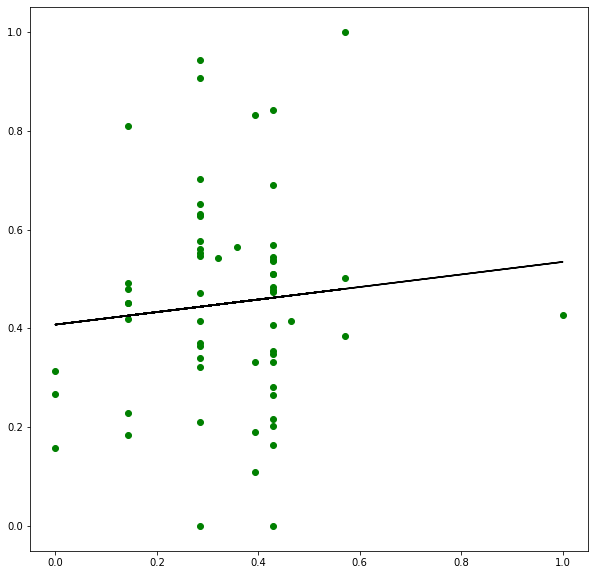

Nf_std
(61, 1) (61,)
[-0.21304873]
0.008113189361611983


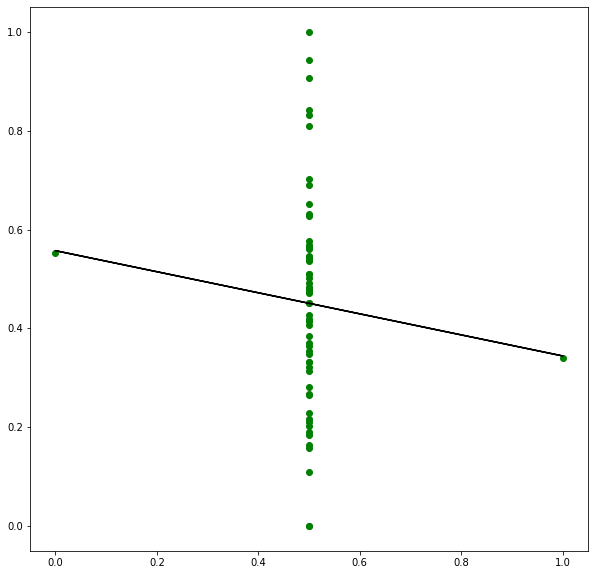

Nu_avg
(61, 1) (61,)
[0.63135629]
0.32067066465086014


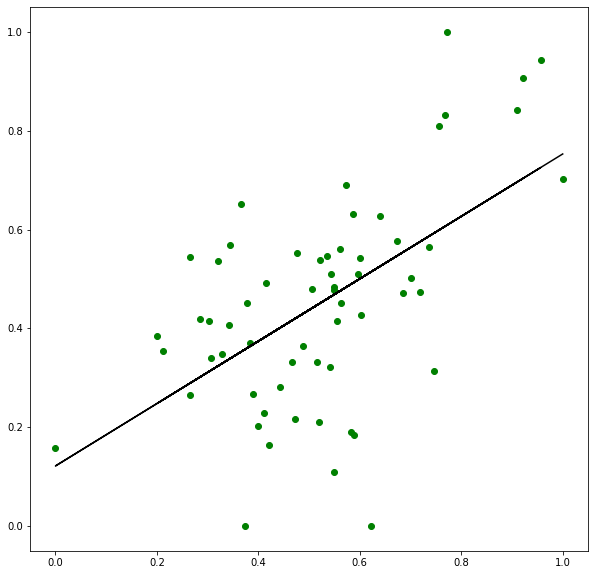

Nu_min
(61, 1) (61,)
[0.65280731]
0.29136813029722564


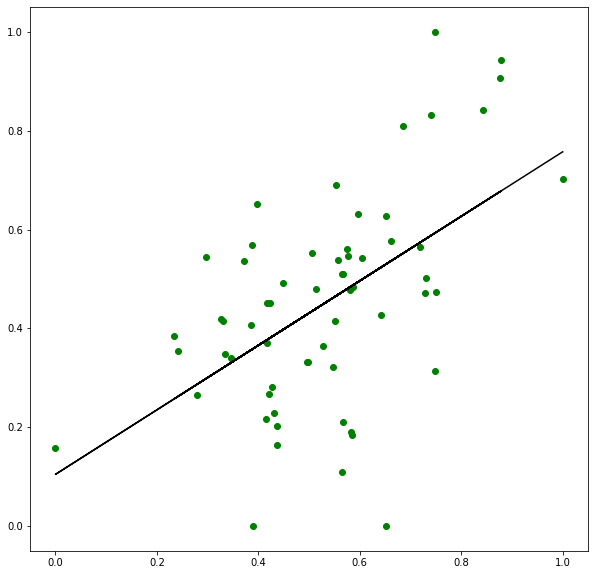

Nu_max
(61, 1) (61,)
[0.59027752]
0.35073702964294595


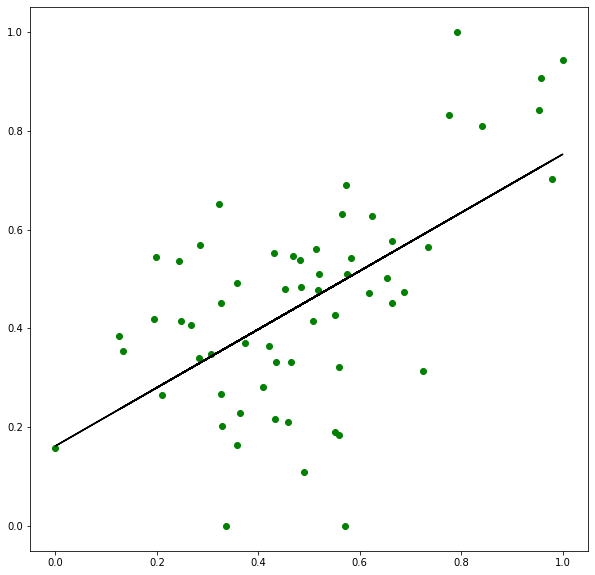

Nu_std
(61, 1) (61,)
[0.31545028]
0.041050894801145765


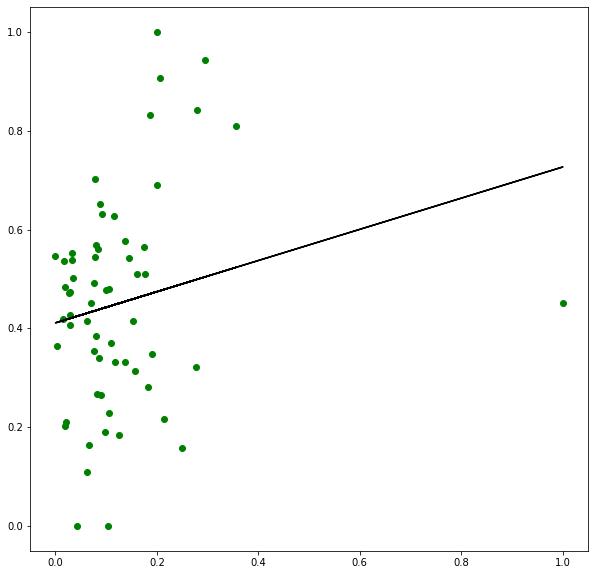

Rs_avg
(61, 1) (61,)
[0.6338939]
0.8145388704123702


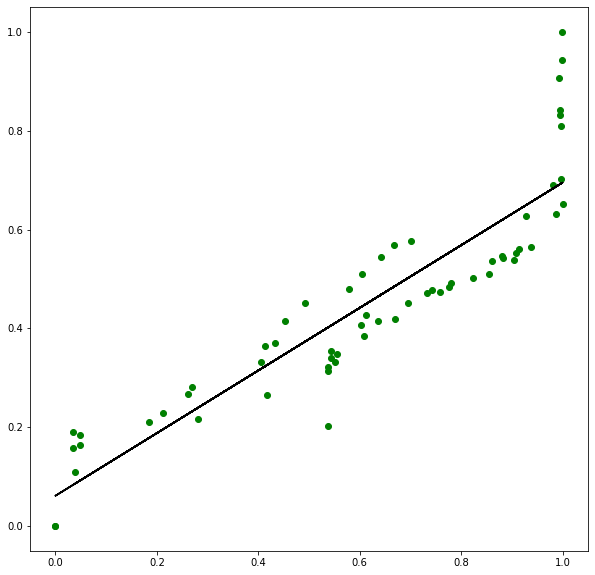

Rs_min
(61, 1) (61,)
[0.6751137]
0.8203956550167791


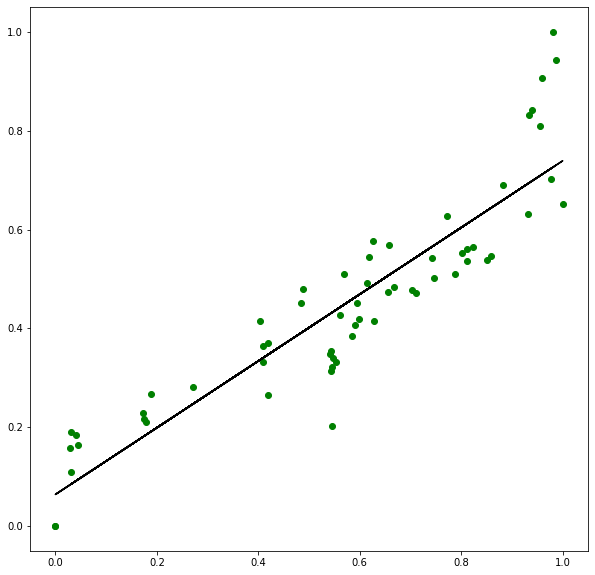

Rs_max
(61, 1) (61,)
[0.61981652]
0.7909667230491433


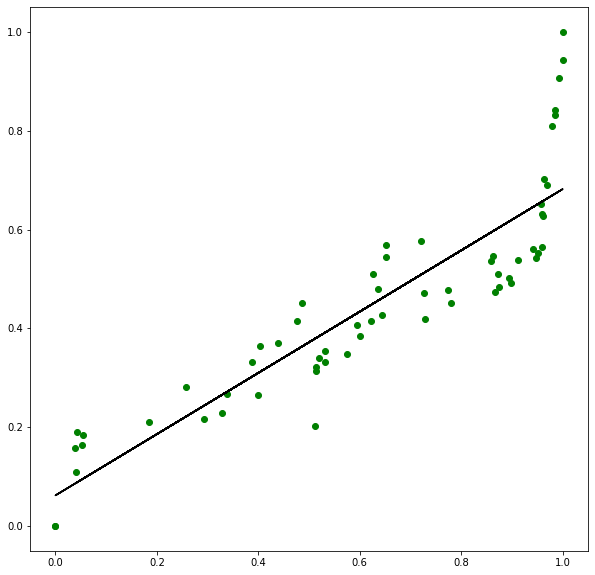

Rs_std
(61, 1) (61,)
[0.21001721]
0.0491203065387148


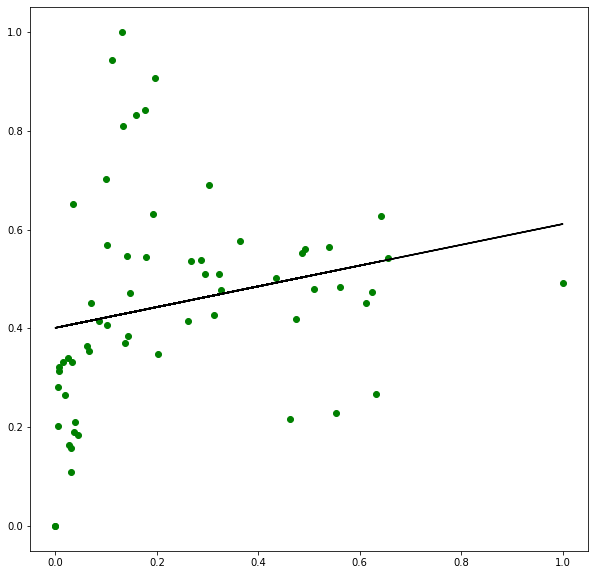

Rbt_avg
(61, 1) (61,)
[0.19452295]
0.03659374350205413


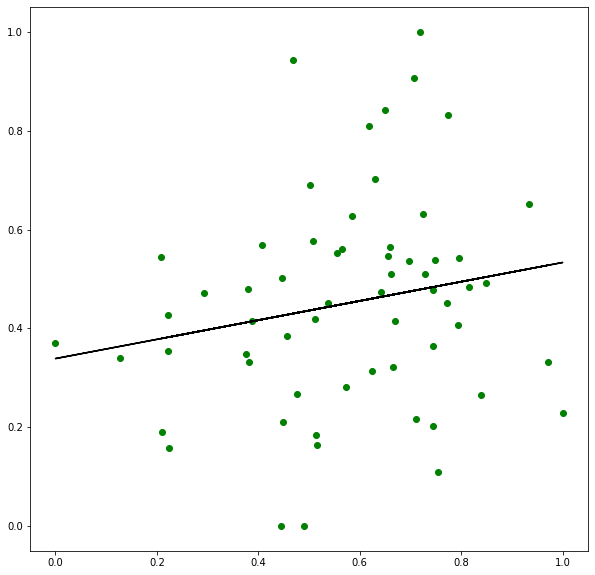

Rbt_min
(61, 1) (61,)
[0.19596271]
0.03706357829421847


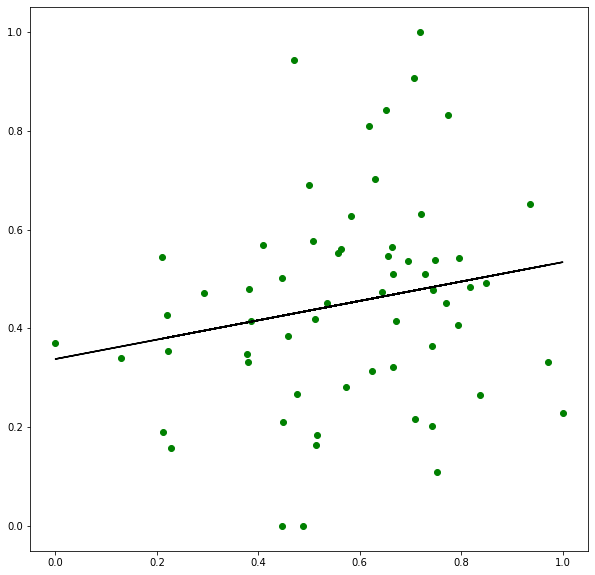

Rbt_max
(61, 1) (61,)
[0.19339594]
0.03597598048420014


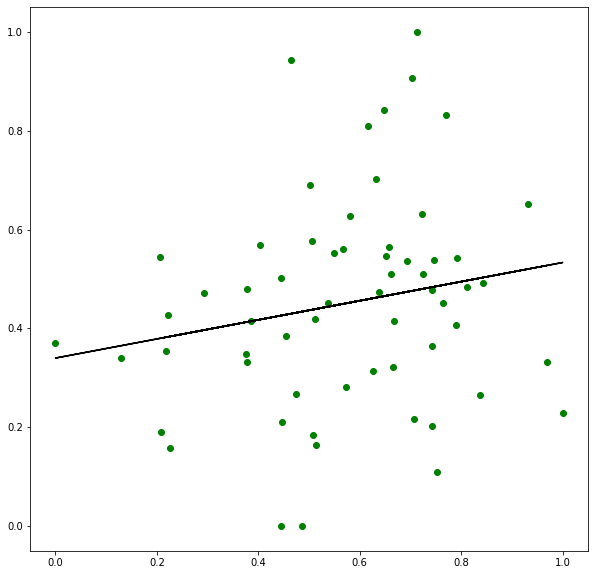

Rbt_std
(61, 1) (61,)
[-0.07373536]
0.007849036738418746


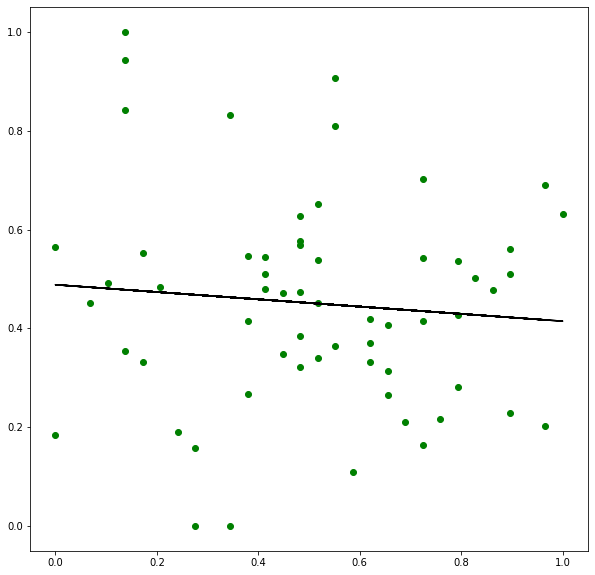

Rm_avg
(61, 1) (61,)
[0.79462195]
0.882677418312846


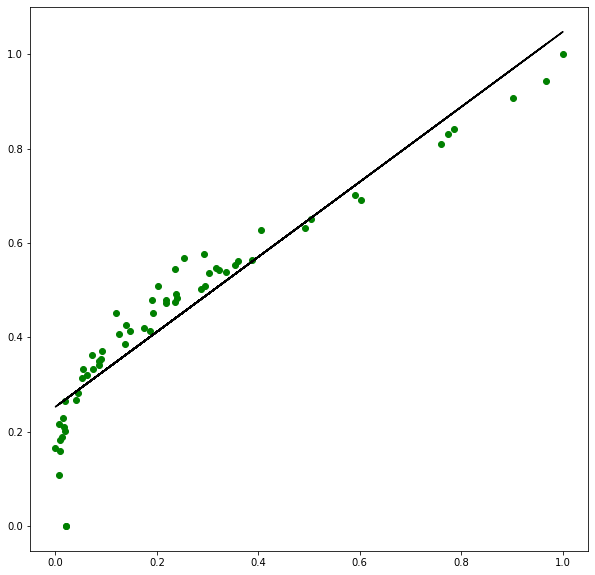

Rm_min
(61, 1) (61,)
[0.74543529]
0.8754566963544793


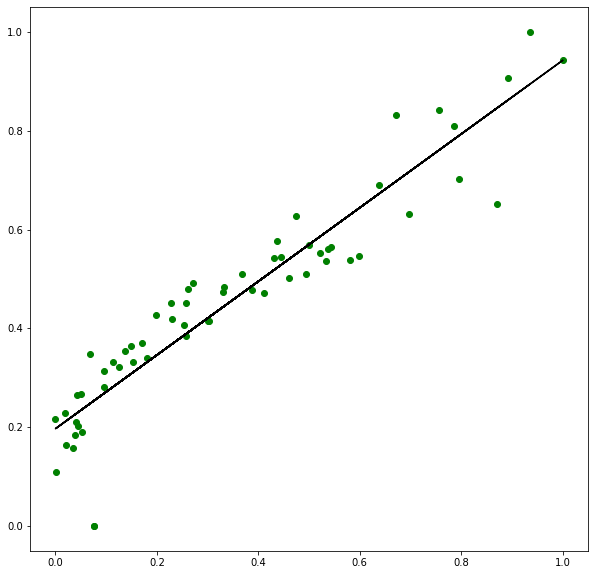

Rm_max
(61, 1) (61,)
[0.64276616]
0.8458822336834019


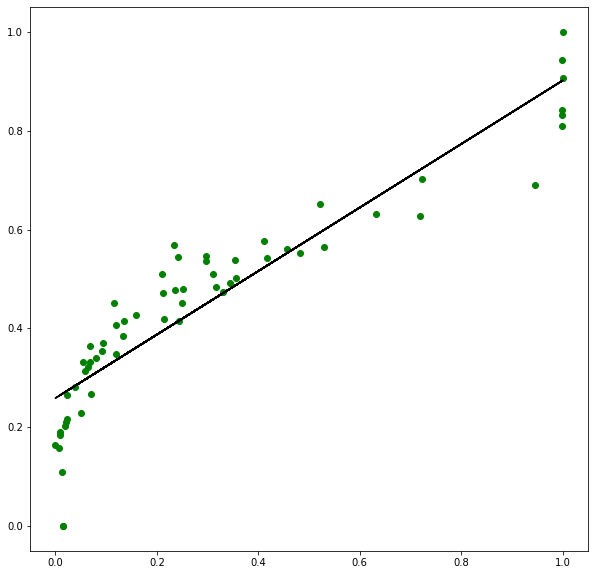

Rm_std
(61, 1) (61,)
[0.68578377]
0.6731248156259465


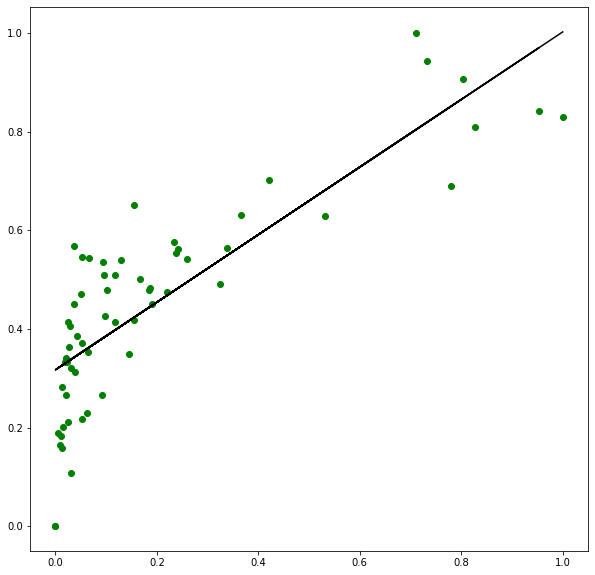

Wa_c_avg
(61, 1) (61,)
[0.20310005]
0.10126797684926747


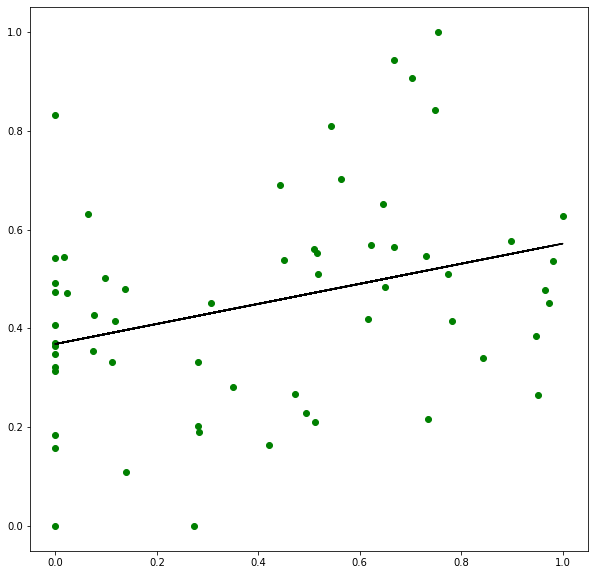

Na_c_avg
(61, 1) (61,)
[0.15757519]
0.06308321387703242


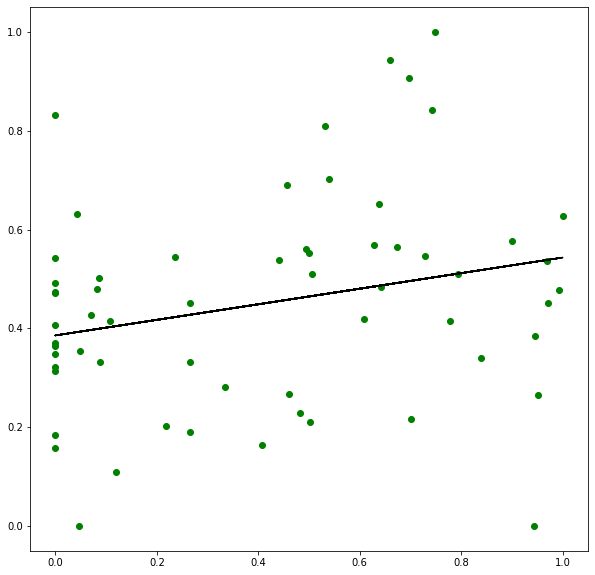

mean_2m_air_temperature
(61, 1) (61,)
[-0.19146802]
0.060429843771110936


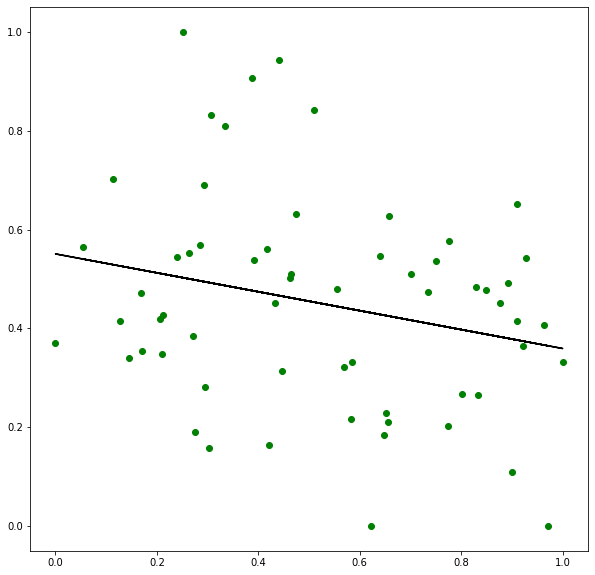

minimum_2m_air_temperature
(61, 1) (61,)
[-0.14585572]
0.034306411911077084


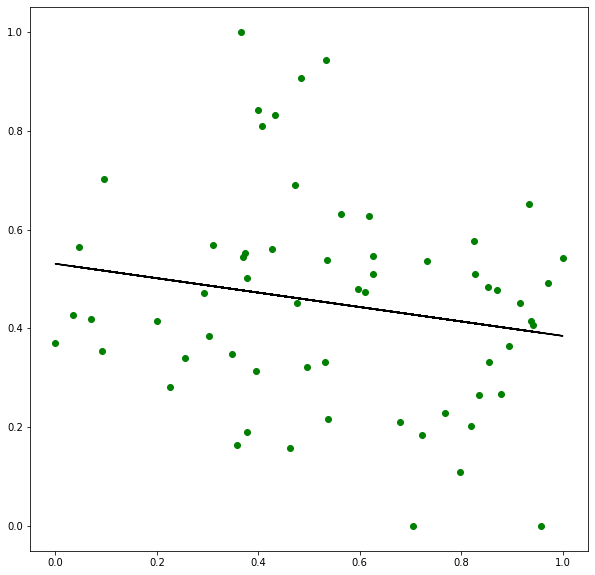

maximum_2m_air_temperature
(61, 1) (61,)
[-0.1836339]
0.05465987614338985


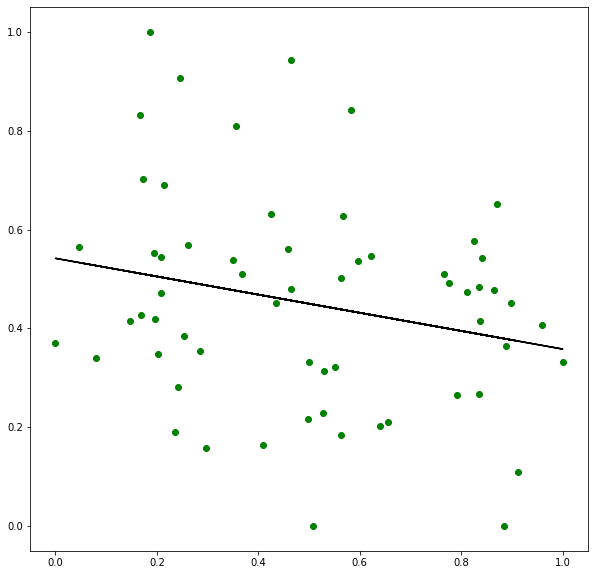

dewpoint_2m_temperature
(61, 1) (61,)
[-0.21675023]
0.07781654293705054


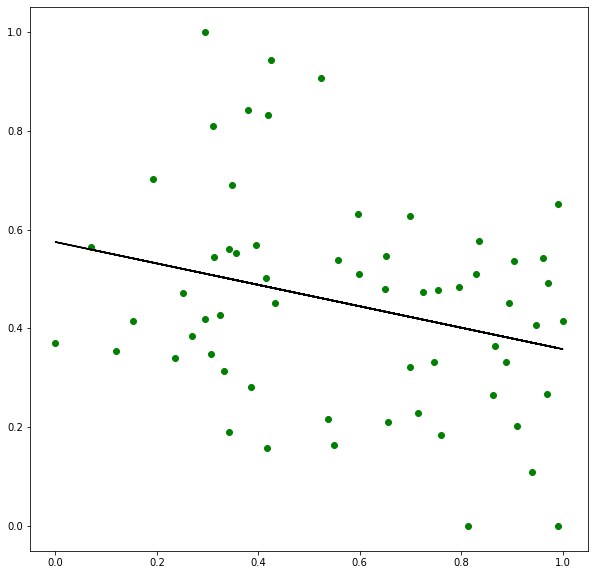

total_percipitation
(61, 1) (61,)
[0.03234589]
0.0011224968738856589


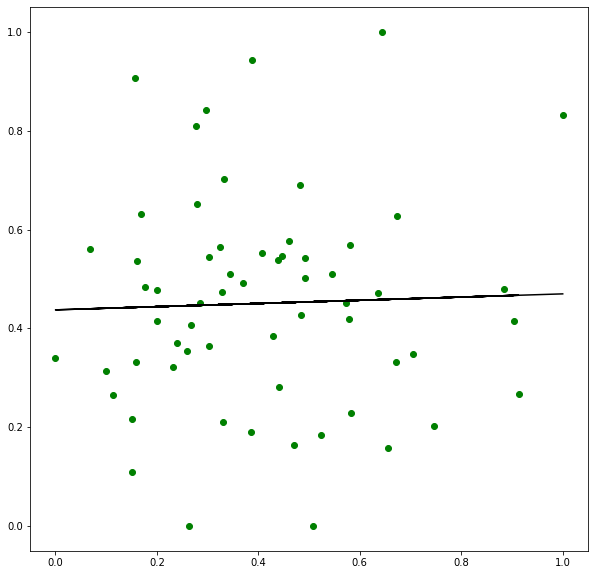

surface_pressure
(61, 1) (61,)
[-0.10228467]
0.006396054513730153


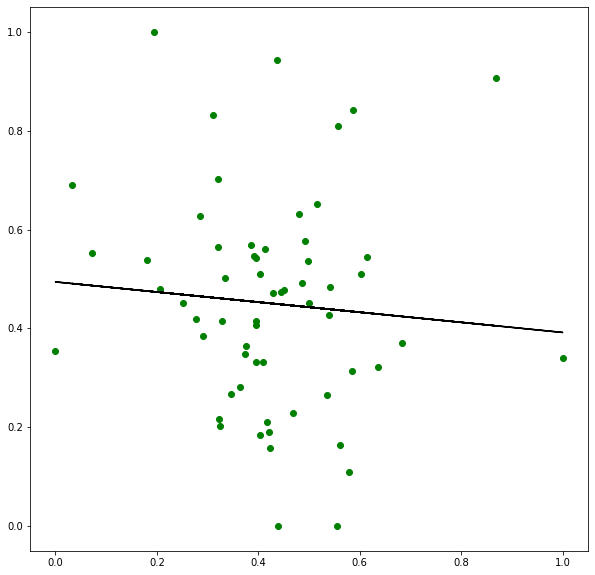

mean_sea_level_pressure
(61, 1) (61,)
[-0.03894]
0.0009261250919103681


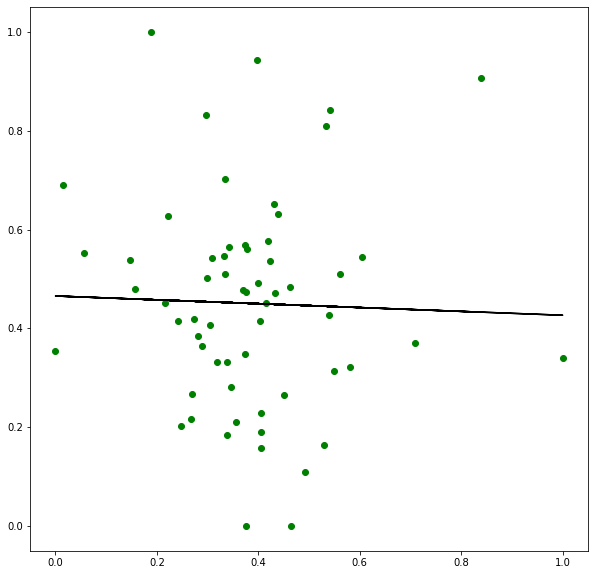

u_component_of_wind_10m
(61, 1) (61,)
[0.05675372]
0.0036118920730969784


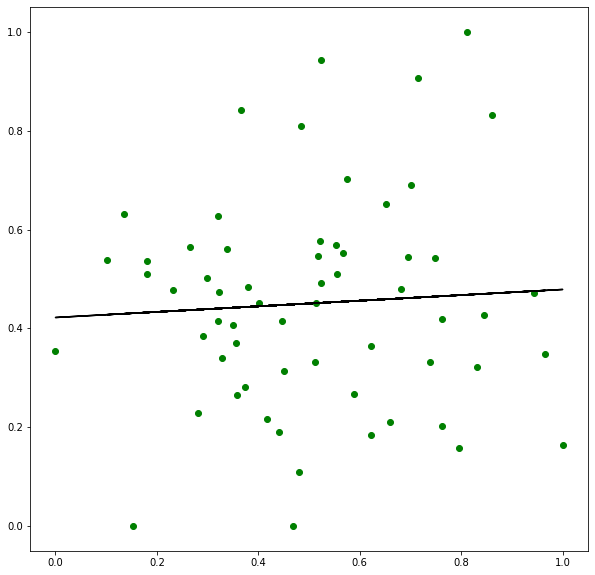

v_component_of_wind_10m
(61, 1) (61,)
[0.08262326]
0.007069896134440423


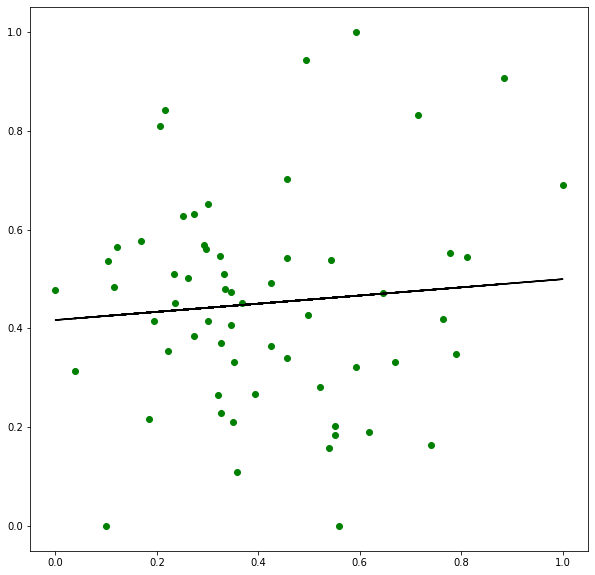

sat_wind_mag
(61, 1) (61,)
[0.06414288]
0.006115951644880213


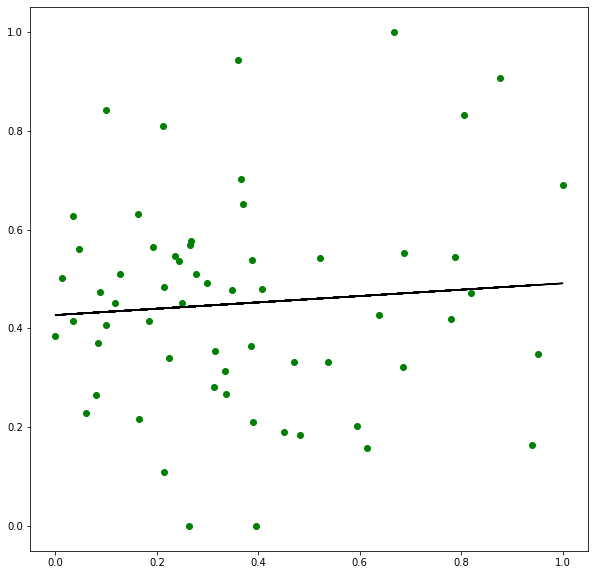

sat_wind_ang
(61, 1) (61,)
[-0.05026949]
0.0029107406386756907


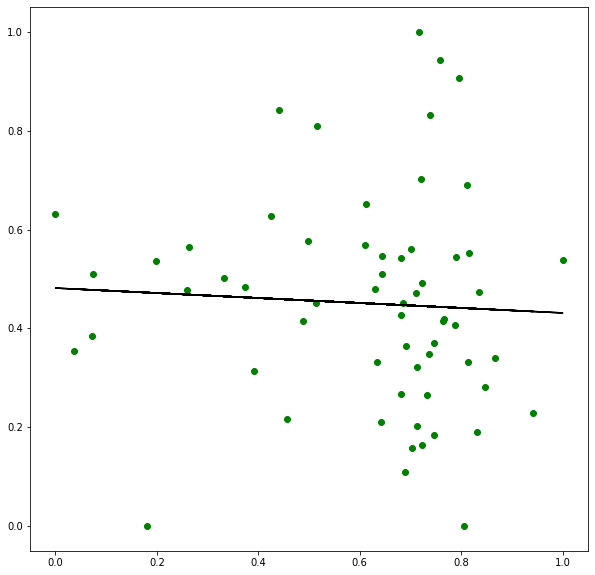

In [45]:
y_label = 'Ws_avg'
for x_label in final_data.keys():
  if x_label == y_label:
    continue
  print(x_label)
  linearRegress(x_label, y_label)